### Simple 2D exampling of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.3.1+cu118].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'cuda' if th.cuda.is_available() else 'mps'
print ("device:[%s]"%(device))

device:[cuda]


### Training data `x_0`: [N x C x W x H]

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
x_0 = train_data[:,None,:,:].to(device)/255.
print ("MNIST ready. train_data:[%s]"%(get_torch_size_string(x_0)))

MNIST ready. train_data:[60000x1x28x28]


In [4]:
print(train_label[59999])

tensor(8)


In [5]:
print(train_data[59999])
print(x_0[0])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

### Embeddings

In [1]:
import torch
import torch.nn as nn

# 임베딩 차원 설정 (예: 8차원 임베딩 벡터)
embedding_dim = 8

# circle 임베딩
circle_embedding = nn.Embedding(2, embedding_dim).to(device)
number_embedding = nn.Embedding(10, embedding_dim).to(device)
# glasses_embedding = nn.Embedding(2, embedding_dim)

# 가중치 초기화 (선택 사항)
# nn.init.xavier_uniform_(circle_embedding.weight)
# nn.init.xavier_uniform_(glasses_embedding.weight)

NameError: name 'device' is not defined

In [7]:
def get_conditioning_embedding(number, device):
    circle_label = 0
    if number == 0 or number == 6 or number == 8 or number == 9:
        circle_label = 1
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

test_number = 7
embedding_vector = get_conditioning_embedding(test_number, device)
print(embedding_vector)

embedding_vectors = torch.stack([get_conditioning_embedding(label.item(),device) for label in train_label])

# test_labels = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
# test_embedding_vectors = torch.stack([get_conditioning_embedding(label,device) for label in test_labels])

test_embedding_vector = get_conditioning_embedding(0,device)

tensor([-0.419,  1.322,  1.642,  0.128, -0.523, -1.164, -0.133, -0.990, -1.054,
         0.693, -0.712, -0.695, -0.344,  0.275, -0.497, -1.057],
       device='cuda:0', grad_fn=<CatBackward0>)


In [8]:
print(train_label[-10:])
print(embedding_vectors[59995])
print(embedding_vectors[59999])

tensor([9, 2, 9, 5, 1, 8, 3, 5, 6, 8])
tensor([-1.097,  0.299,  1.255,  0.288,  0.561,  0.438,  1.123,  0.402,  1.782,
         1.067,  0.255,  0.058, -1.275, -0.086,  0.071, -0.542],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-1.097,  0.299,  1.255,  0.288,  0.561,  0.438,  1.123,  0.402,  1.782,
         1.067,  0.255,  0.058, -1.275, -0.086,  0.071, -0.542],
       device='cuda:0', grad_fn=<SelectBackward0>)


### Train 

it:[      0][0.0]% loss:[0.5104]


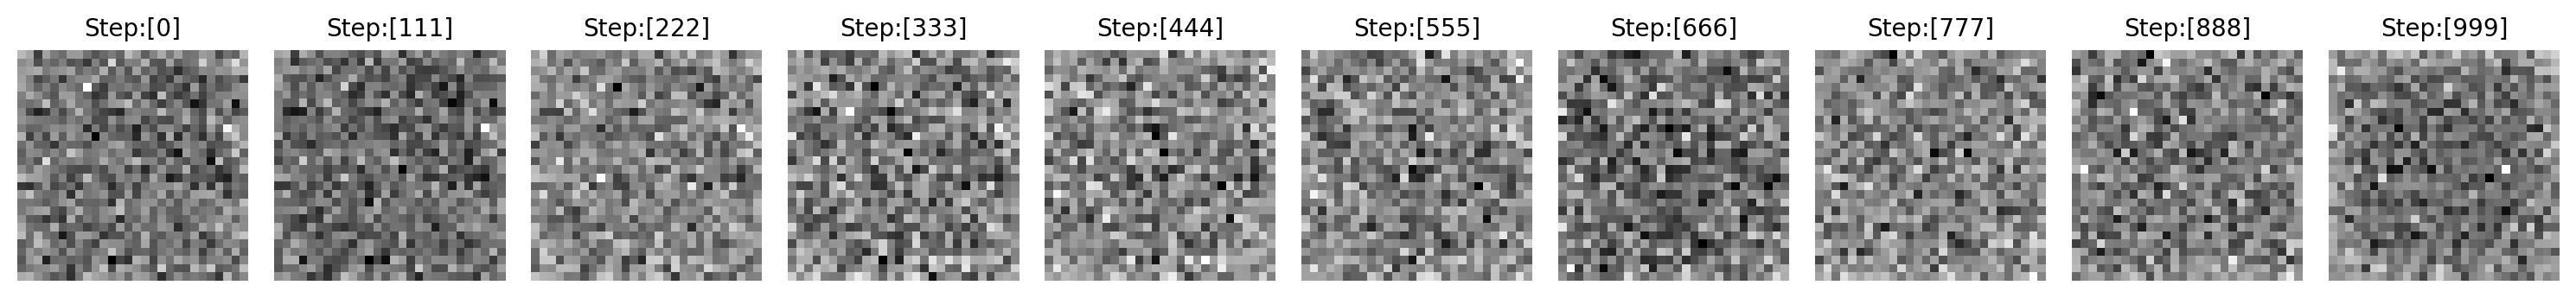

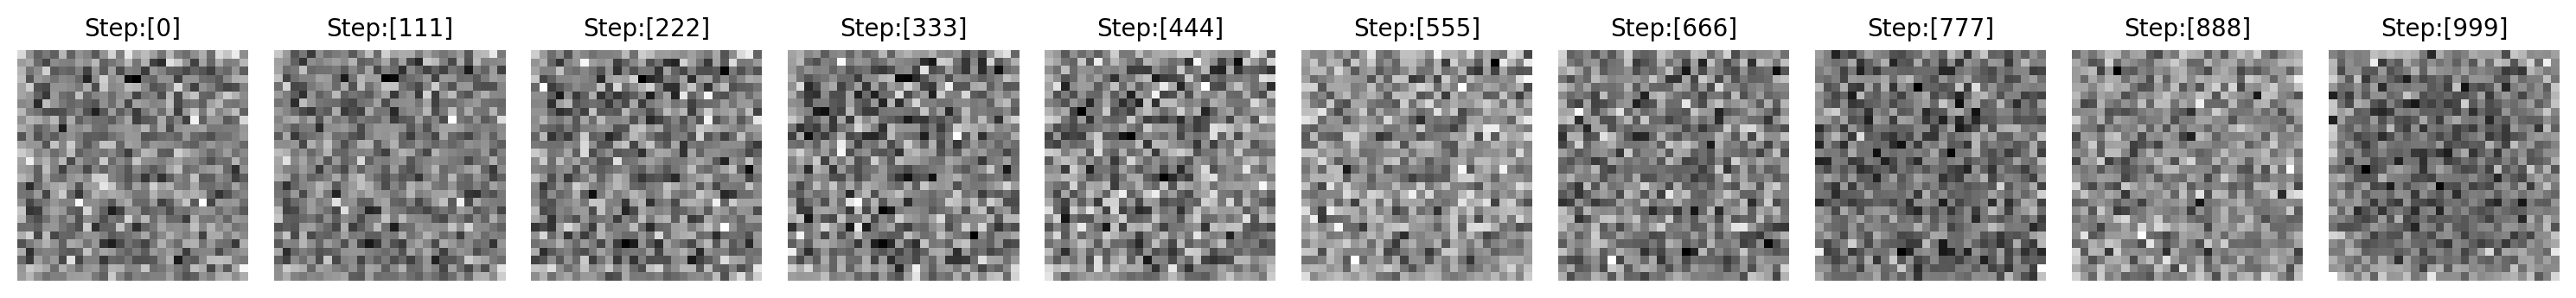

it:[   1000][10.0]% loss:[0.1090]
it:[   2000][20.0]% loss:[0.0811]


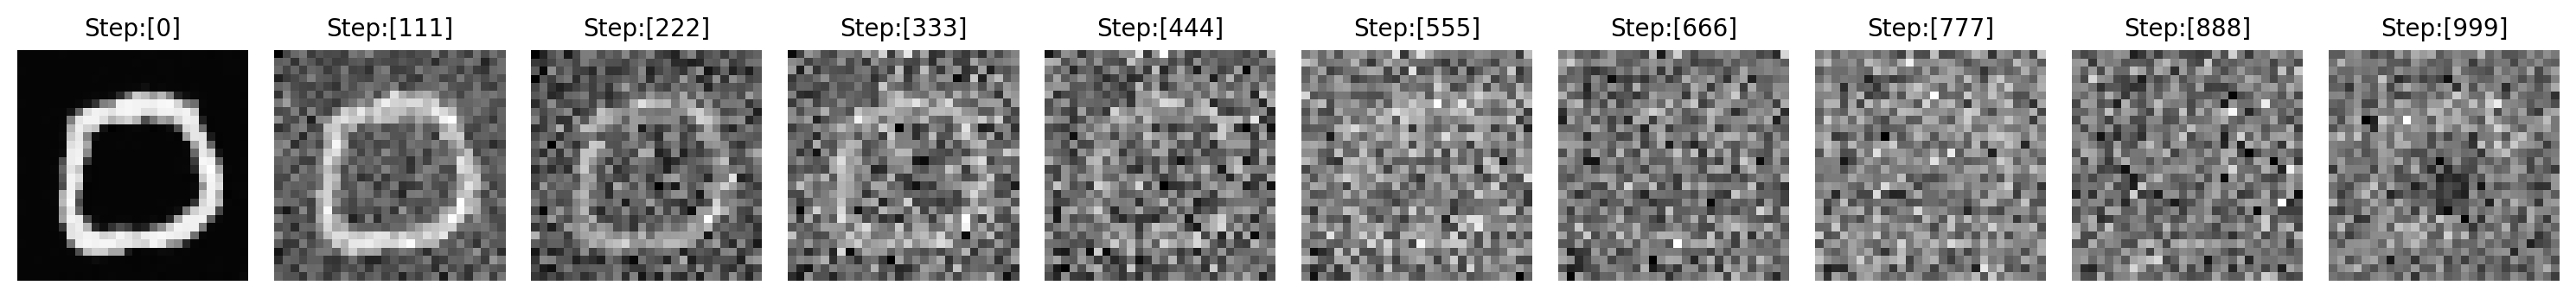

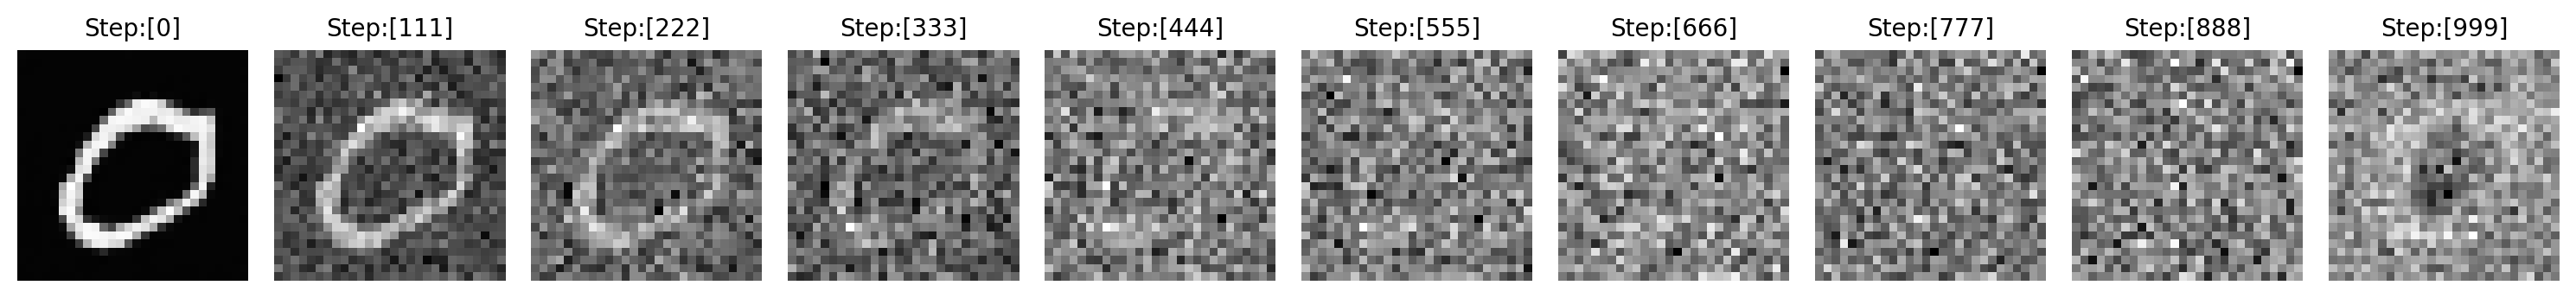

it:[   3000][30.0]% loss:[0.0882]
it:[   4000][40.0]% loss:[0.0722]


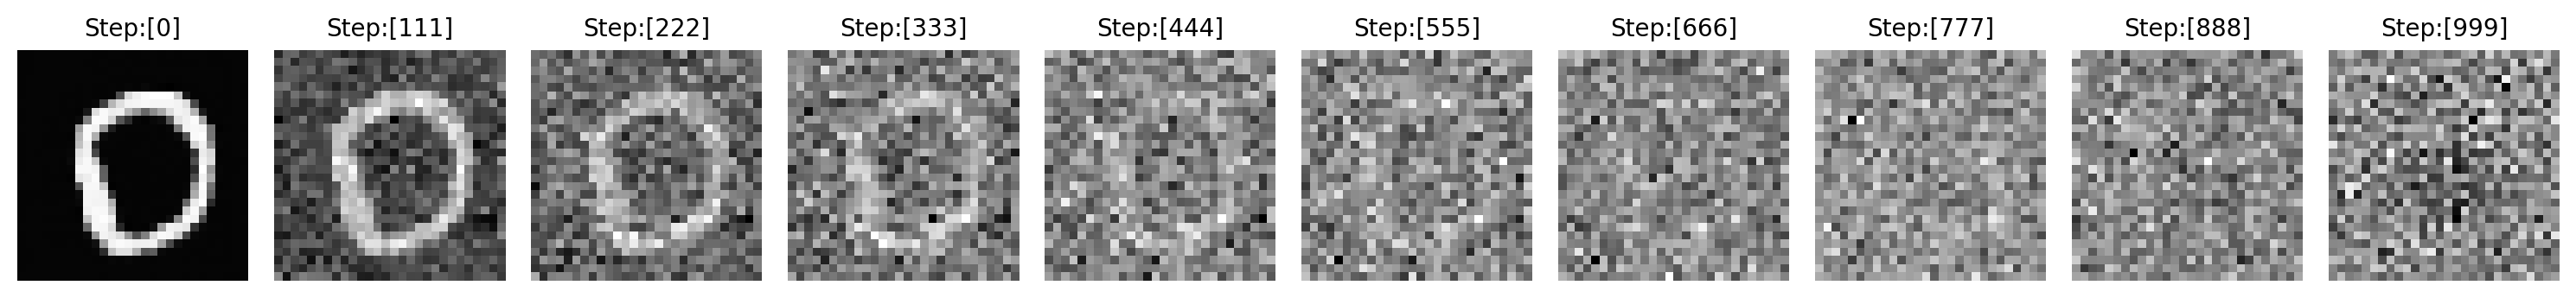

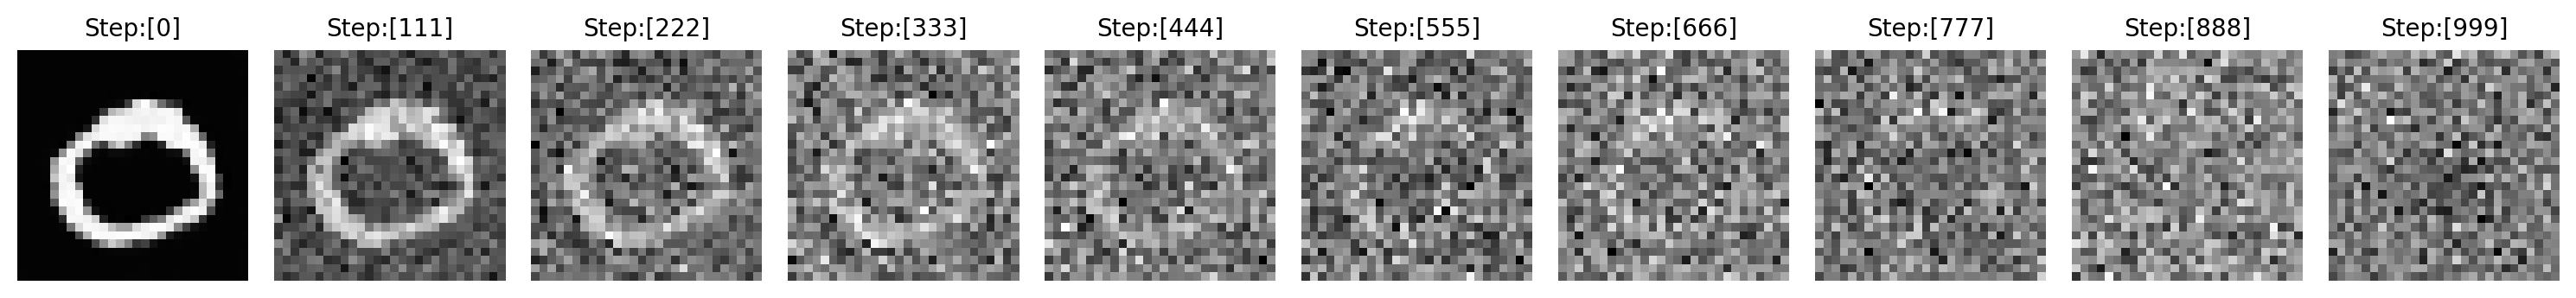

it:[   5000][50.0]% loss:[0.0857]
it:[   6000][60.0]% loss:[0.0685]


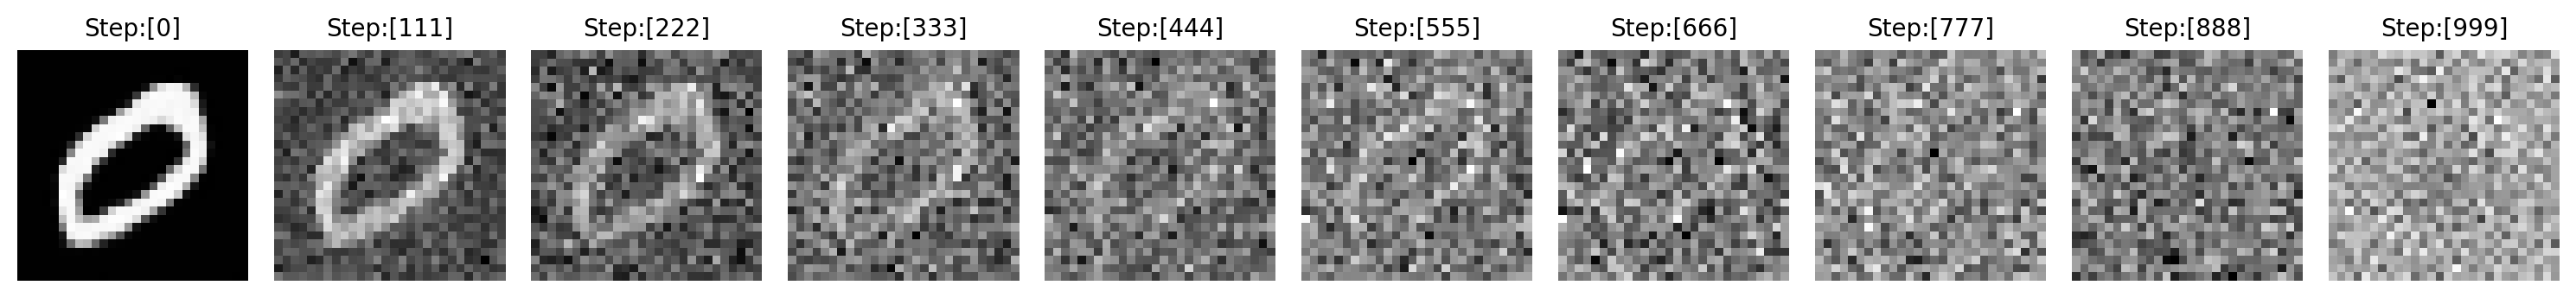

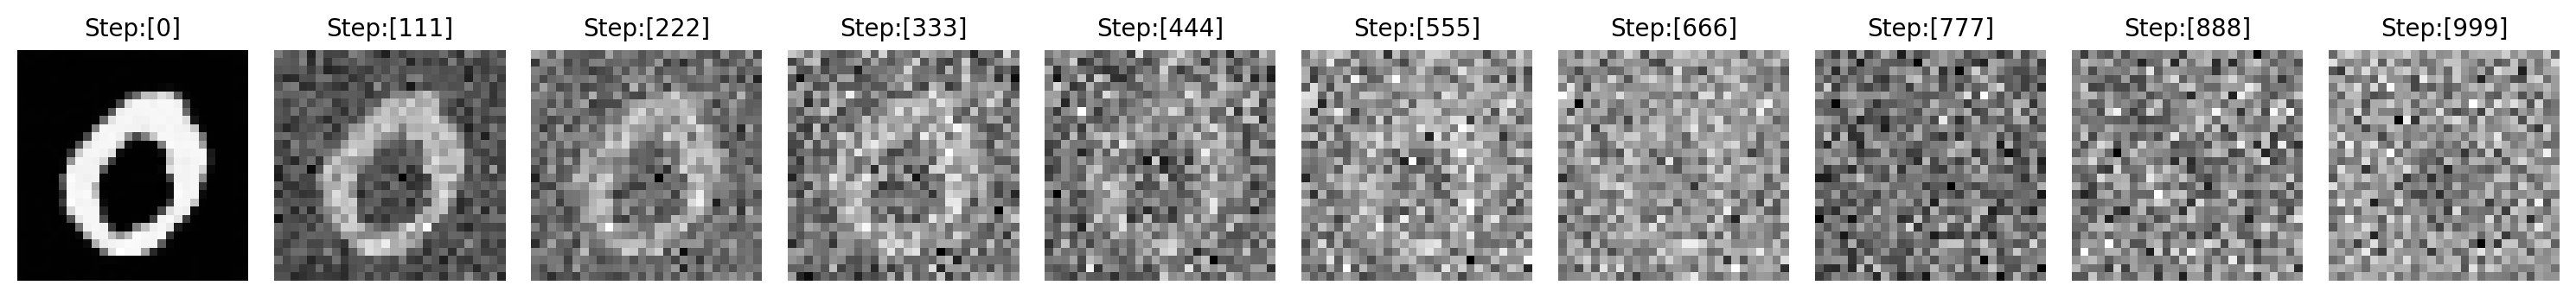

it:[   7000][70.0]% loss:[0.0642]
it:[   8000][80.0]% loss:[0.0708]


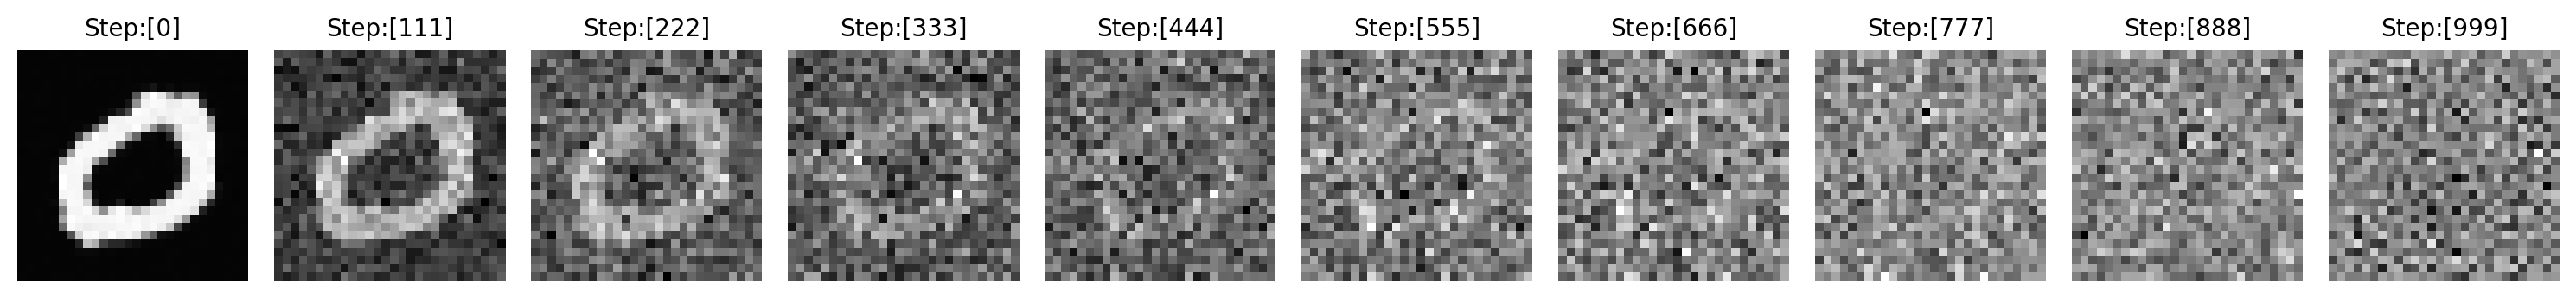

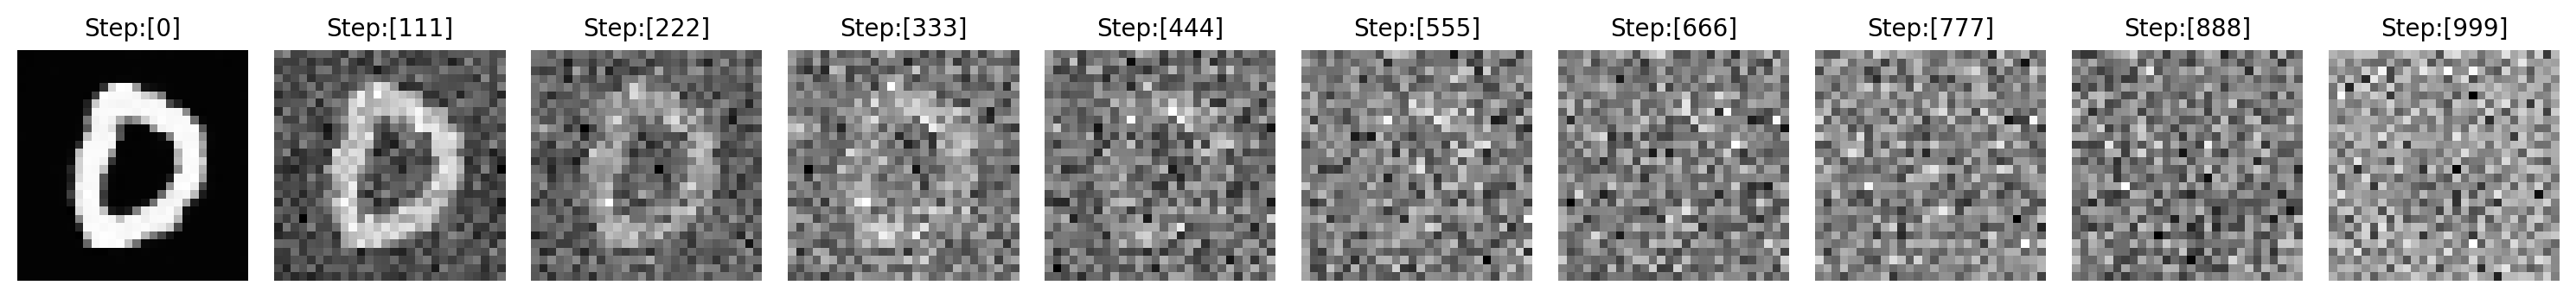

it:[   9000][90.0]% loss:[0.0632]
it:[   9999][100.0]% loss:[0.0711]


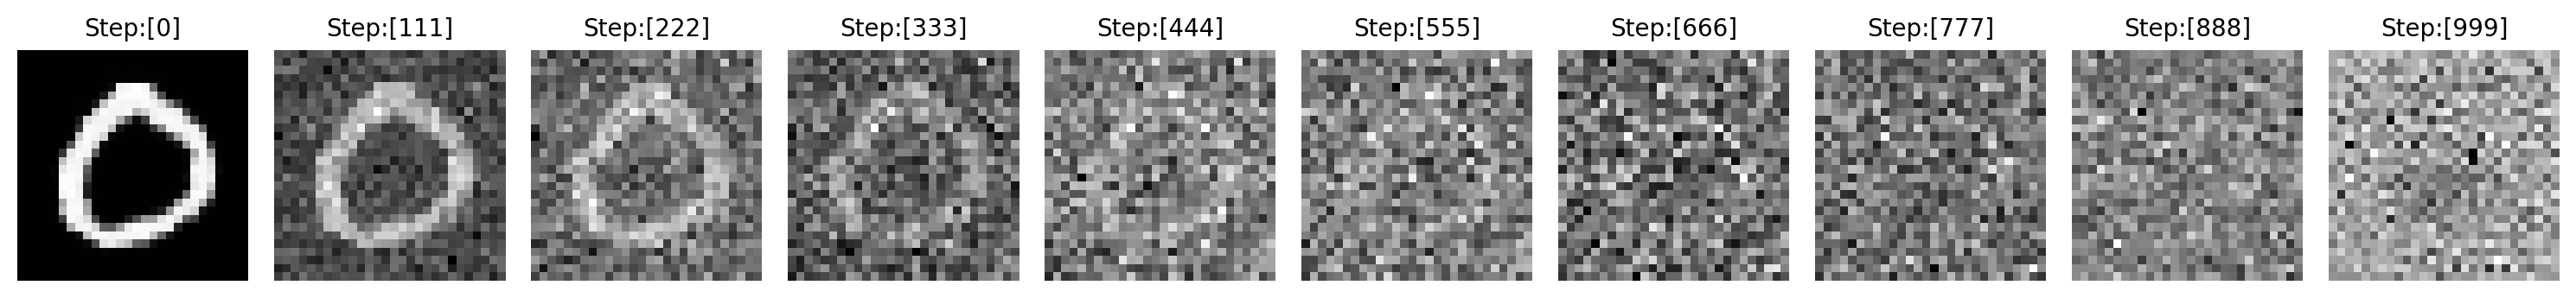

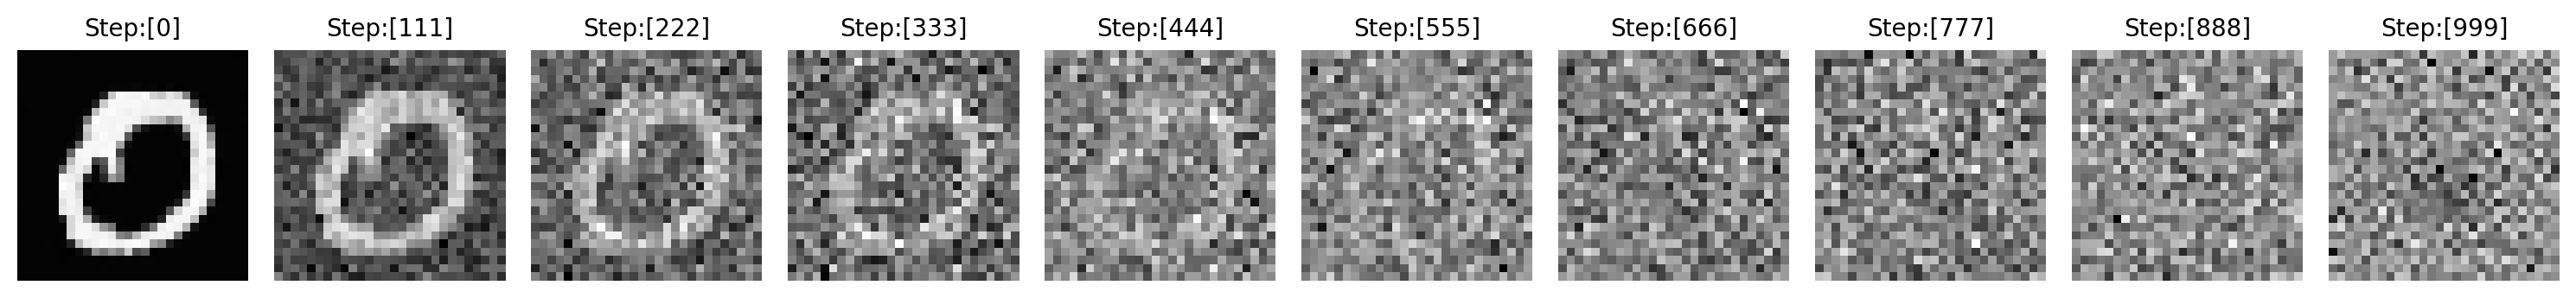

Done.


In [9]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 2,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_cond_dim           = embedding_dim * 2,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False, # no attention for images
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,1,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x W x H] => output:[B x C x W x H]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).to(th.int64) # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
    # Noise prediction
    paritial_embeddings = torch.index_select(embedding_vectors, dim=0, index=torch.tensor(idx, device=device))
    noise_pred,_ = model(x_t_batch,step_batch,paritial_embeddings) # [B x C x W x H]
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward(retain_graph=True)
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
        plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=2)

print ("Done.")

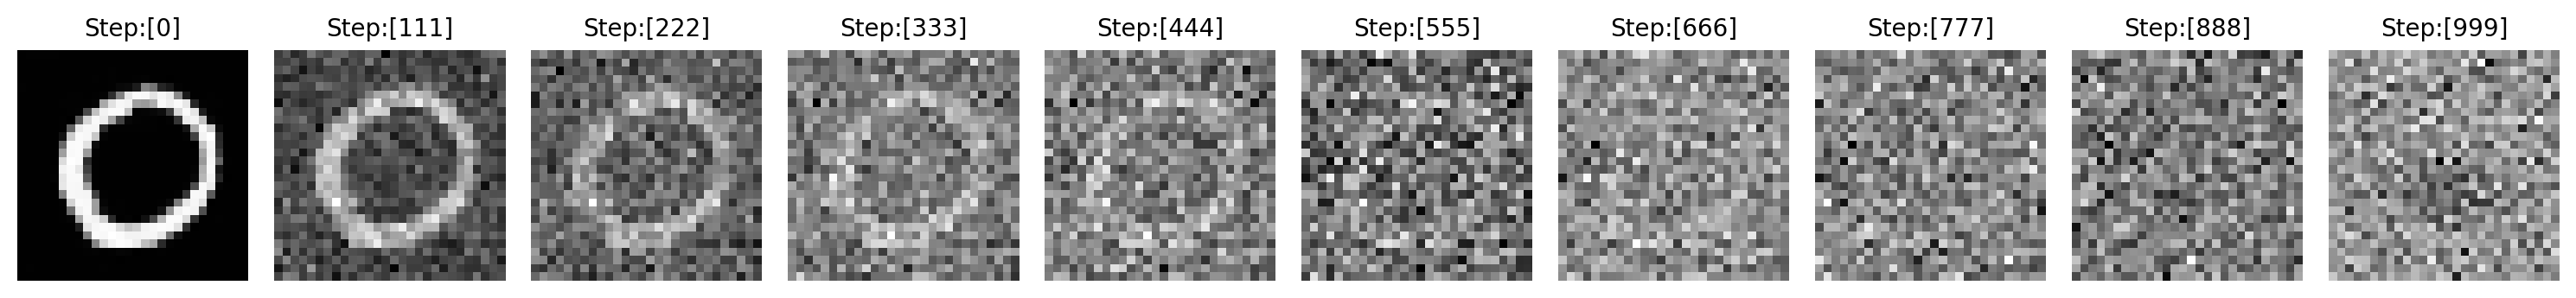

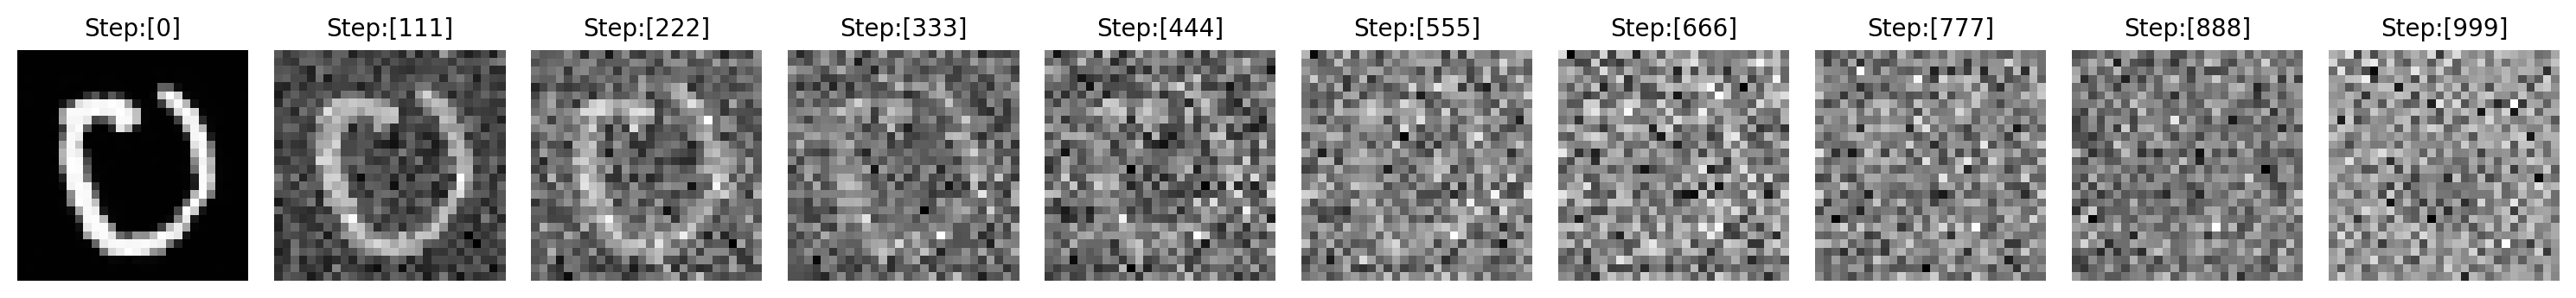

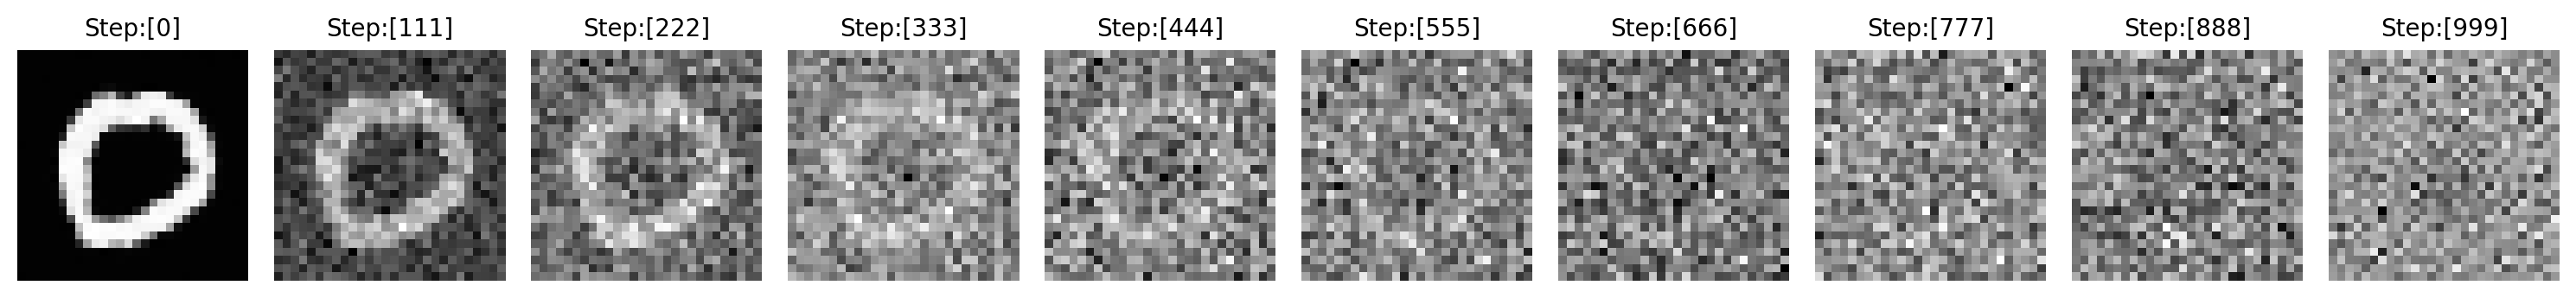

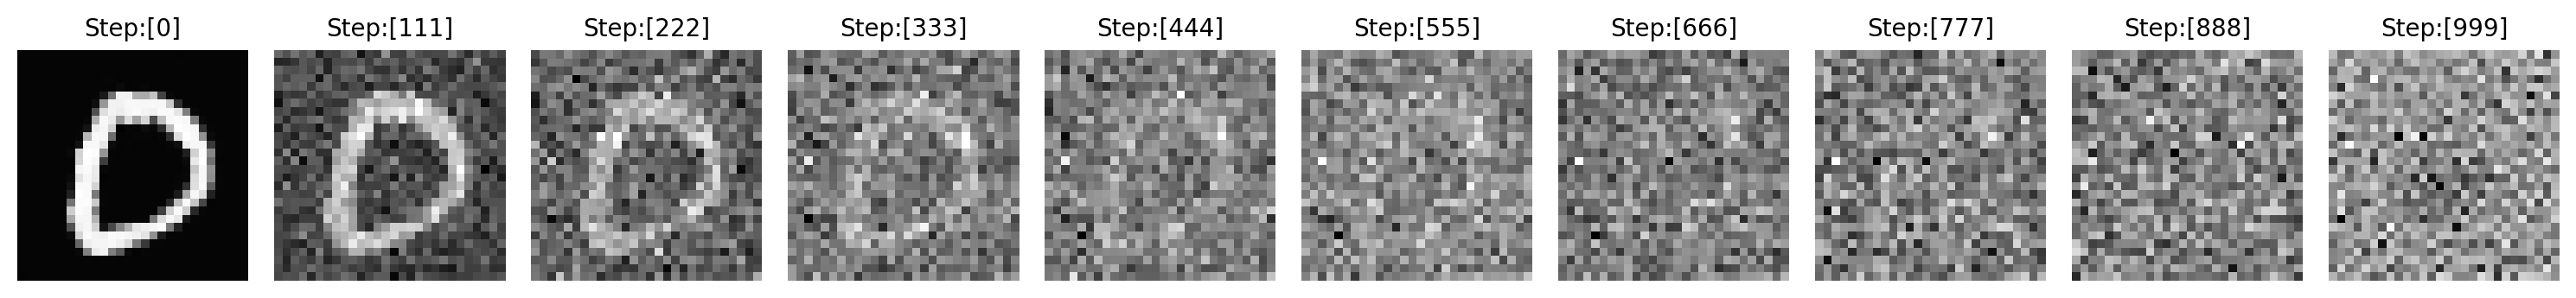

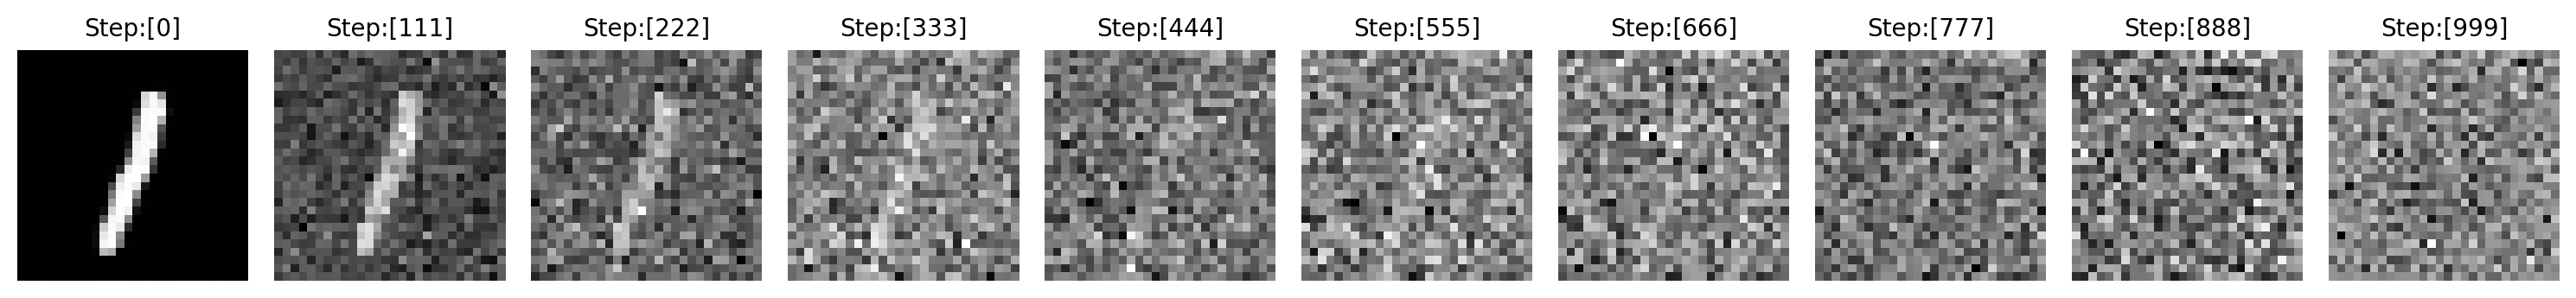

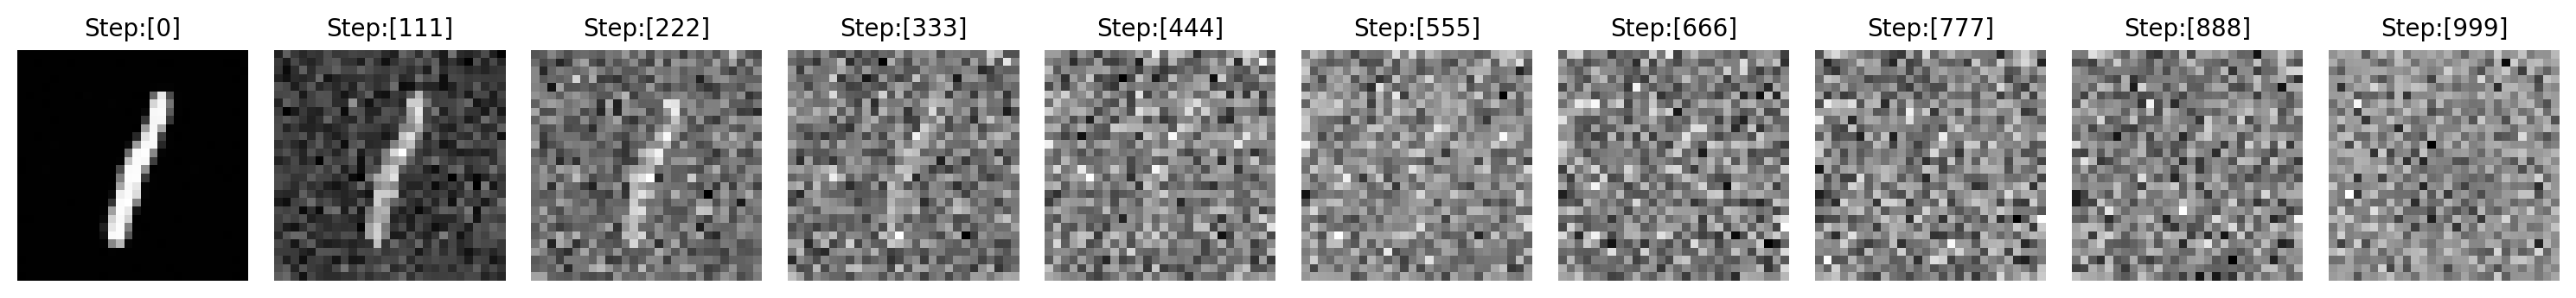

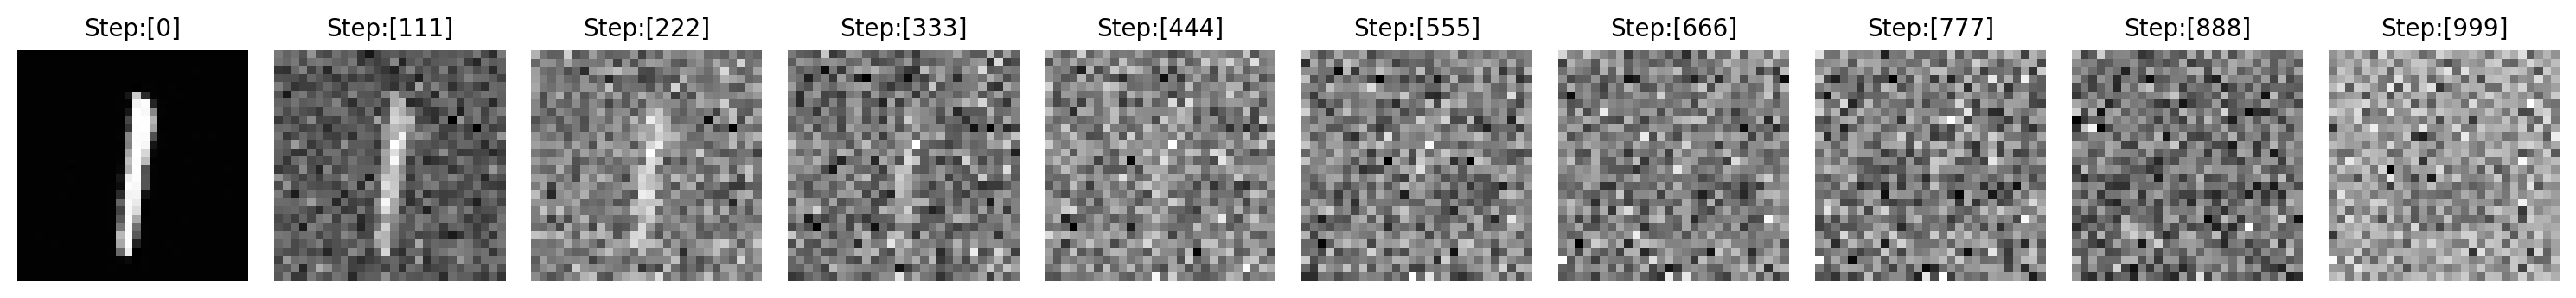

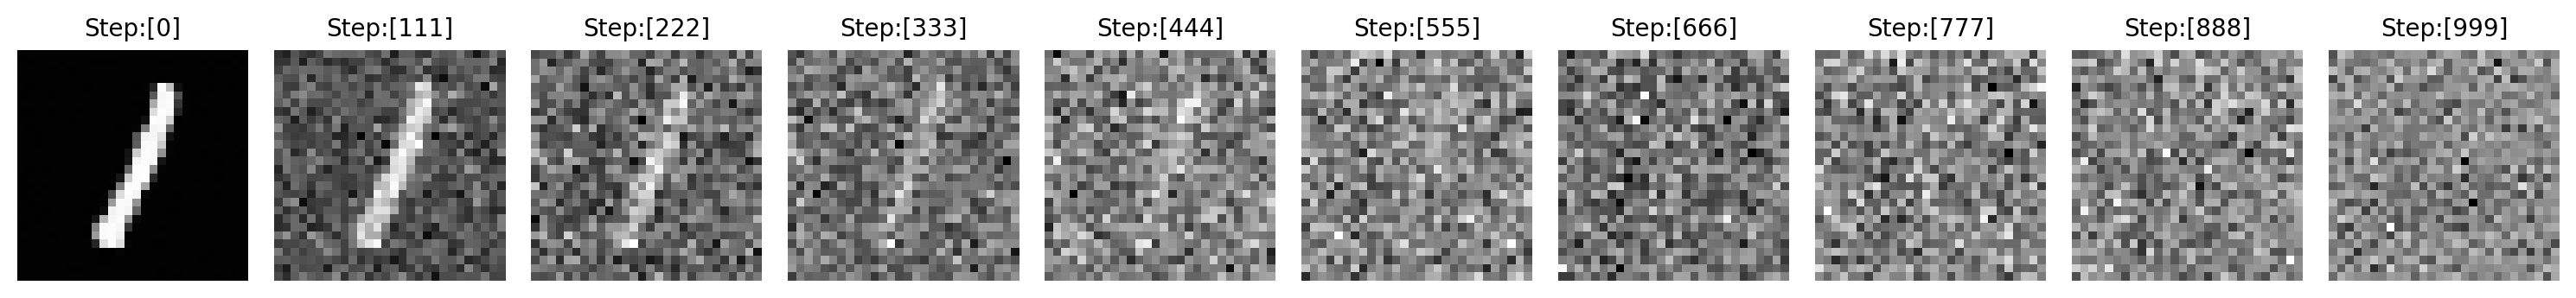

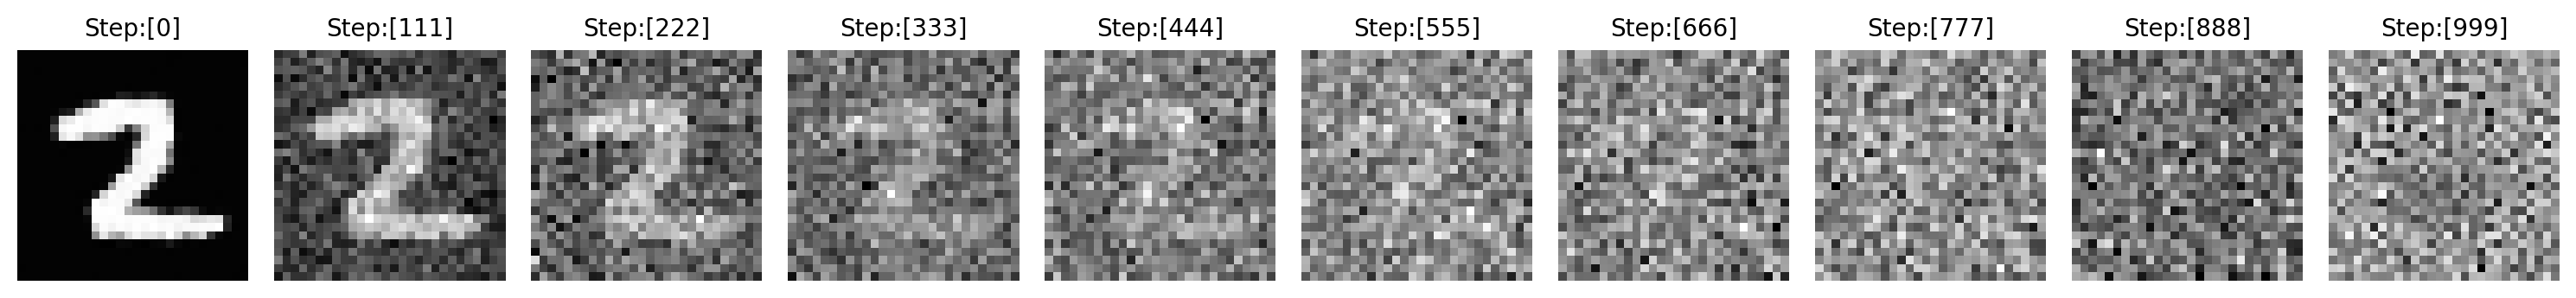

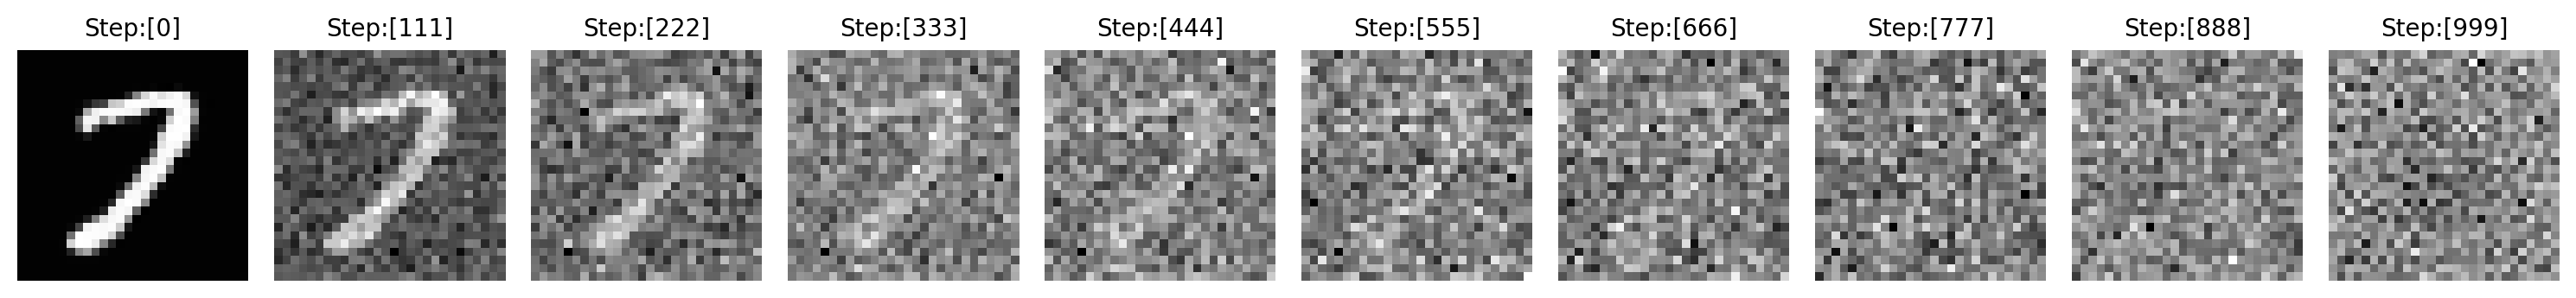

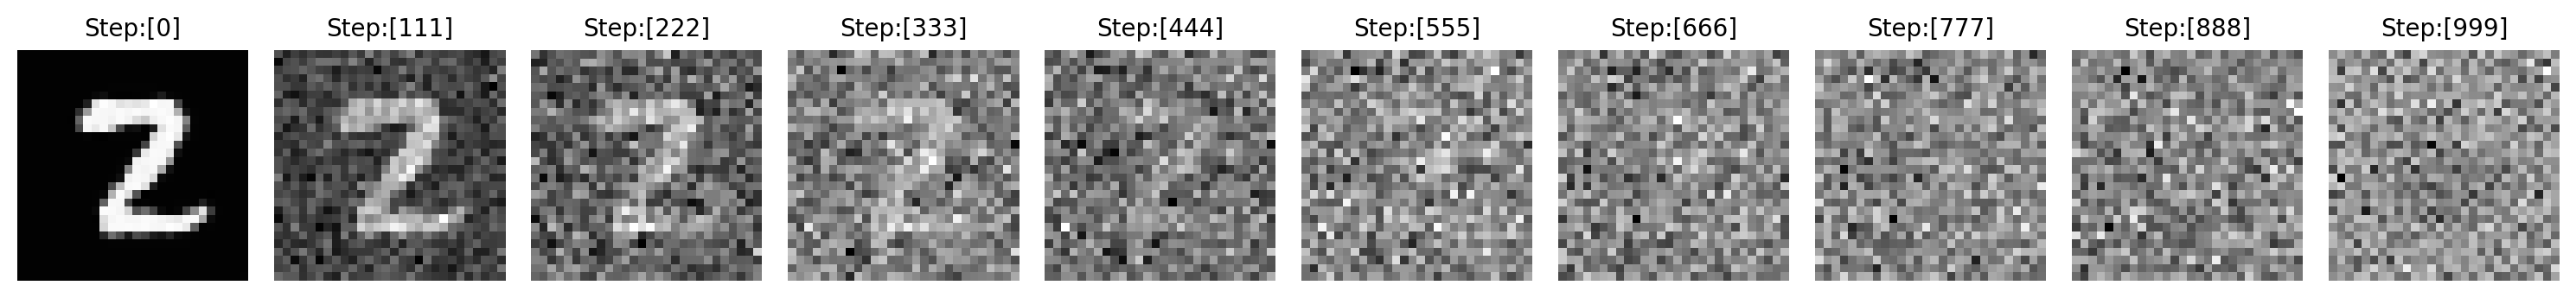

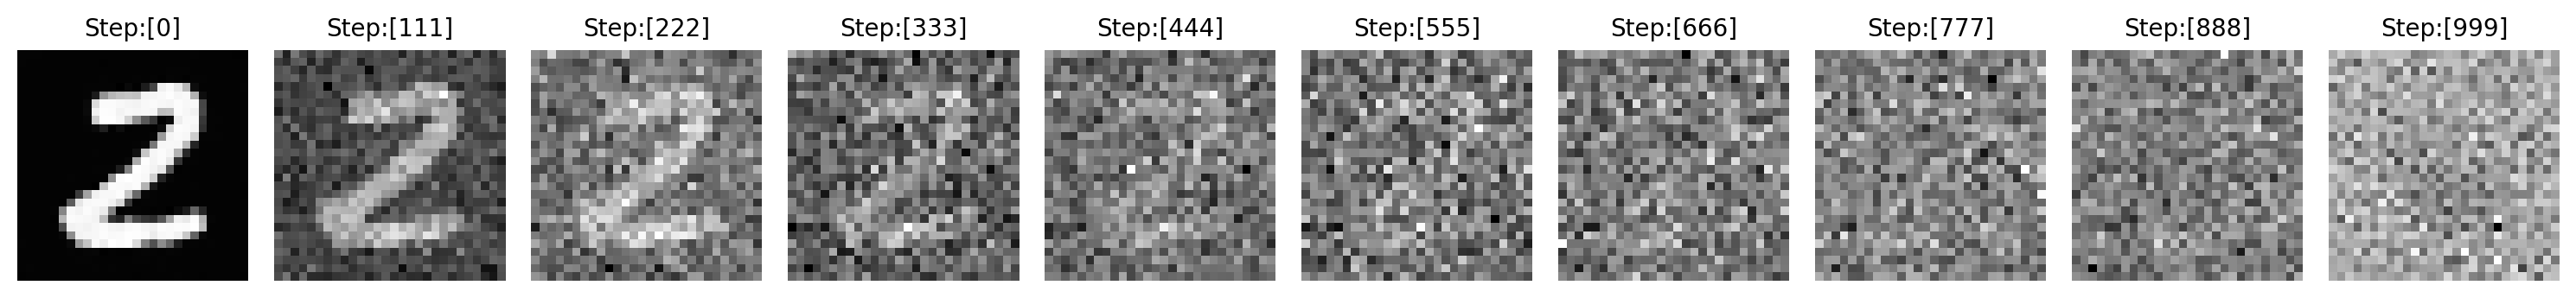

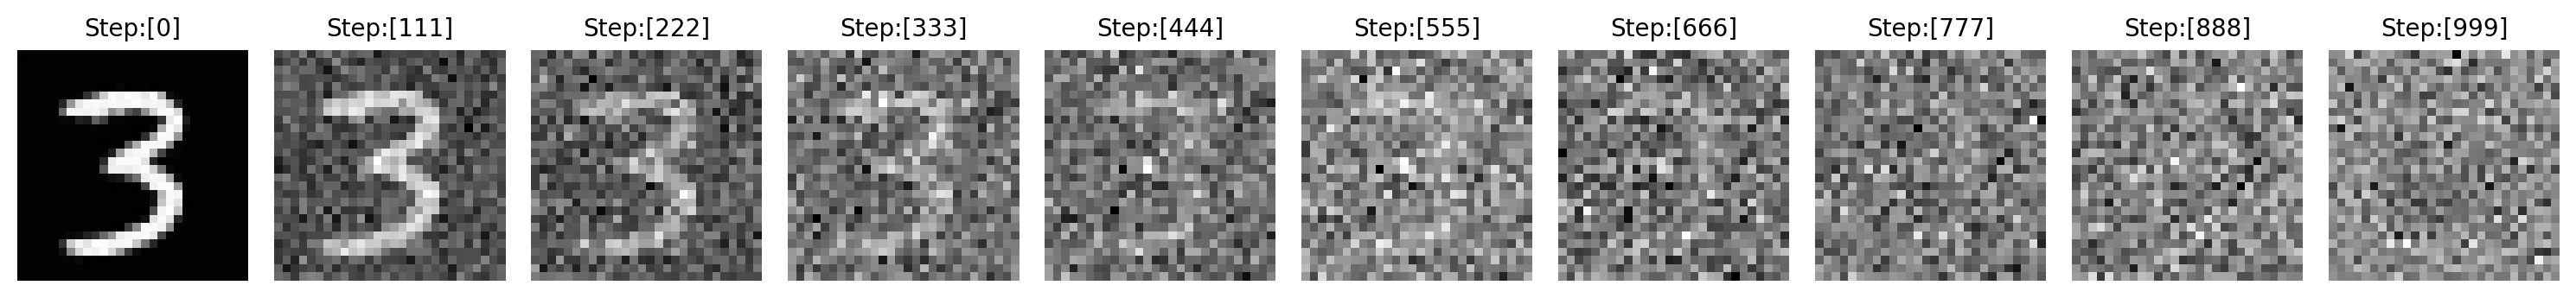

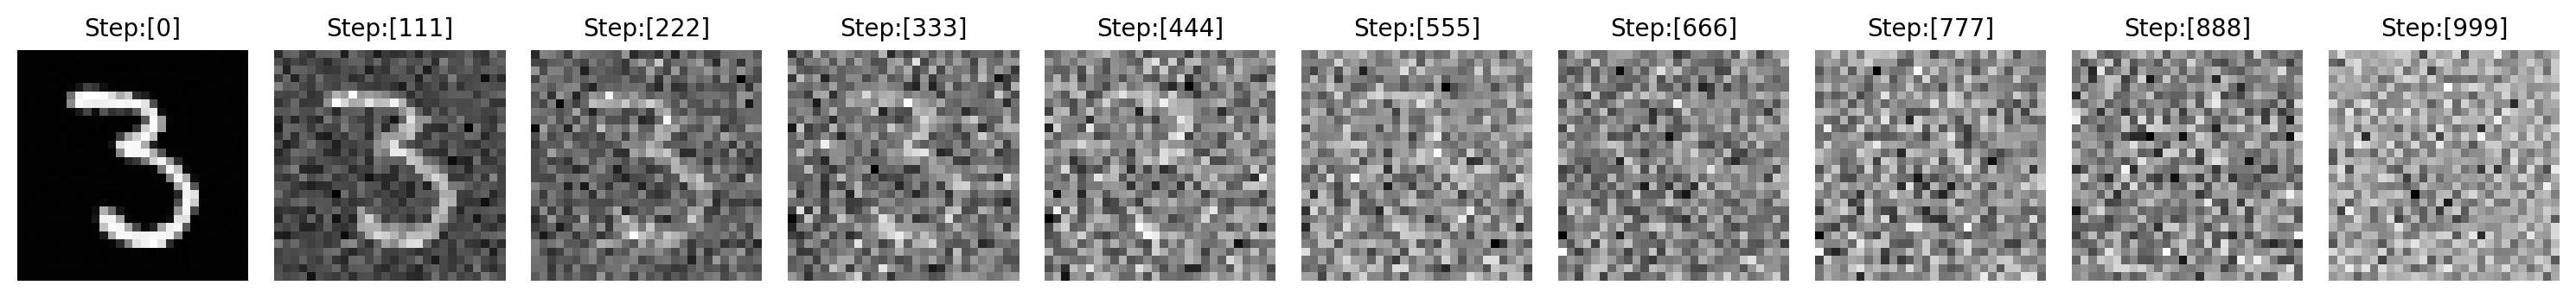

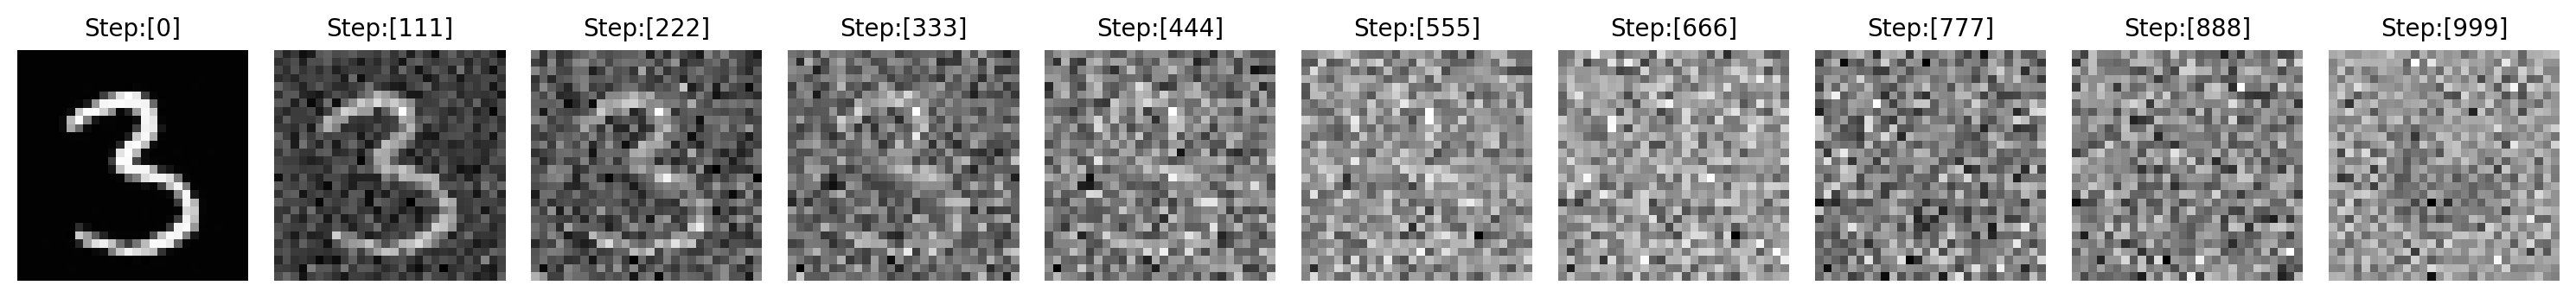

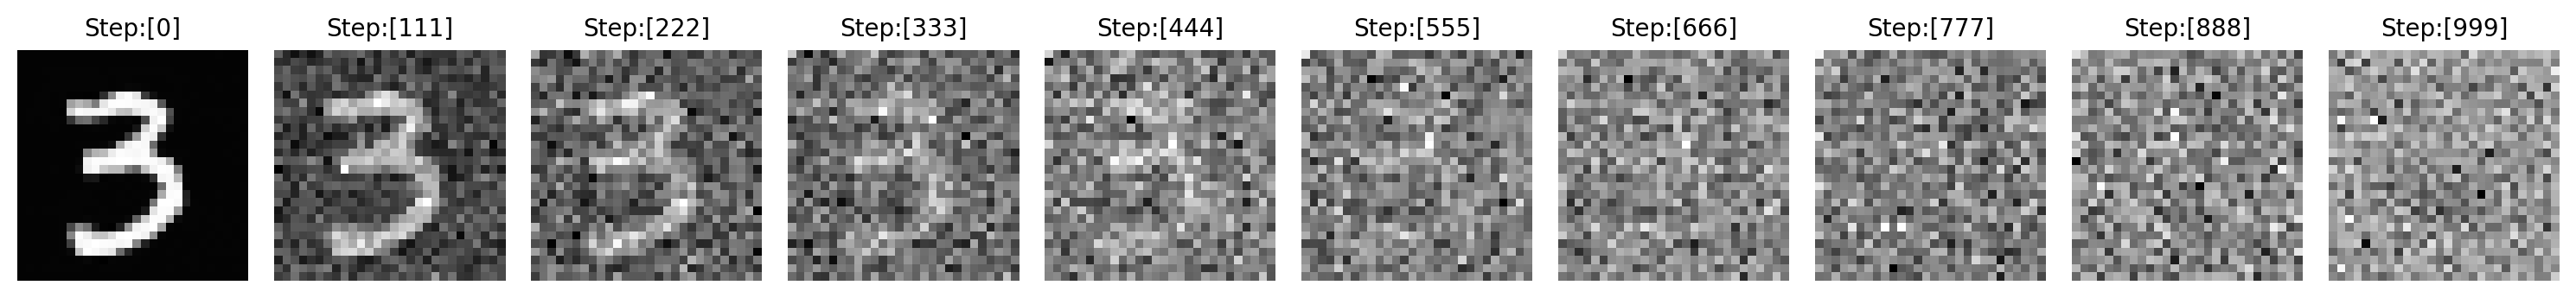

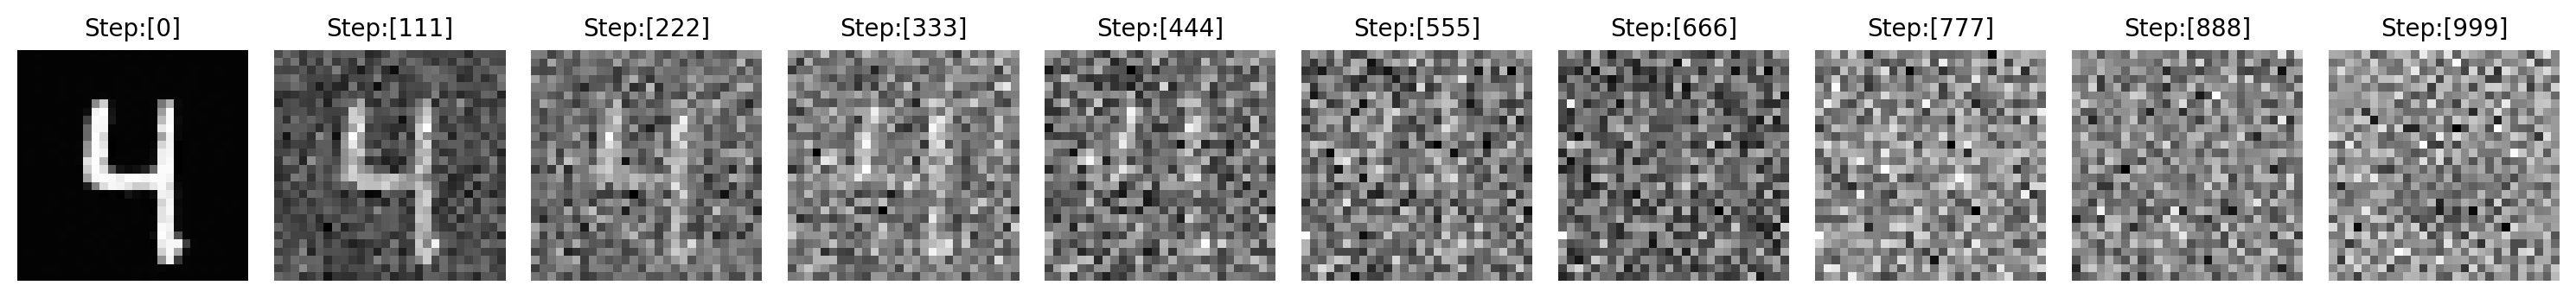

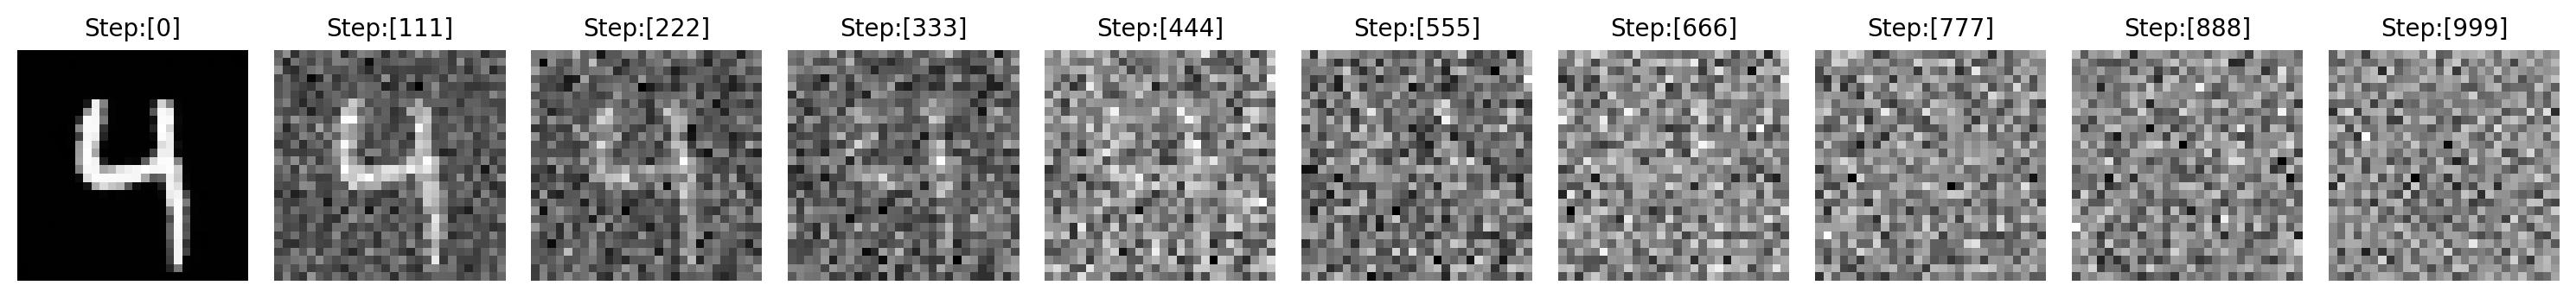

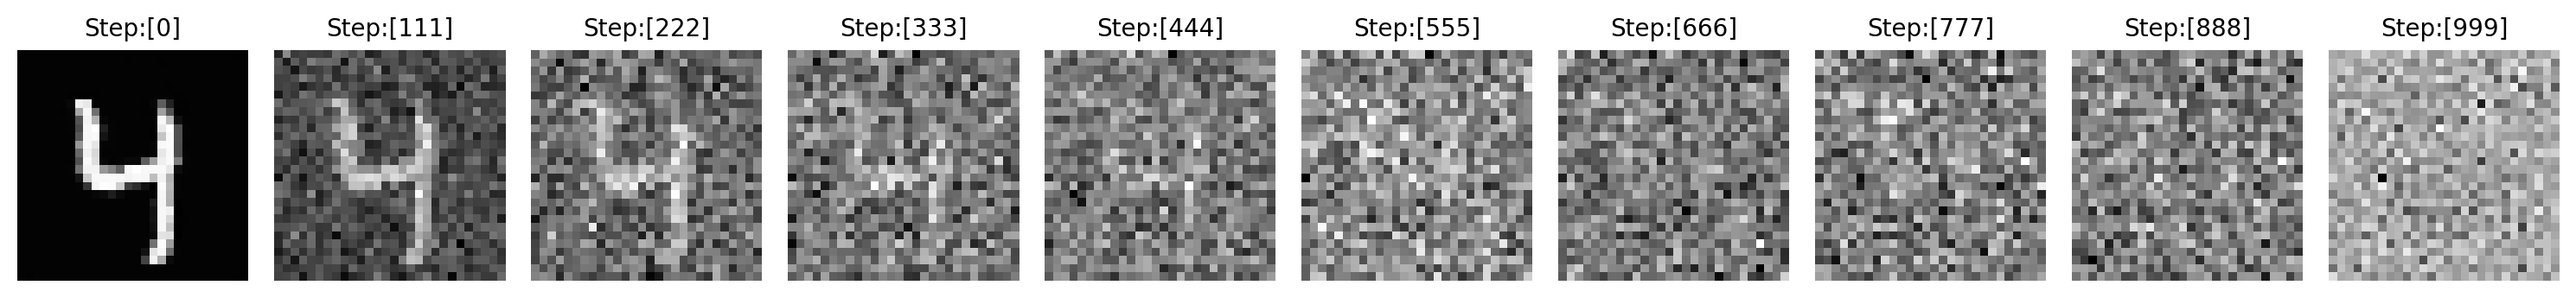

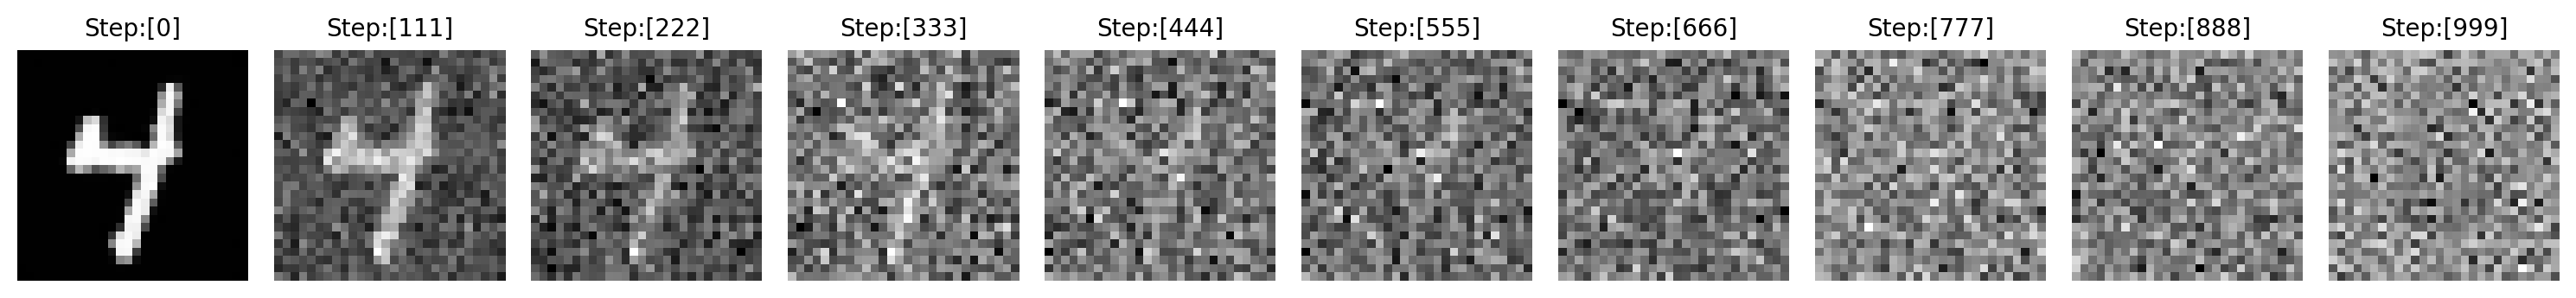

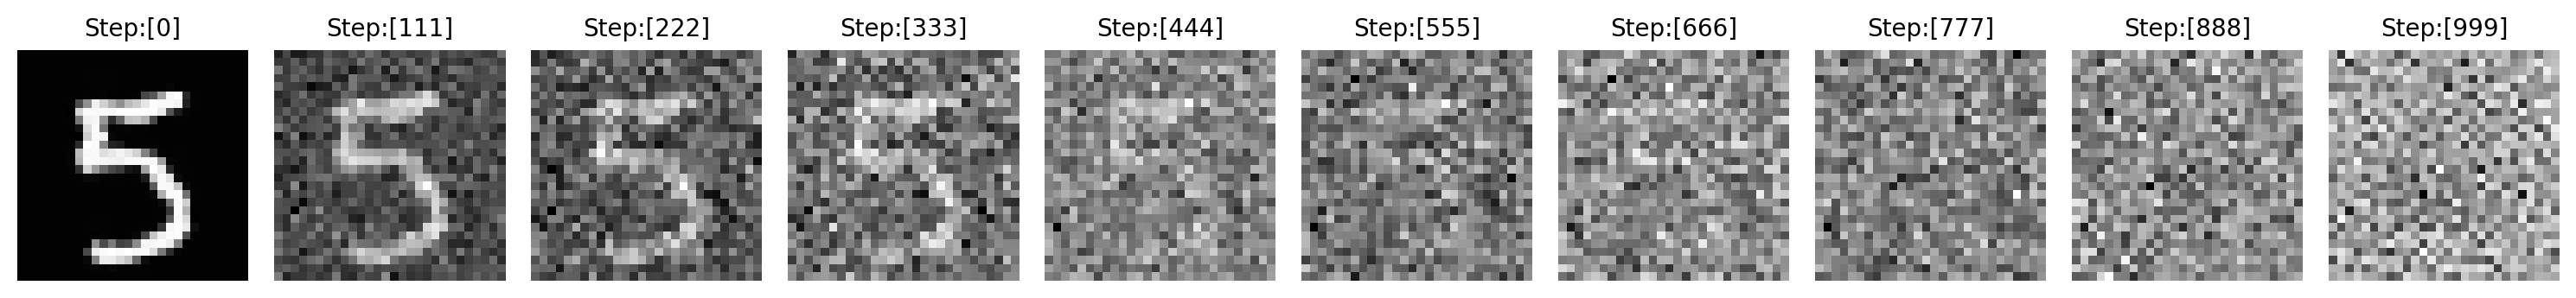

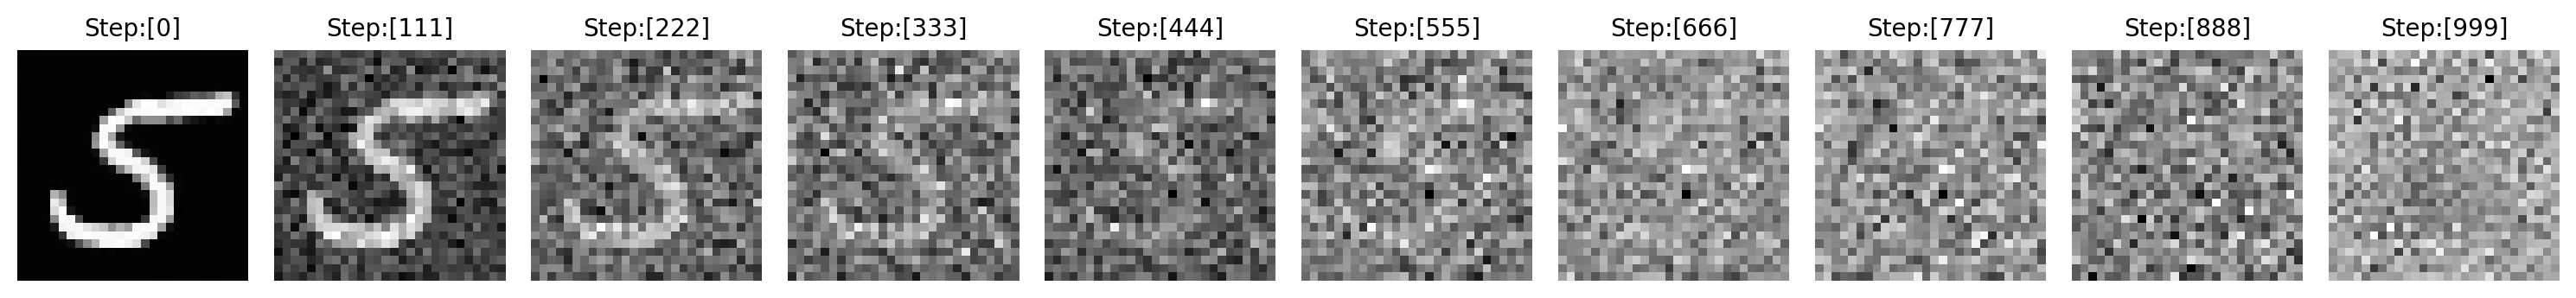

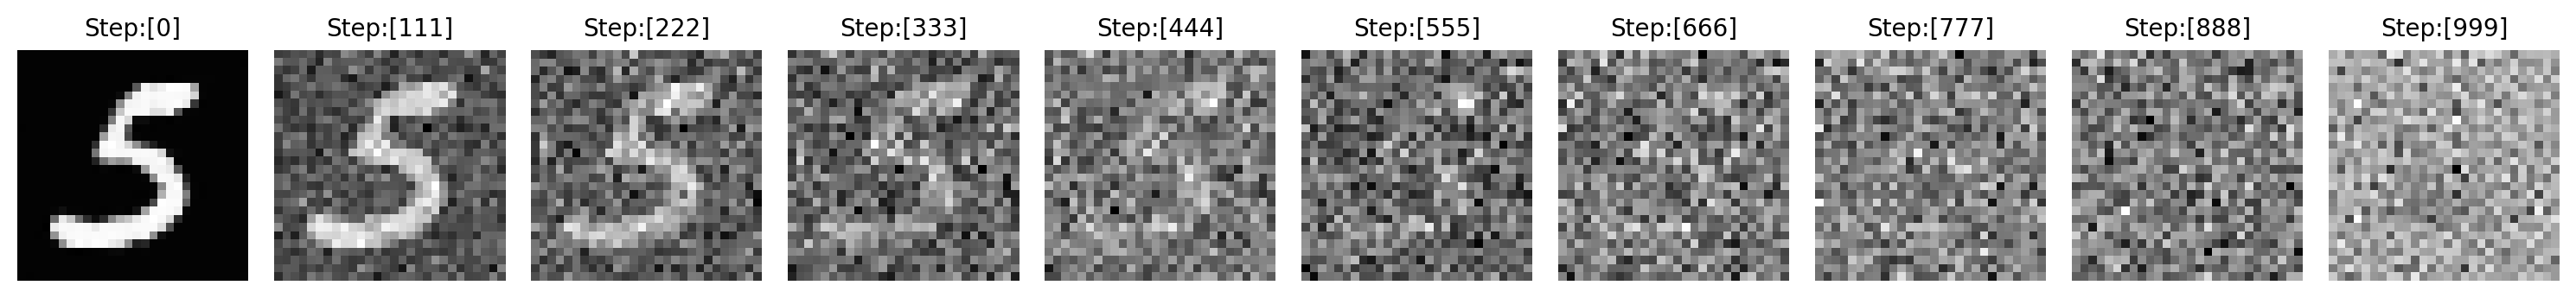

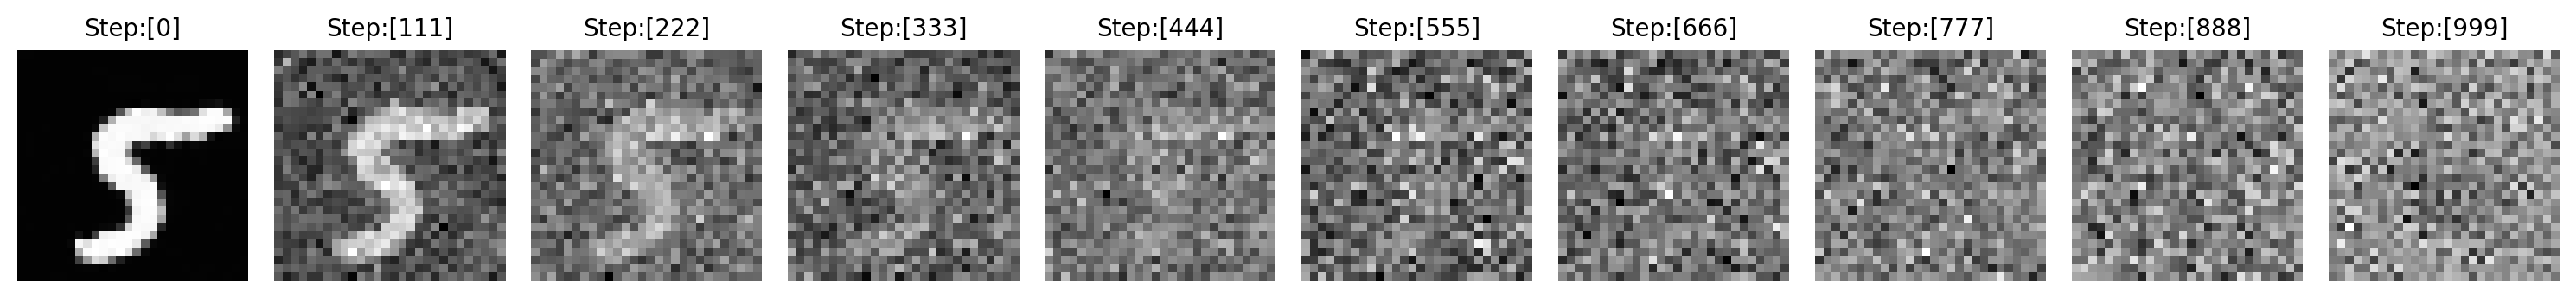

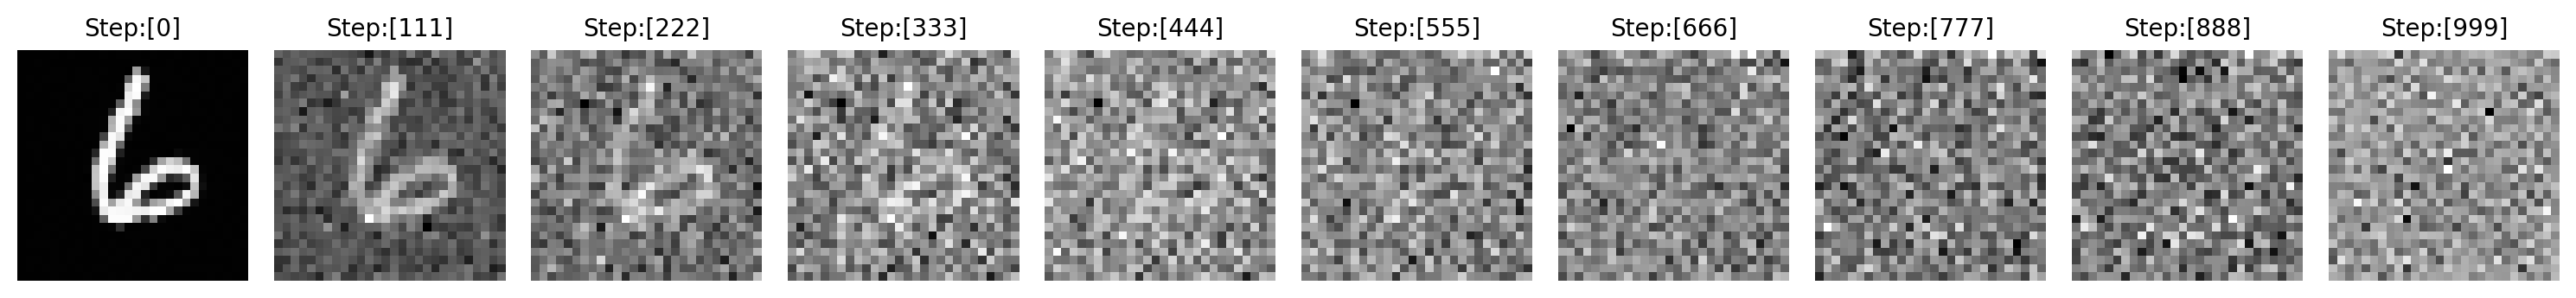

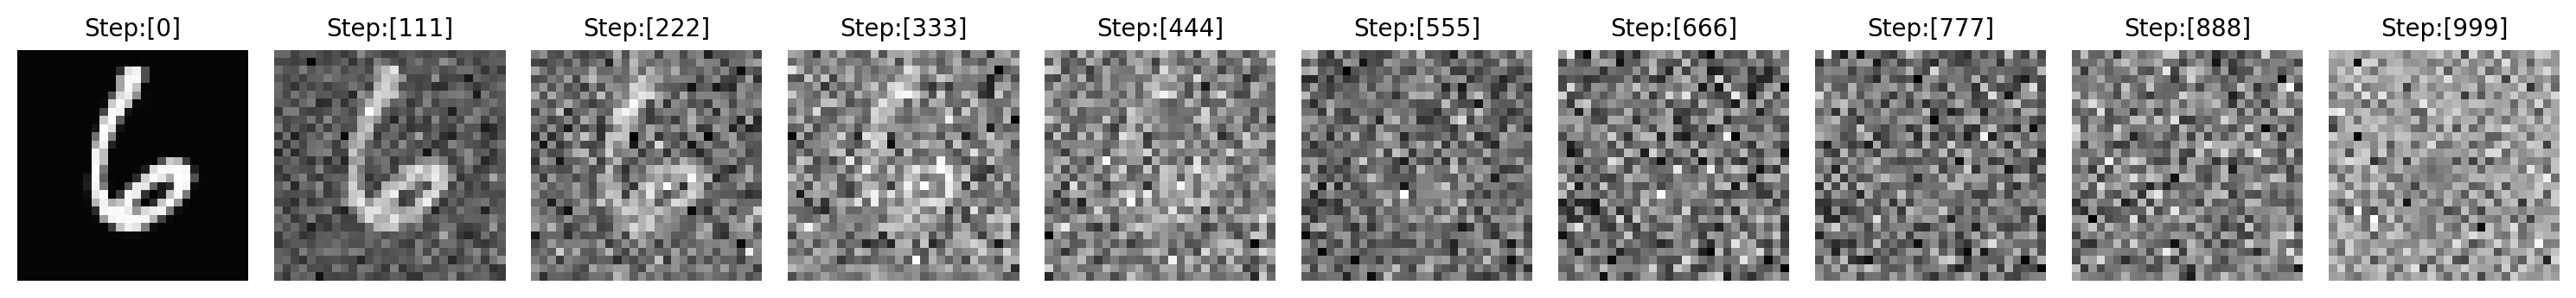

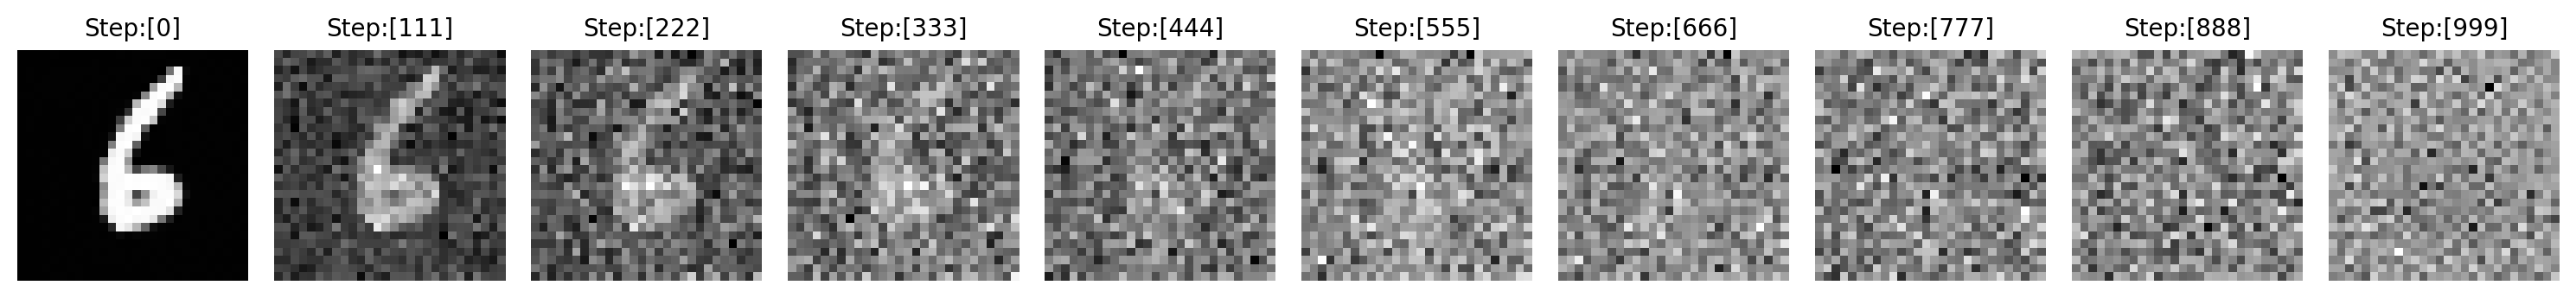

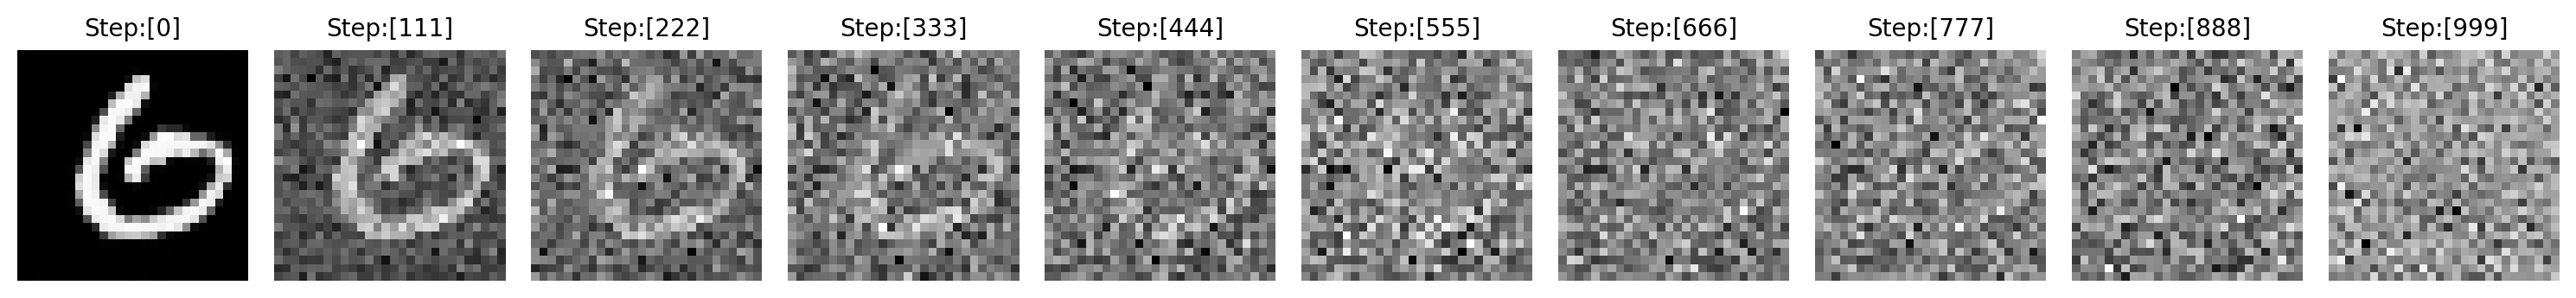

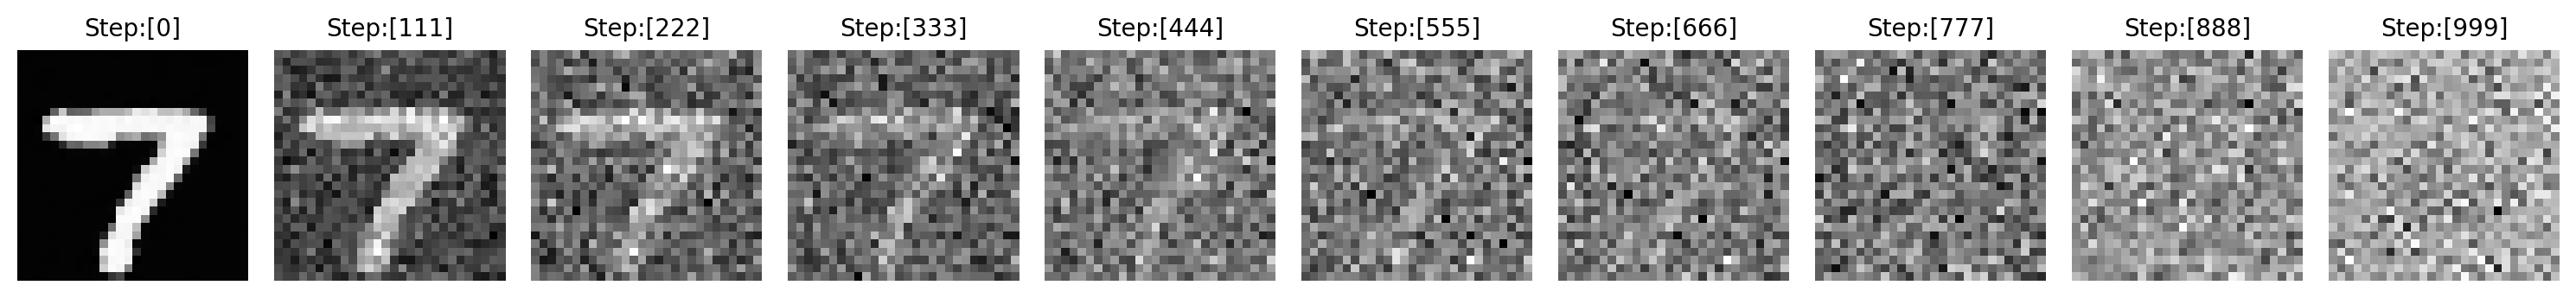

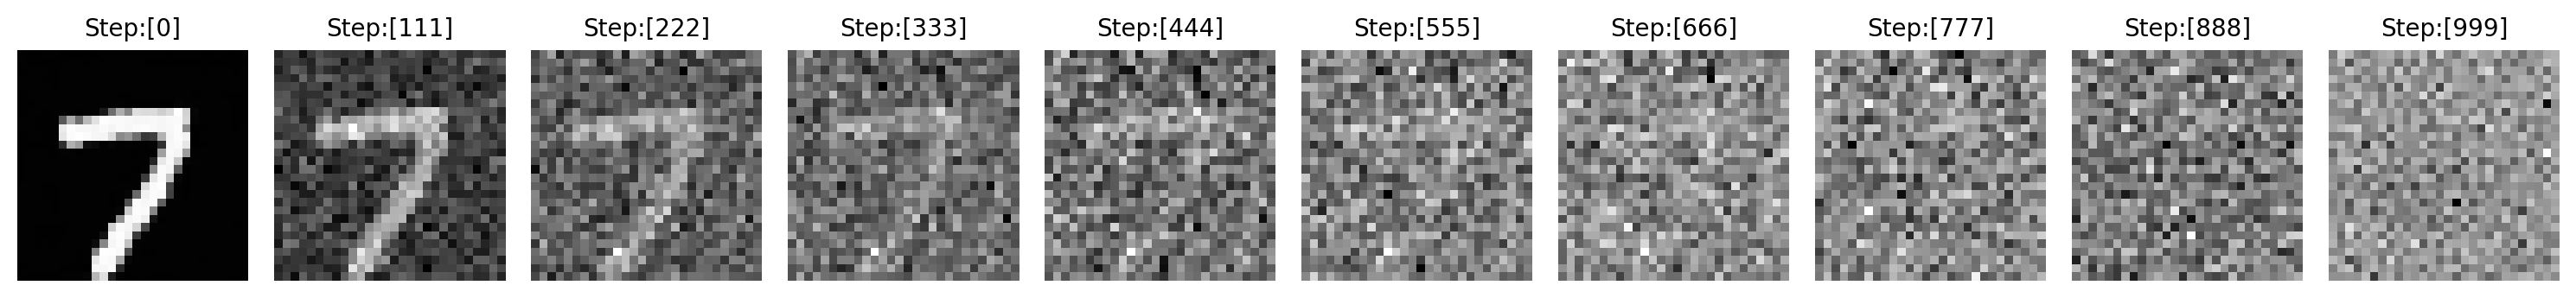

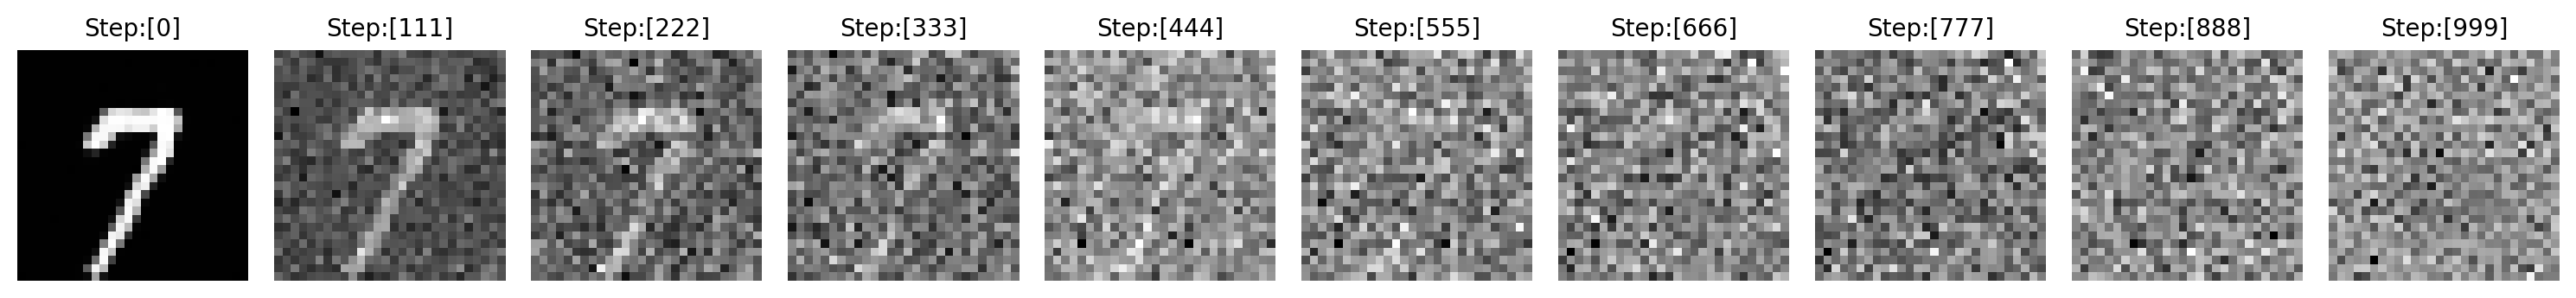

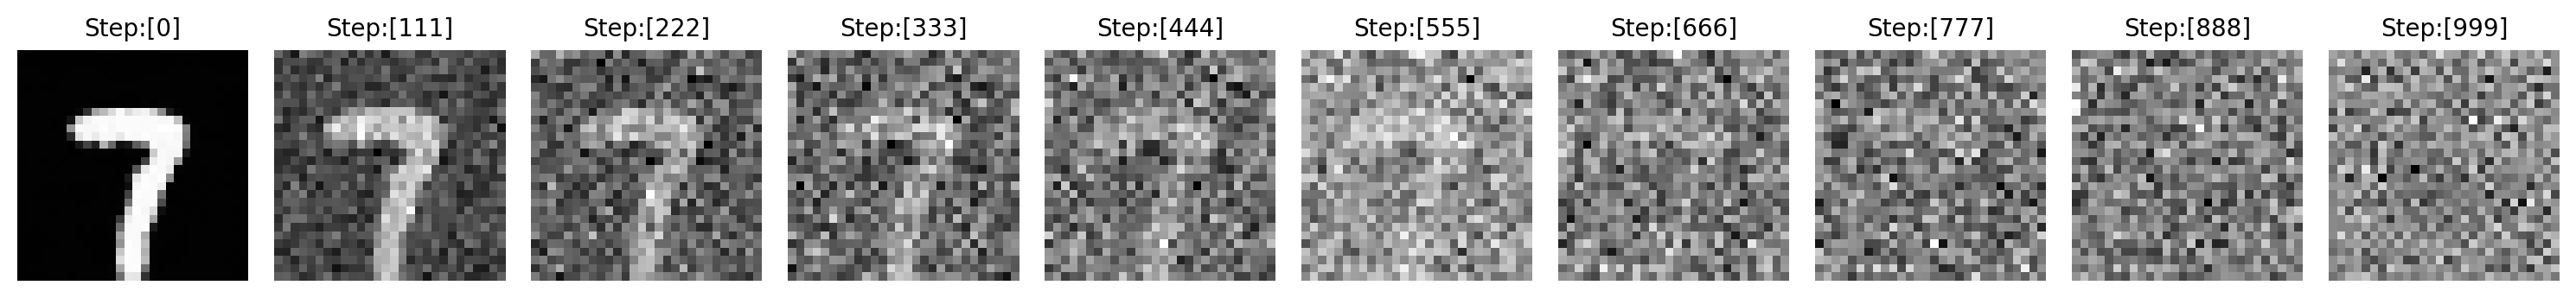

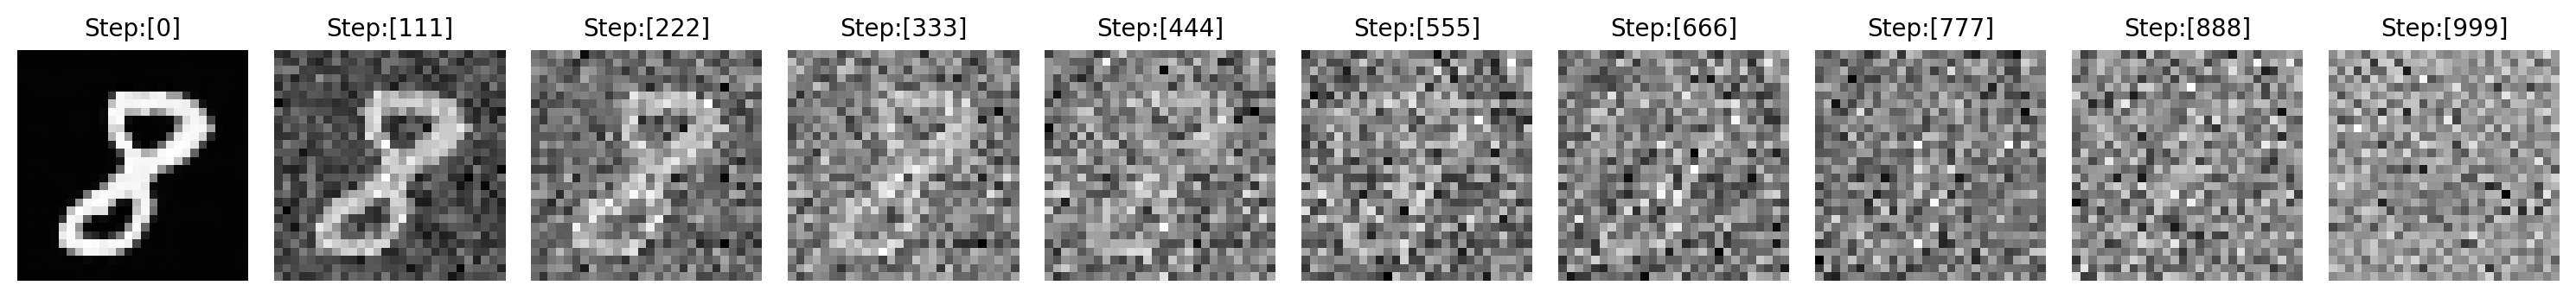

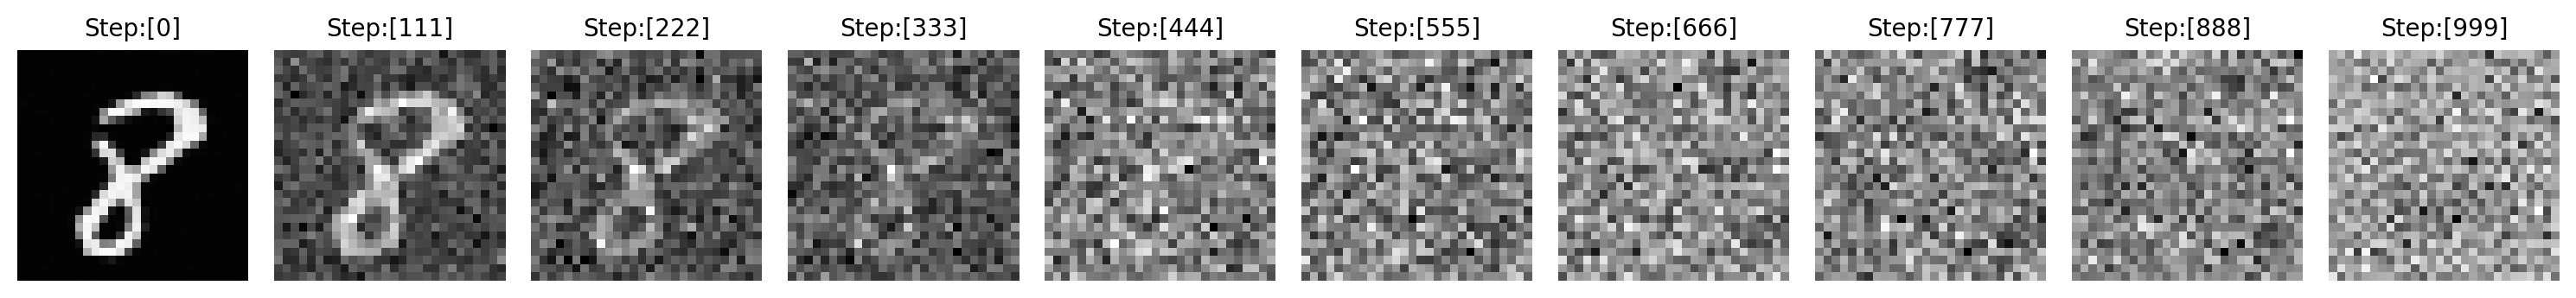

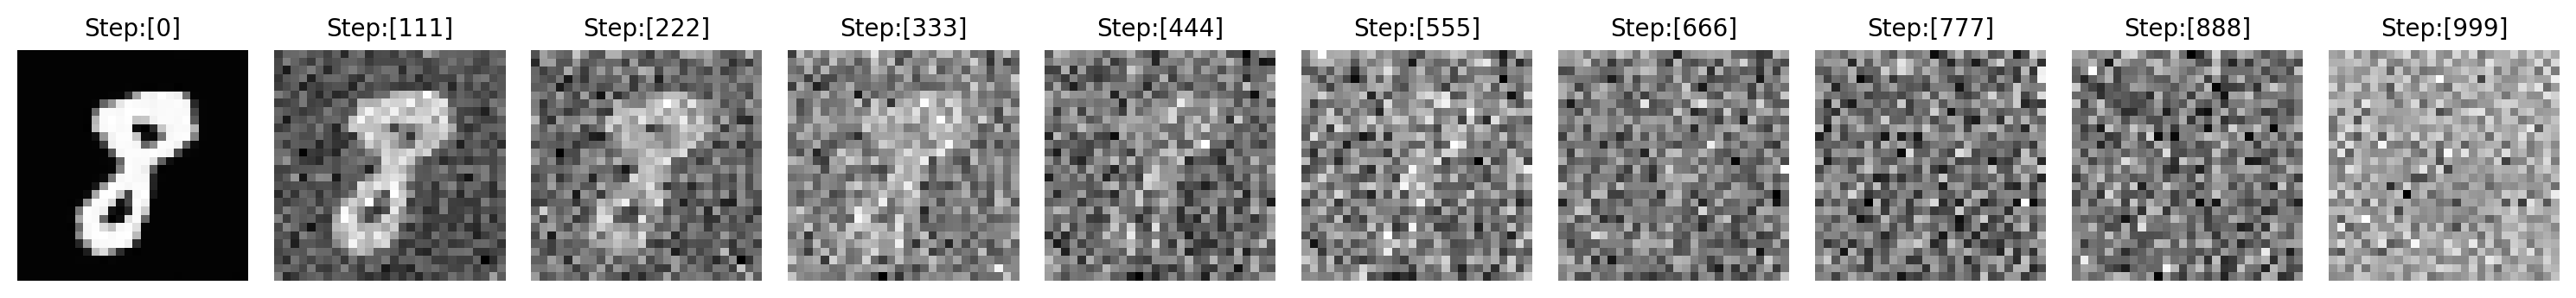

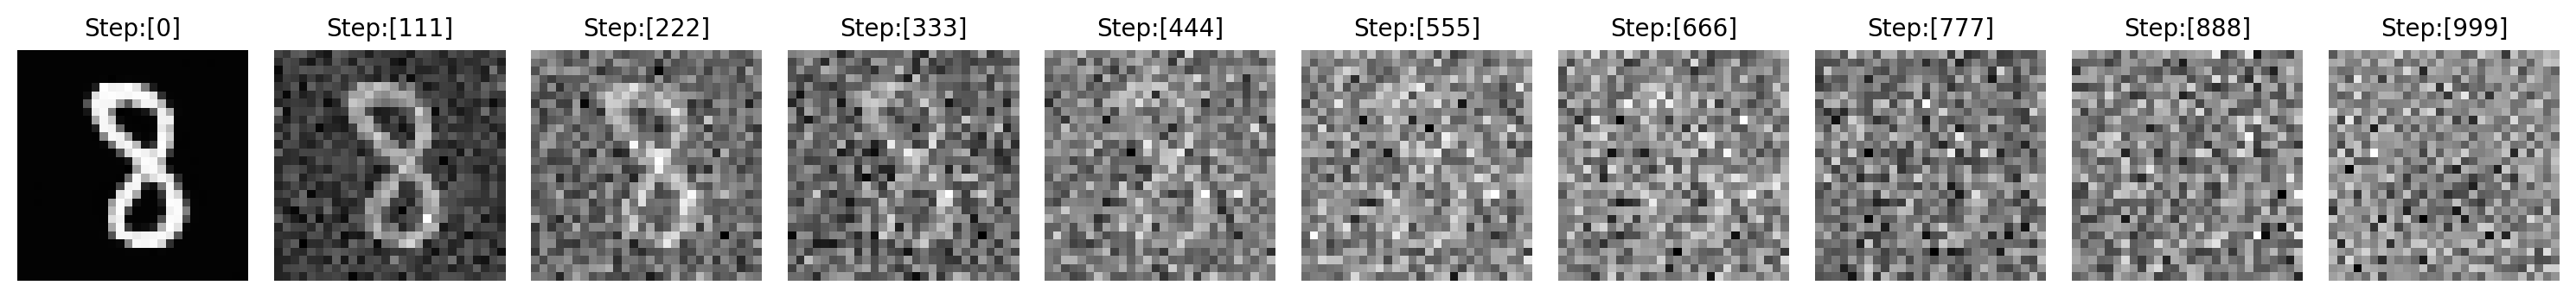

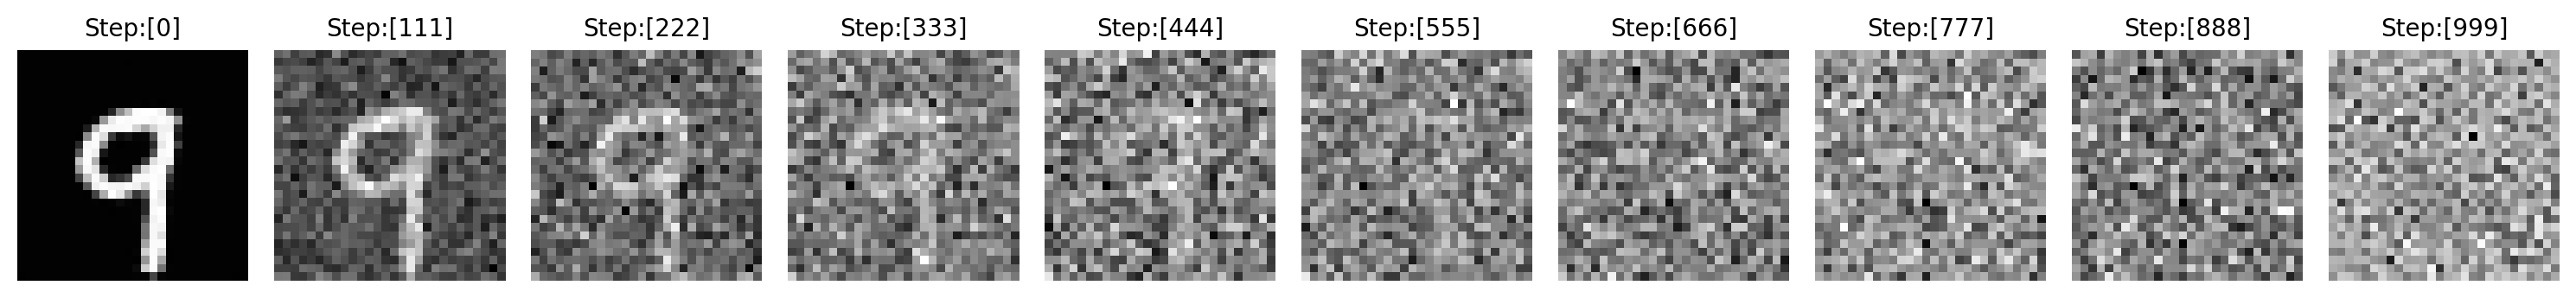

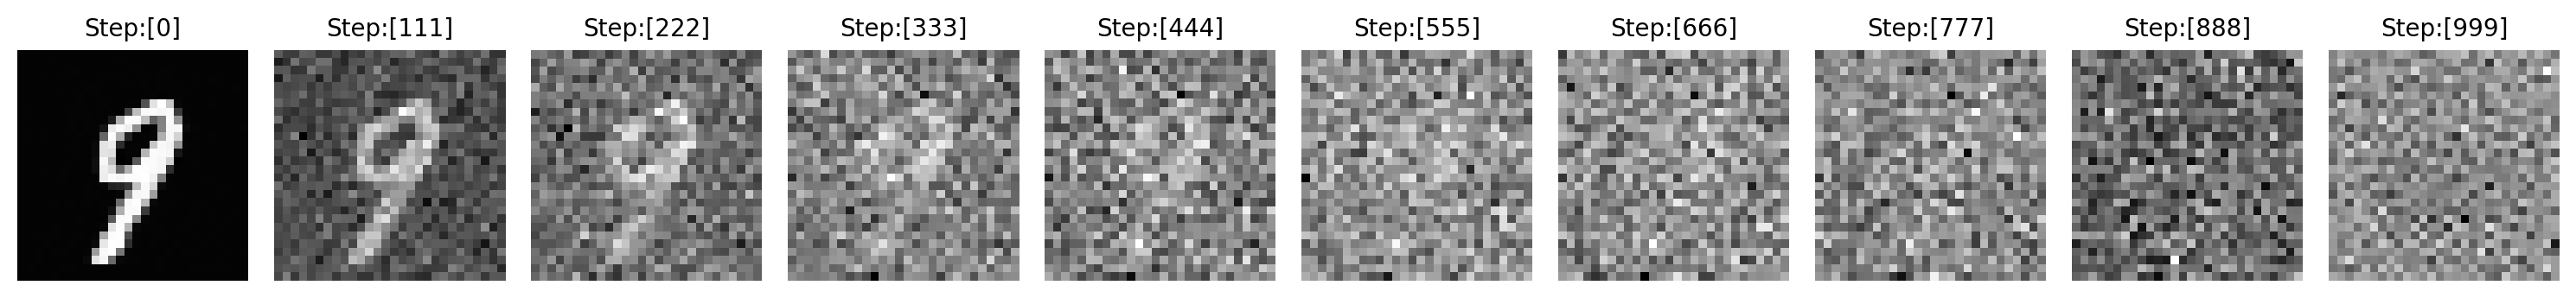

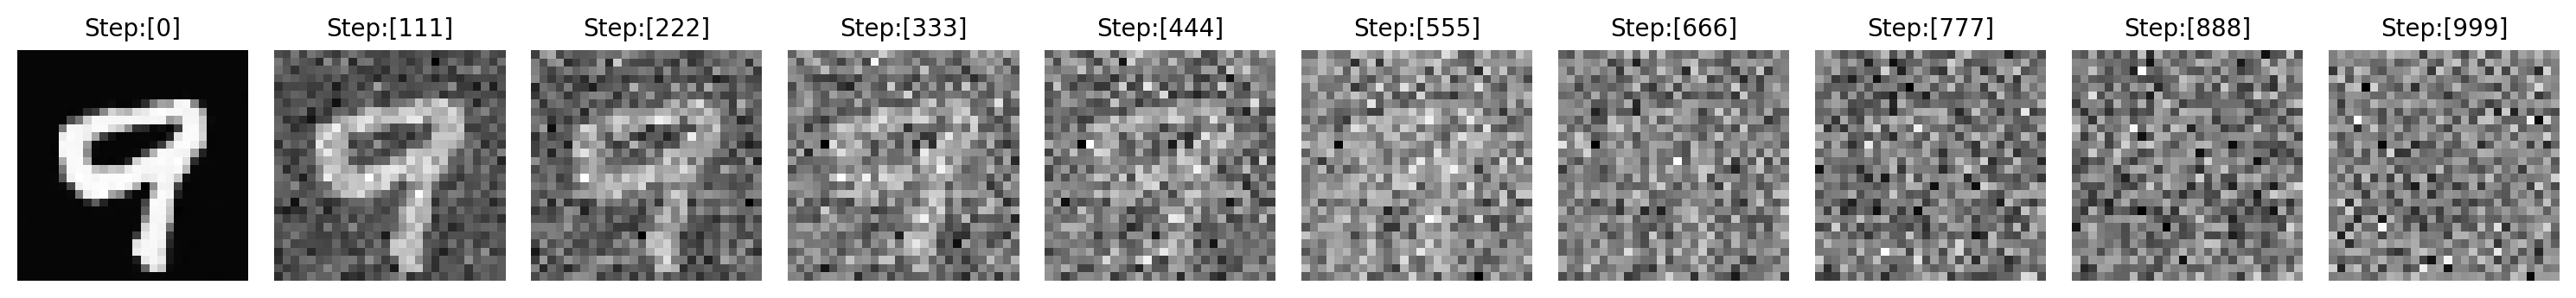

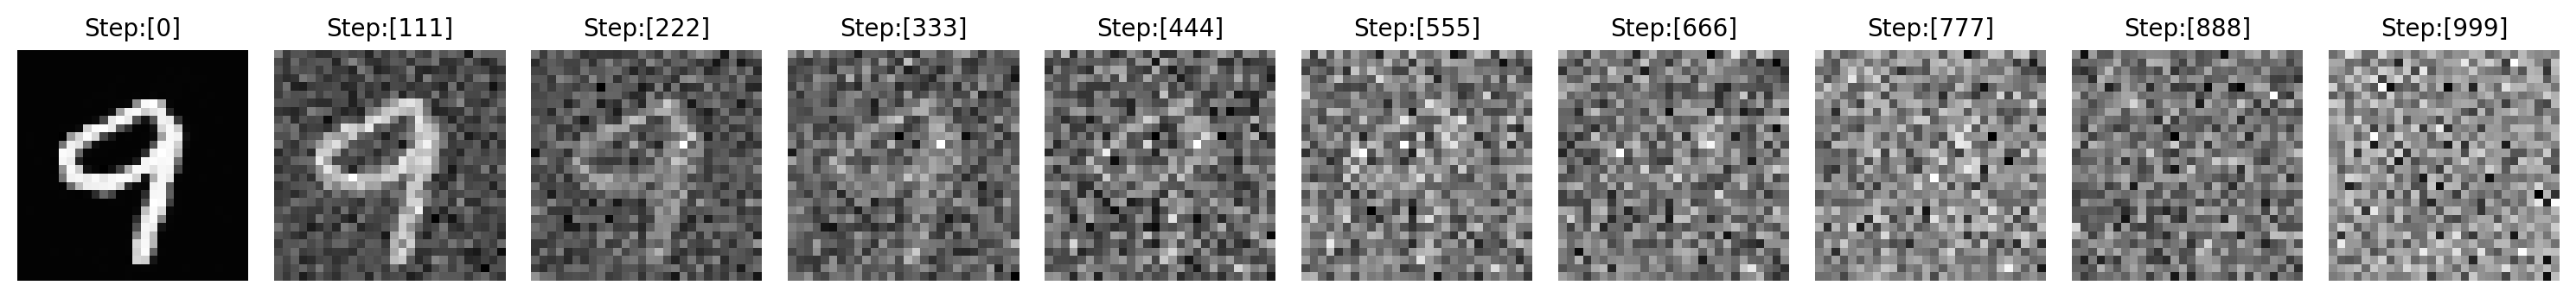

In [10]:
# n_sample = 10
# step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
# x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
# plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)


n_sample = 4
for number in range(0,10):
    test_embedding_vector = get_conditioning_embedding(number,device)
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
    plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

In [12]:
import torch
from datetime import datetime

# 현재 날짜와 시간 가져오기
now = datetime.now()

# "YYYYMMDD_HHMMSS" 형식으로 포맷팅
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# 모델과 옵티마이저 상태를 저장할 경로
save_path = f'result/MNIST_conditioning_circle_number_{formatted_now}.pth'

# 모델 및 옵티마이저 상태를 딕셔너리로 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optm.state_dict(),
    'scheduler_state_dict': schd.state_dict(),
    'epoch': it,
    'loss': loss.item()
}, save_path)

print(f'Model saved to {save_path}')

Model saved to result/MNIST_conditioning_circle_number_20240616_171519.pth


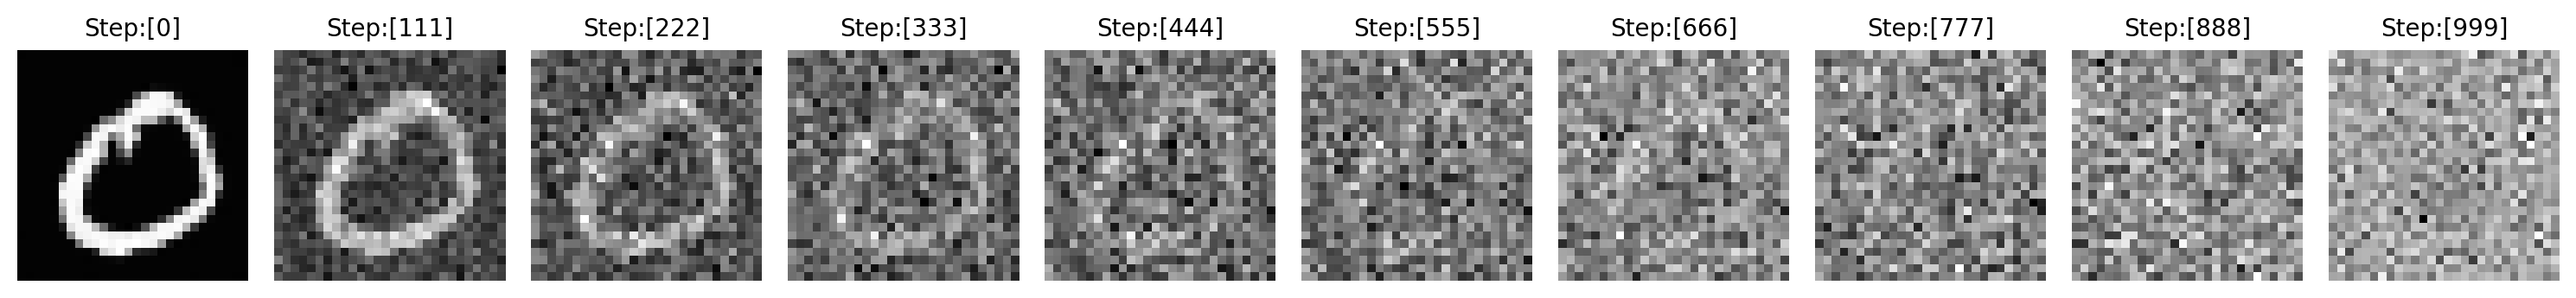

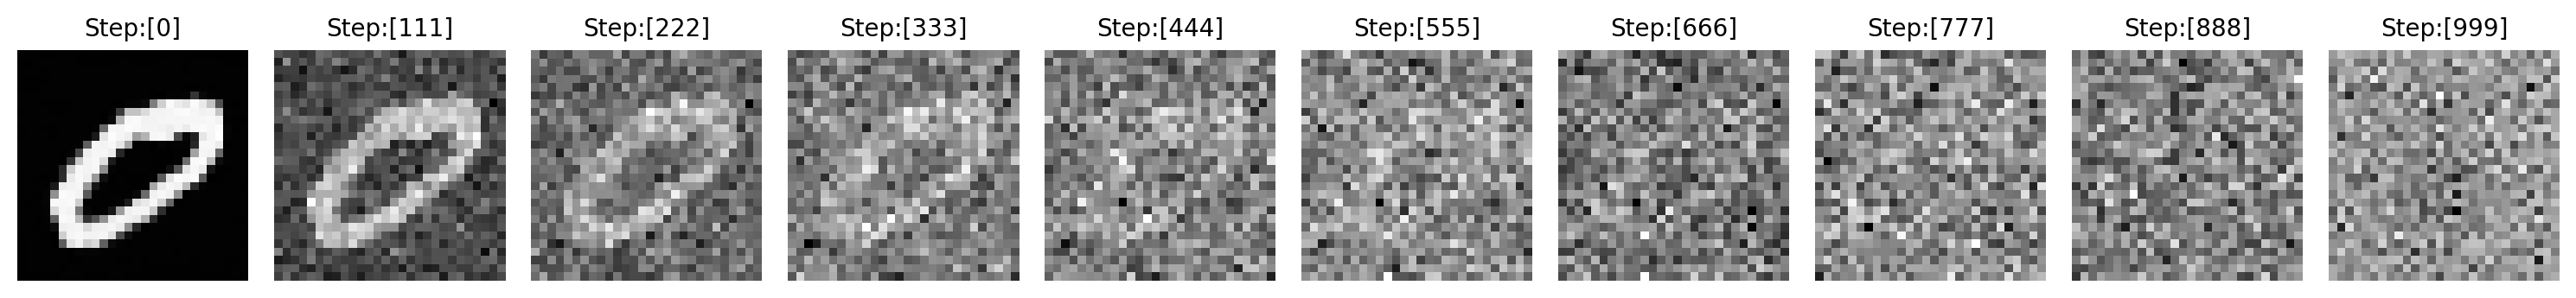

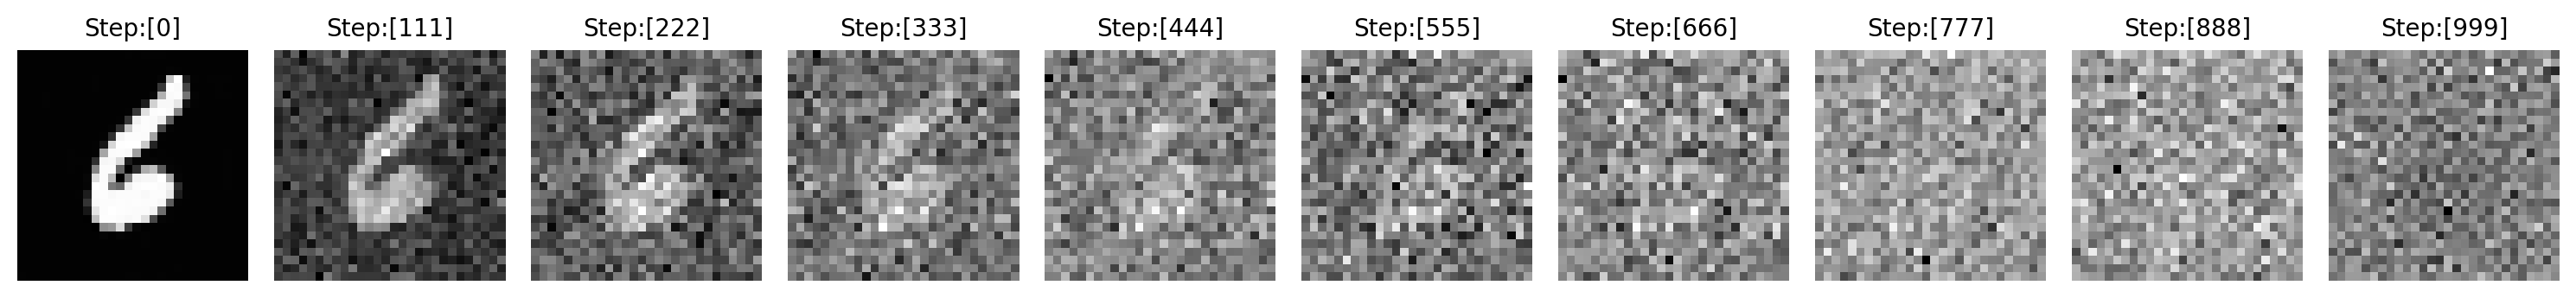

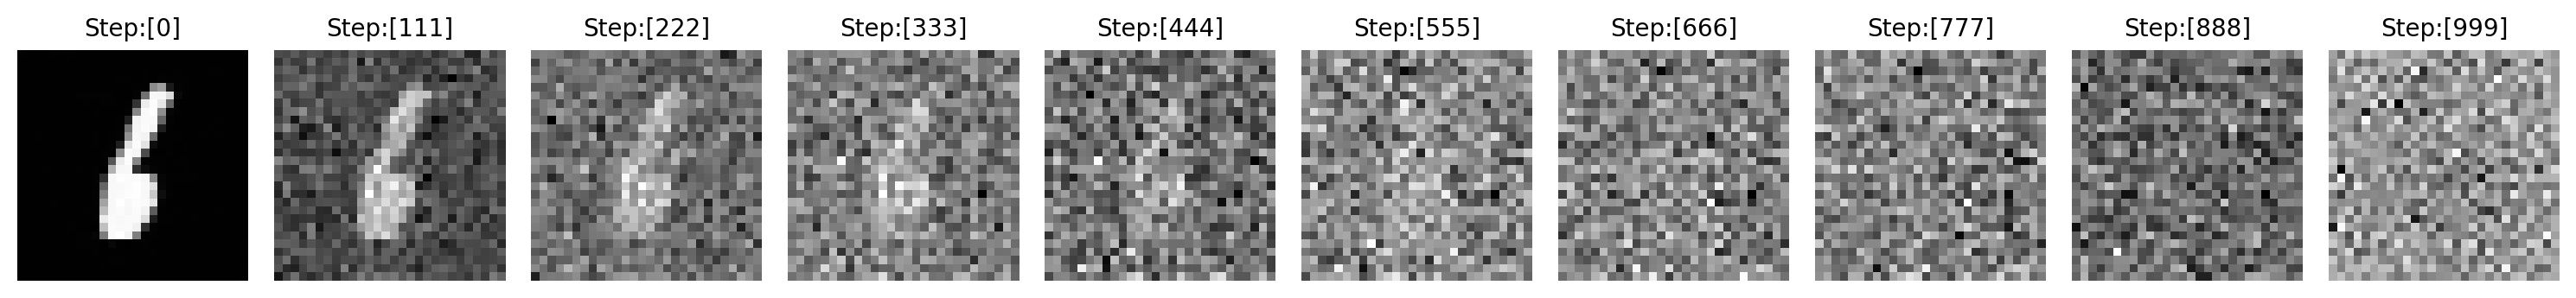

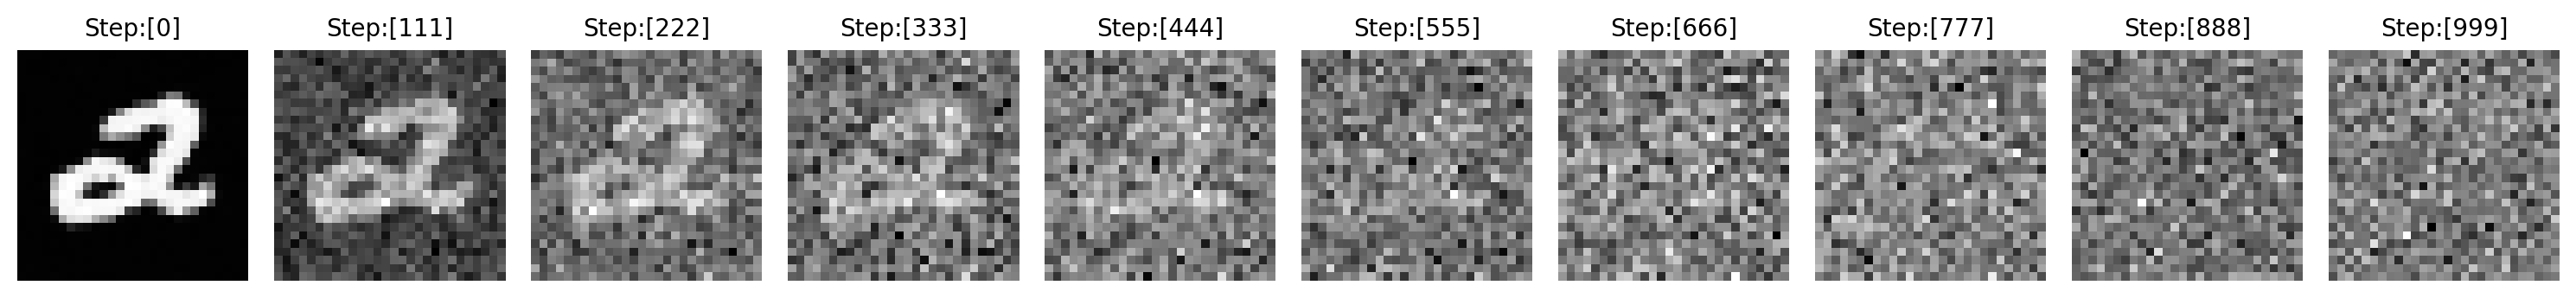

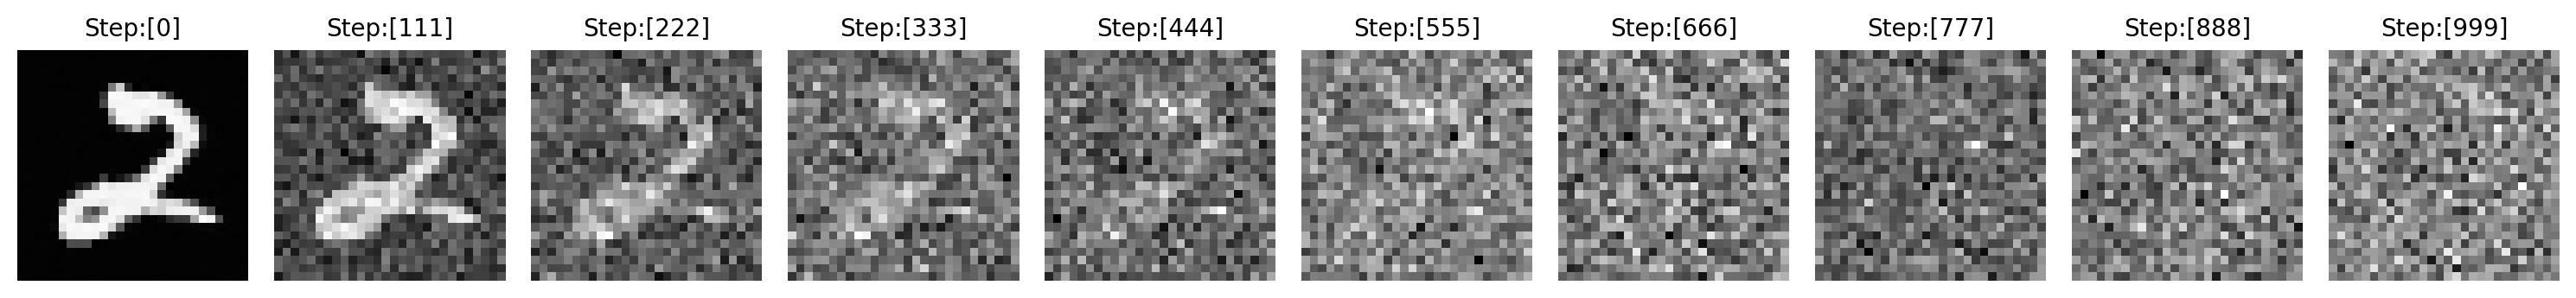

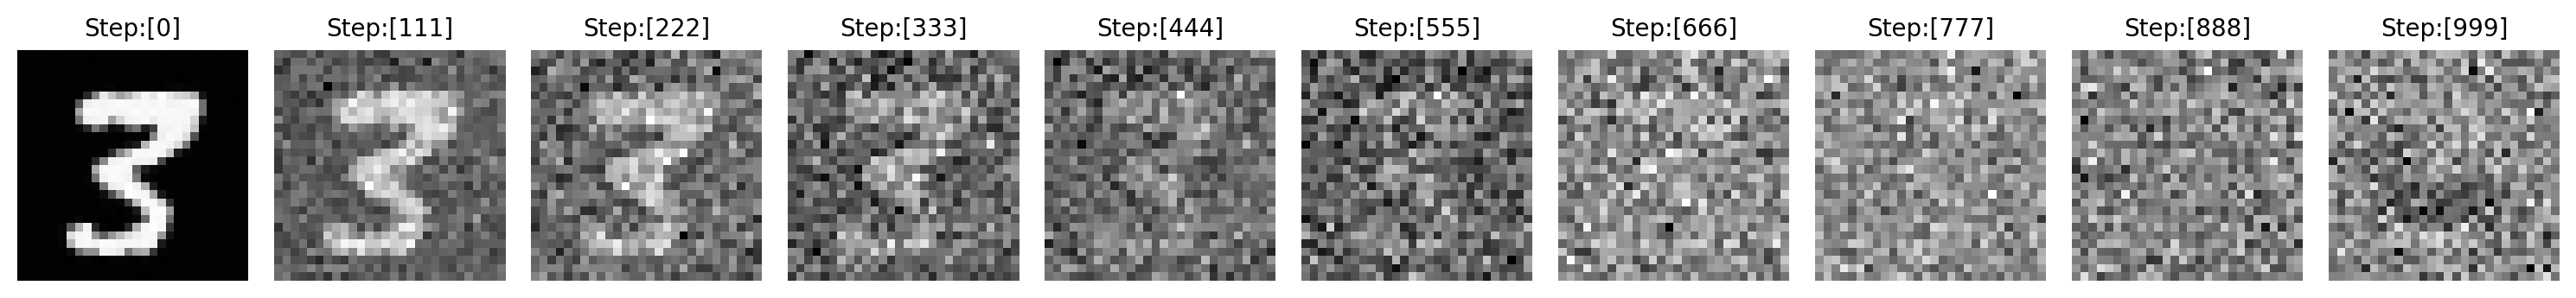

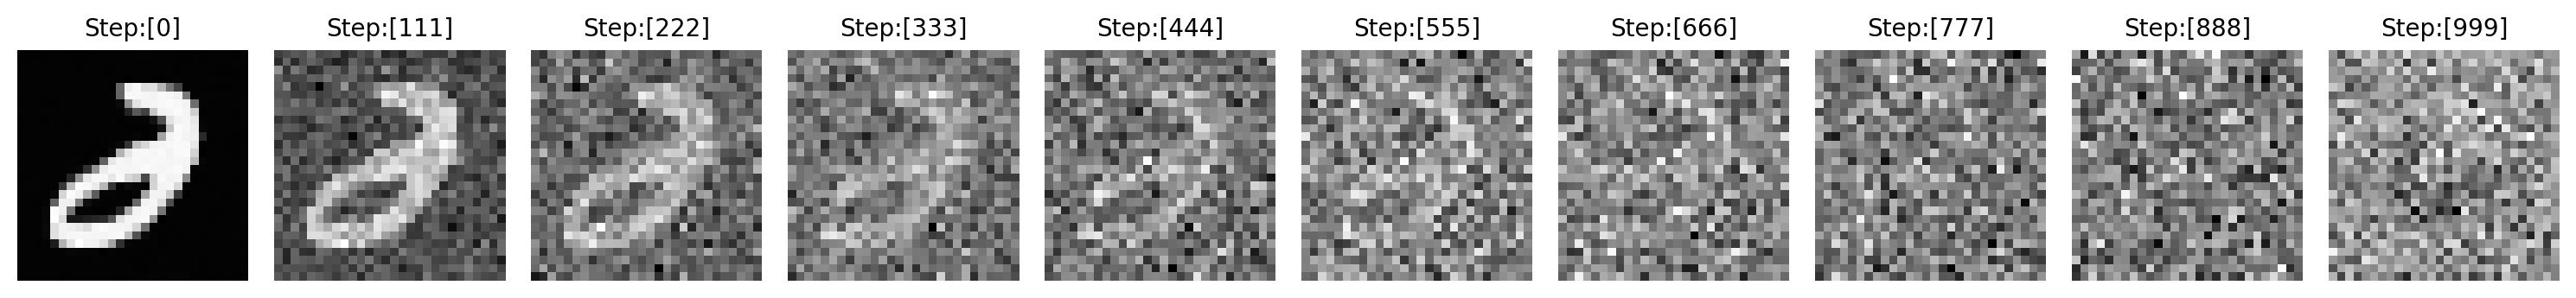

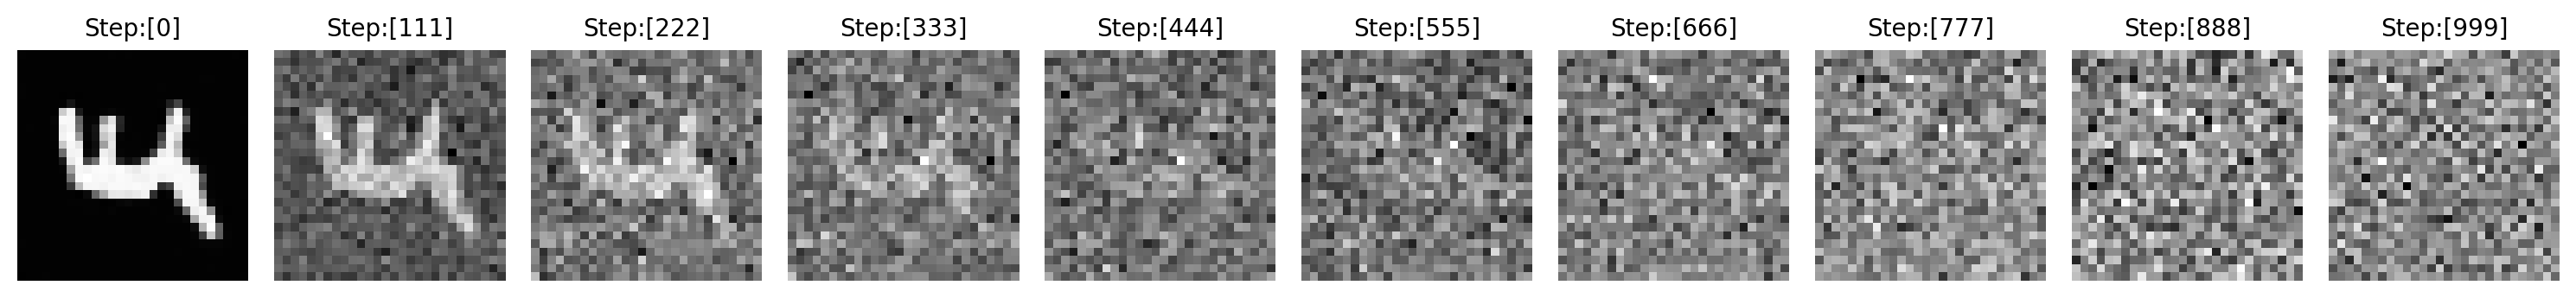

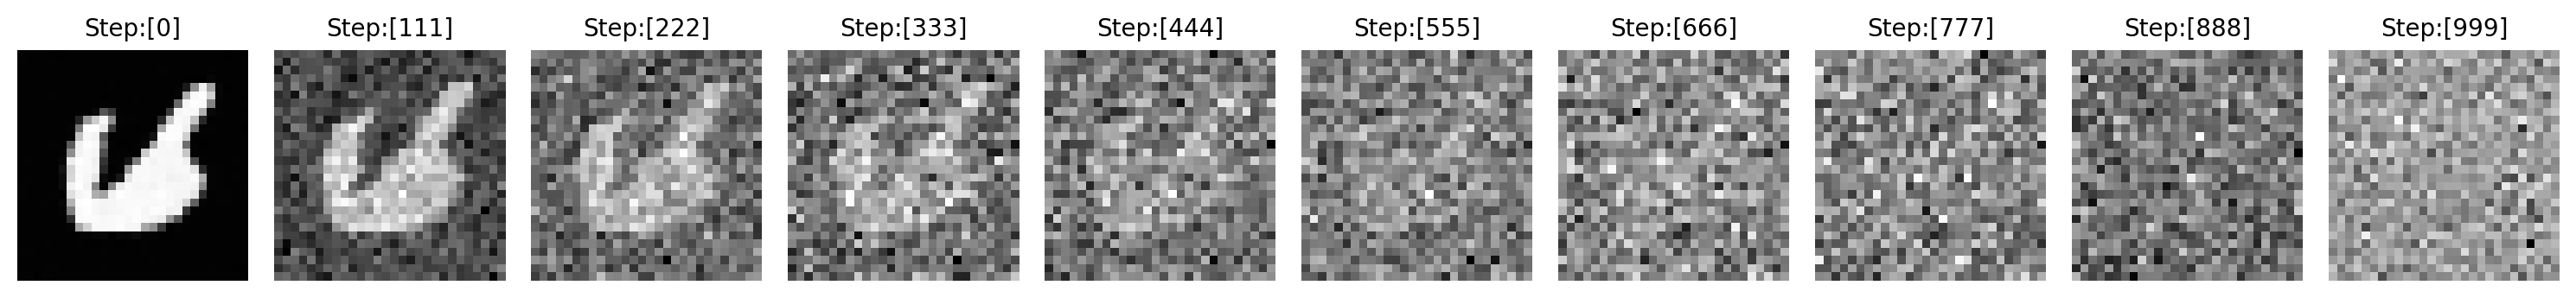

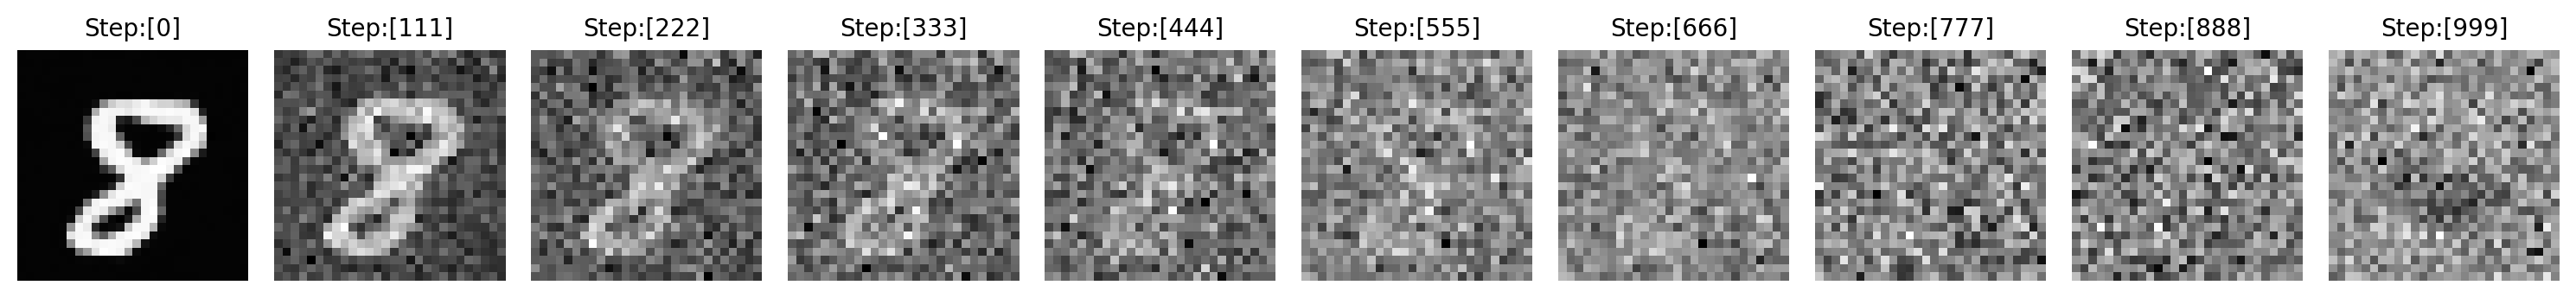

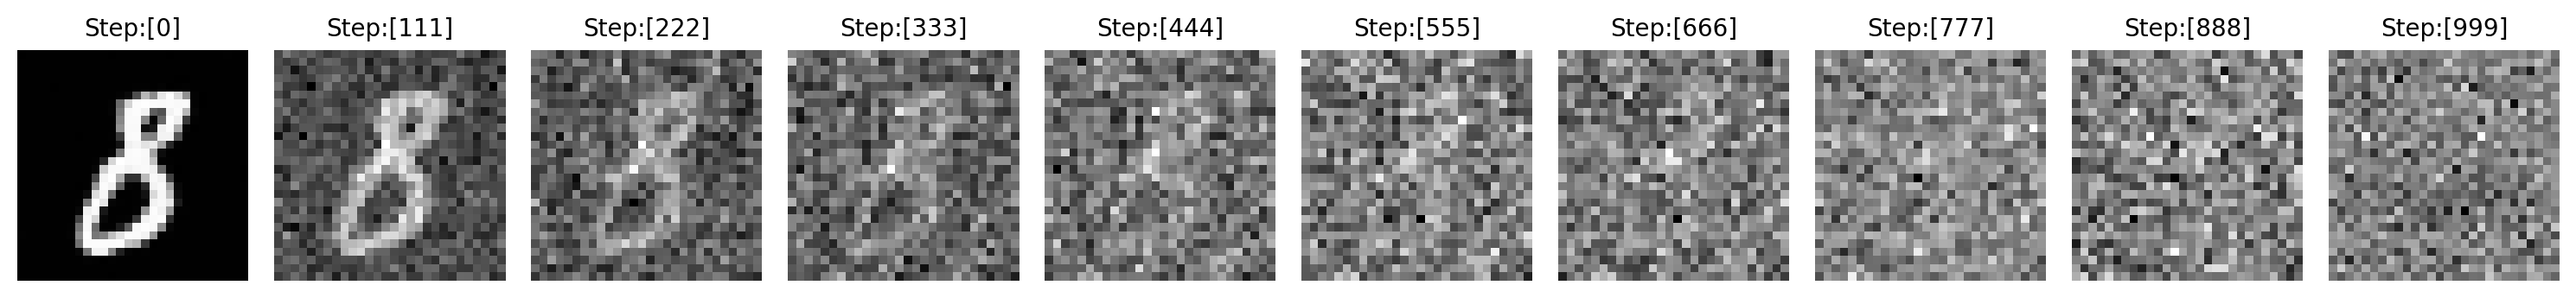

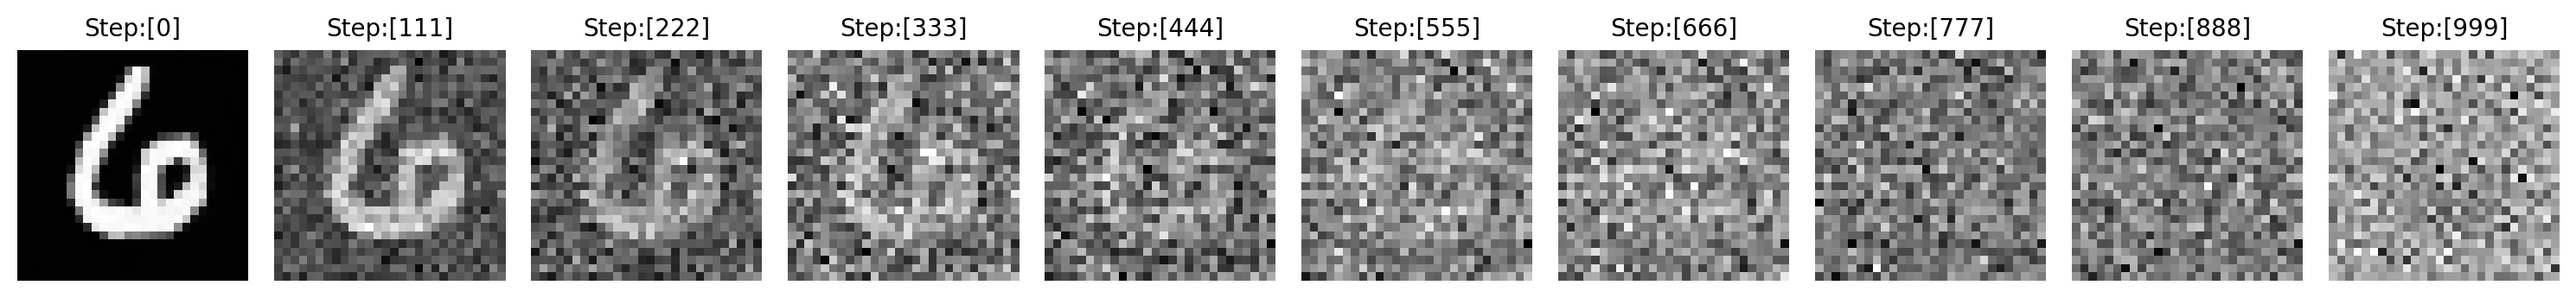

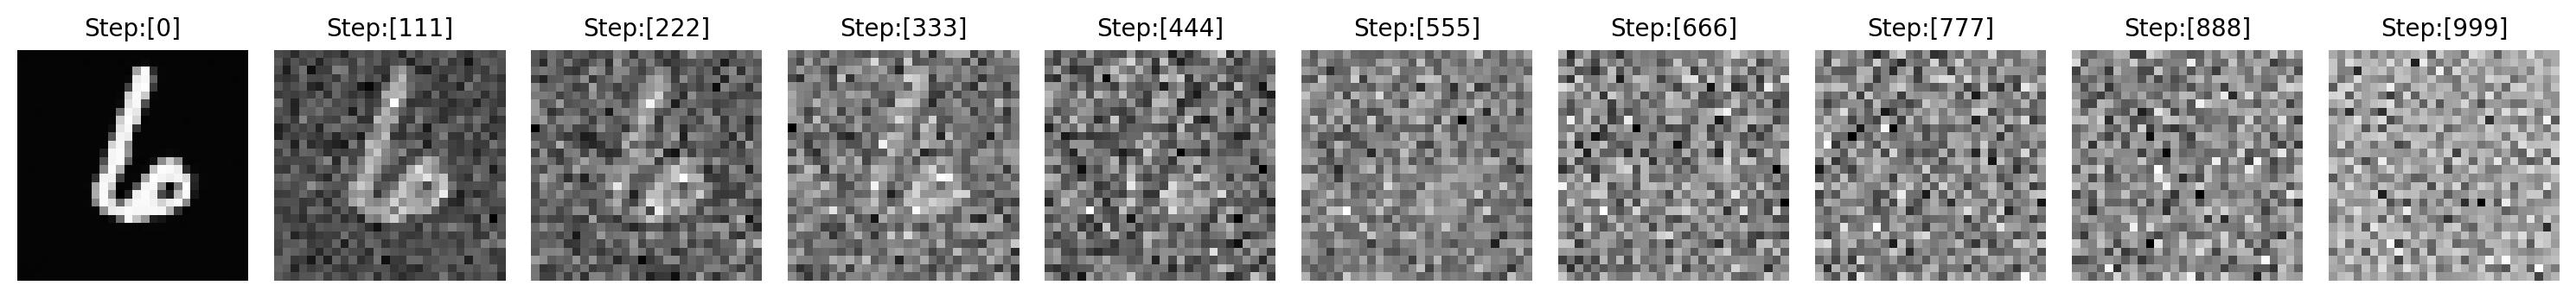

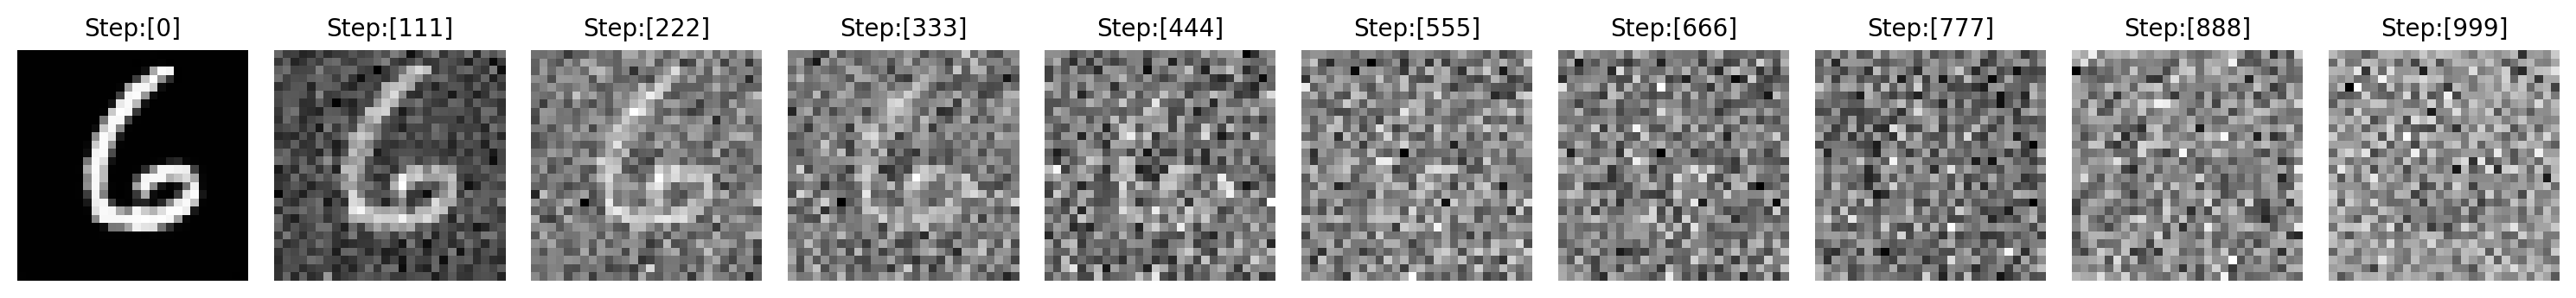

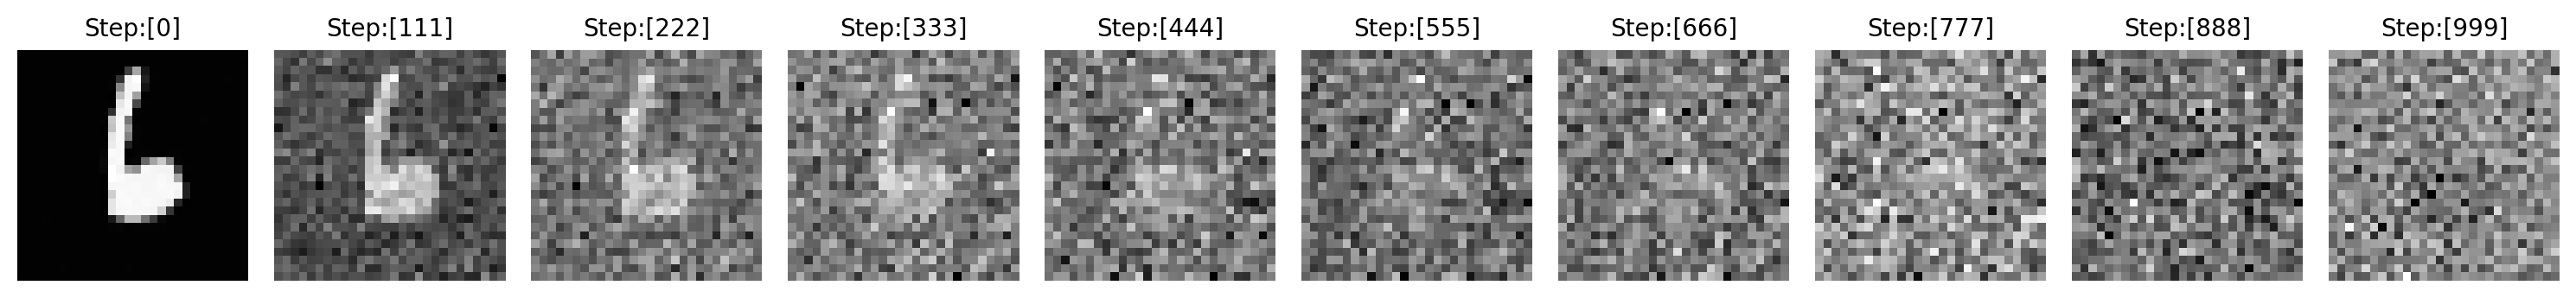

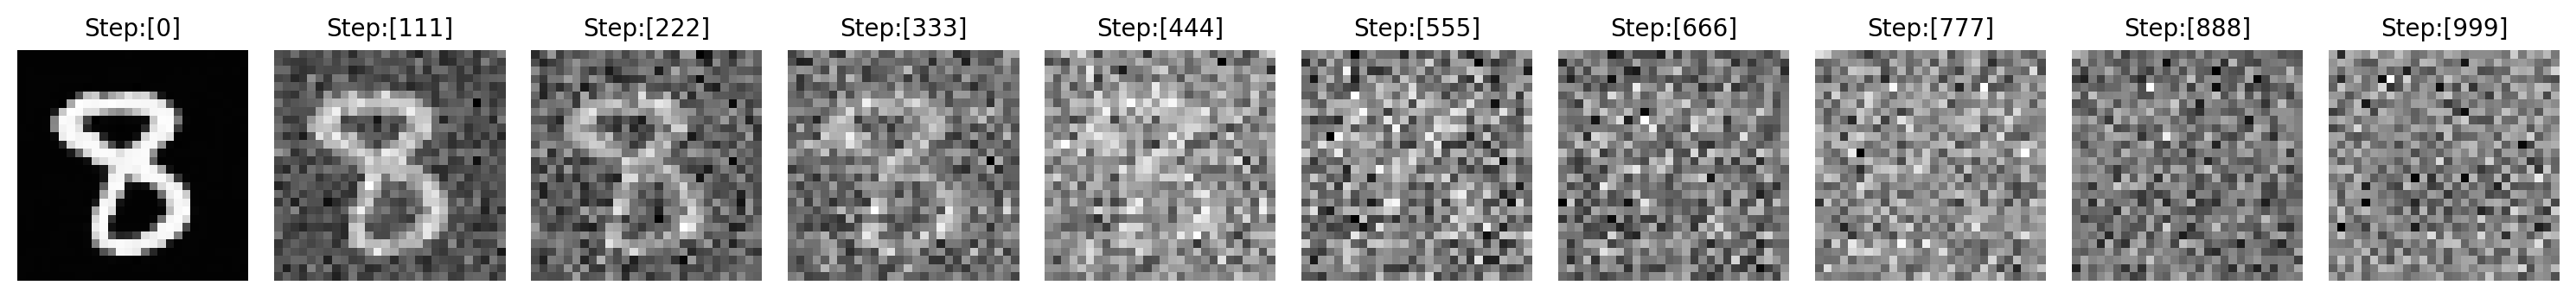

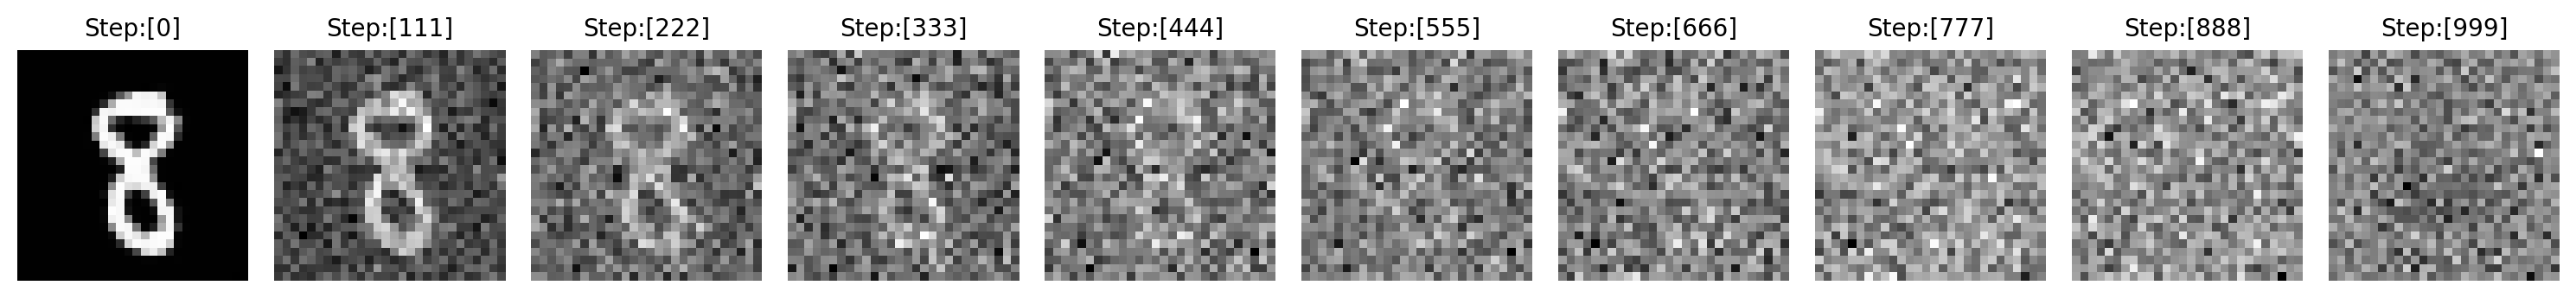

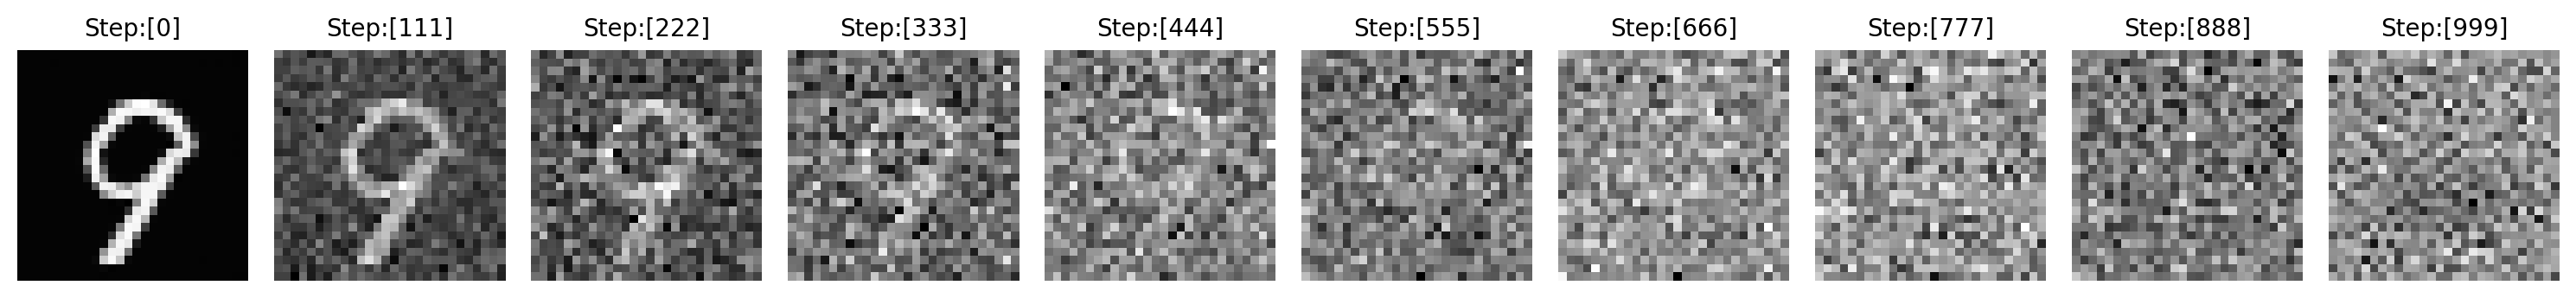

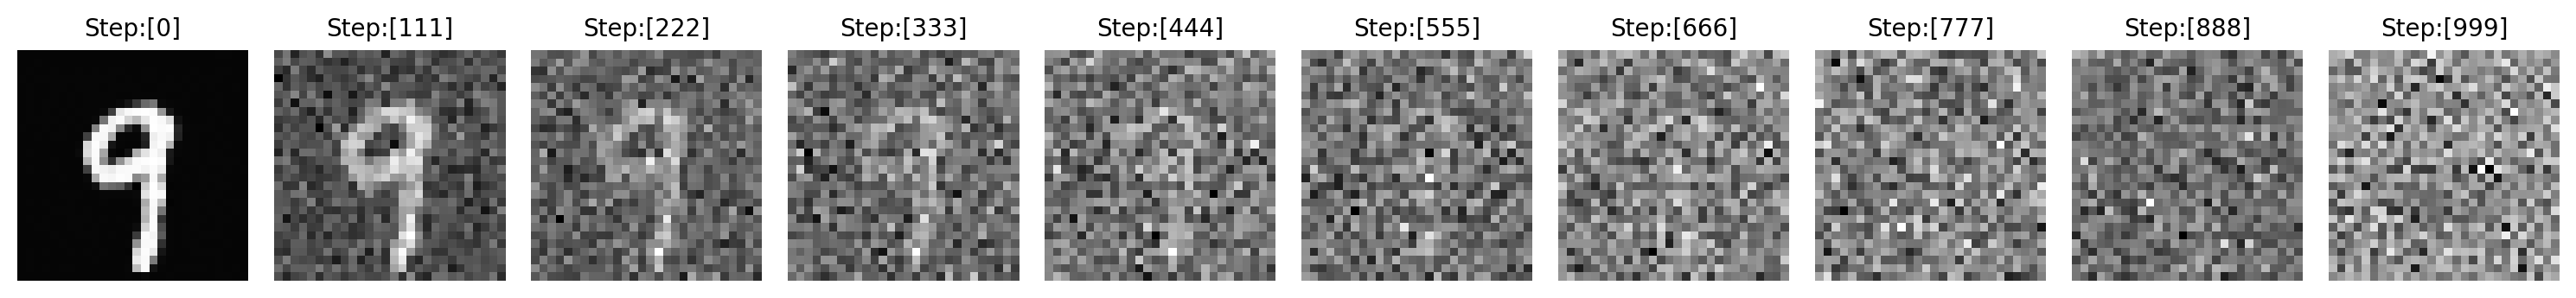

In [14]:
def get_conditioning_embedding_circle_number(circle, number, device):
    circle_label = circle
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

n_sample = 2
for number in range(0,10):
    test_embedding_vector = get_conditioning_embedding_circle_number(1,number,device)
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
    plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

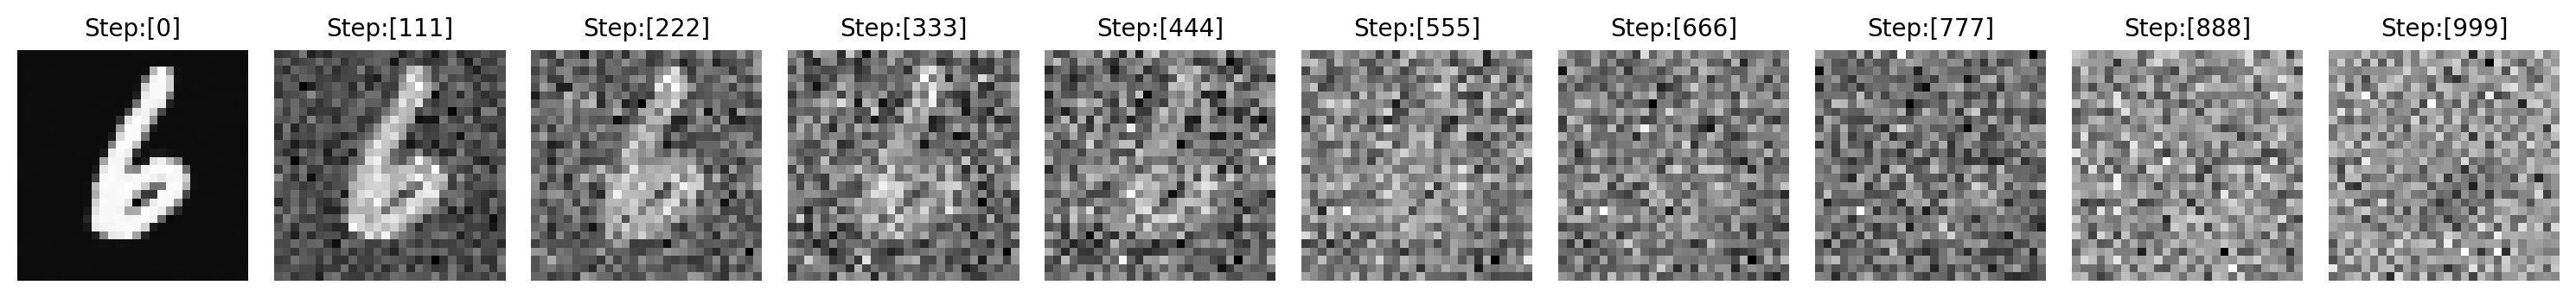

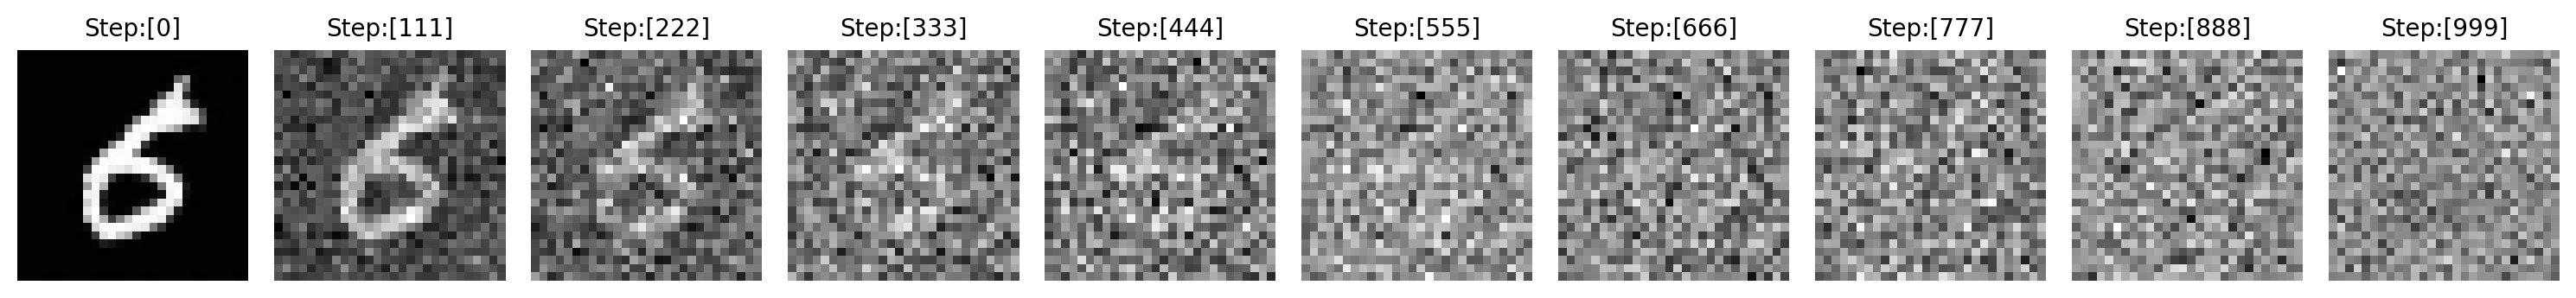

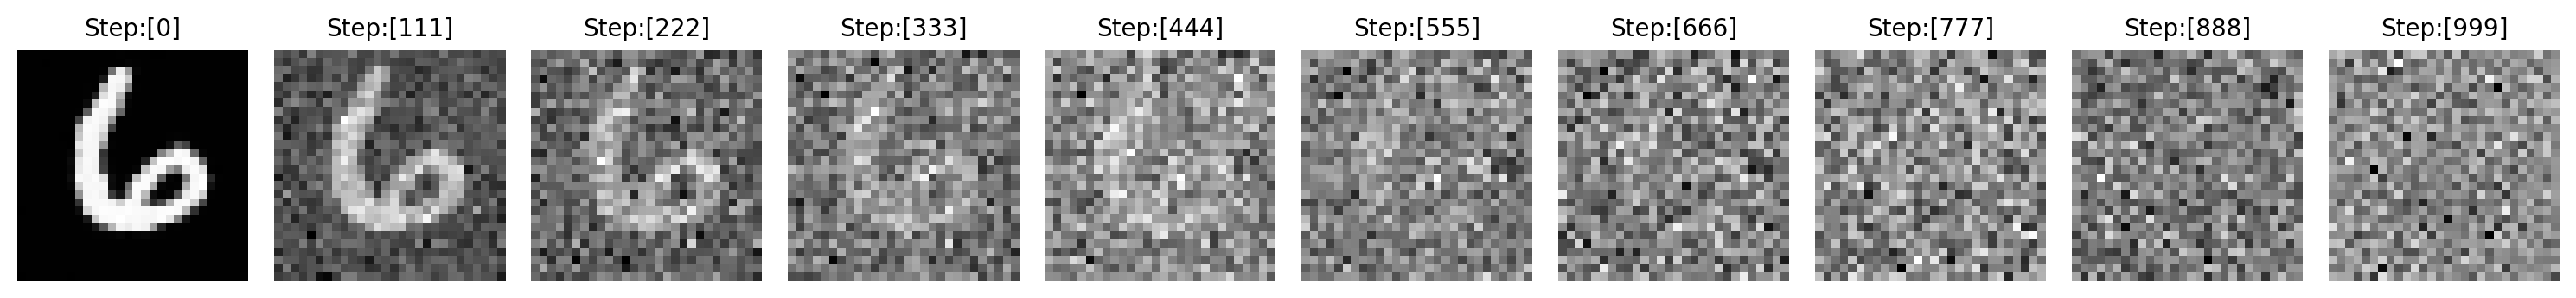

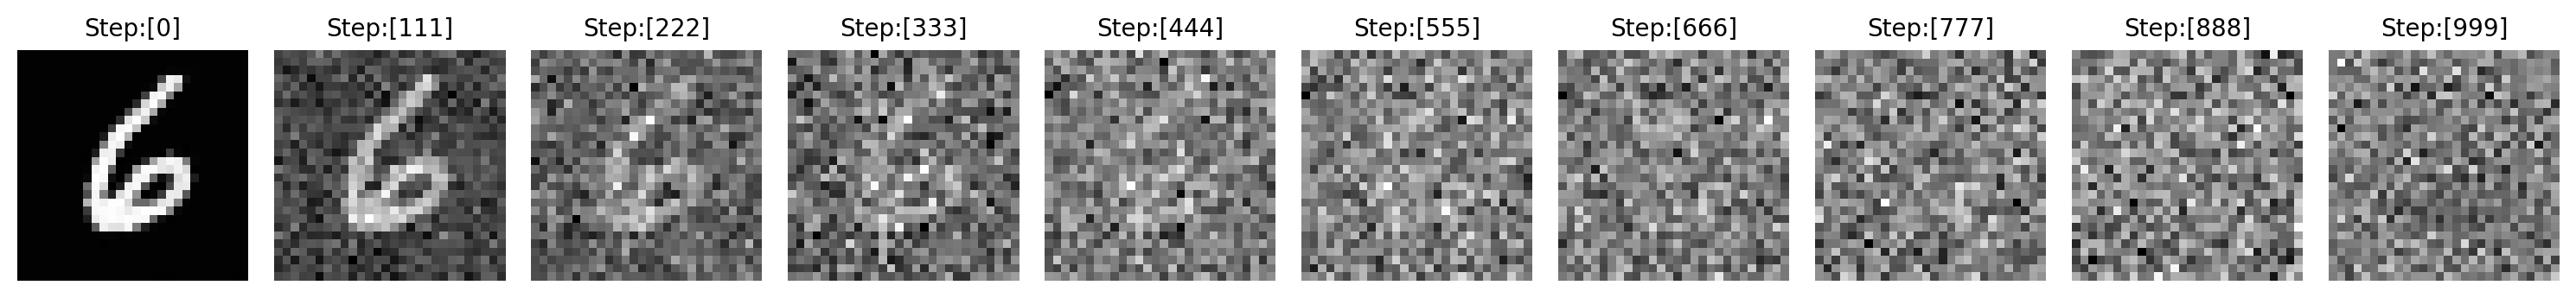

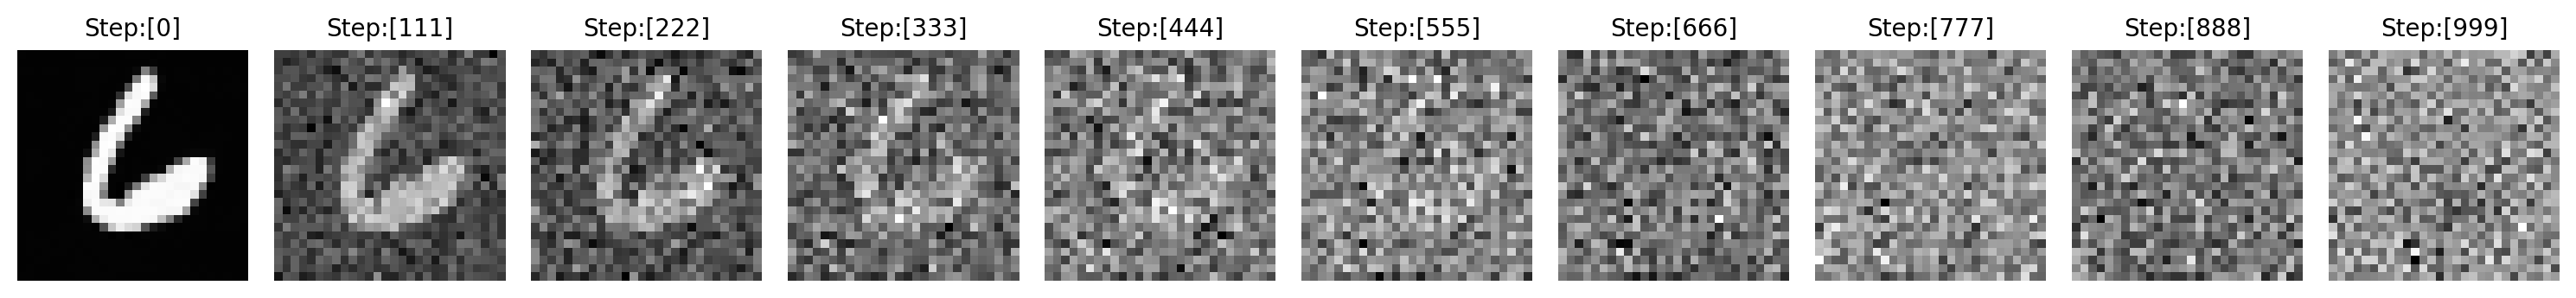

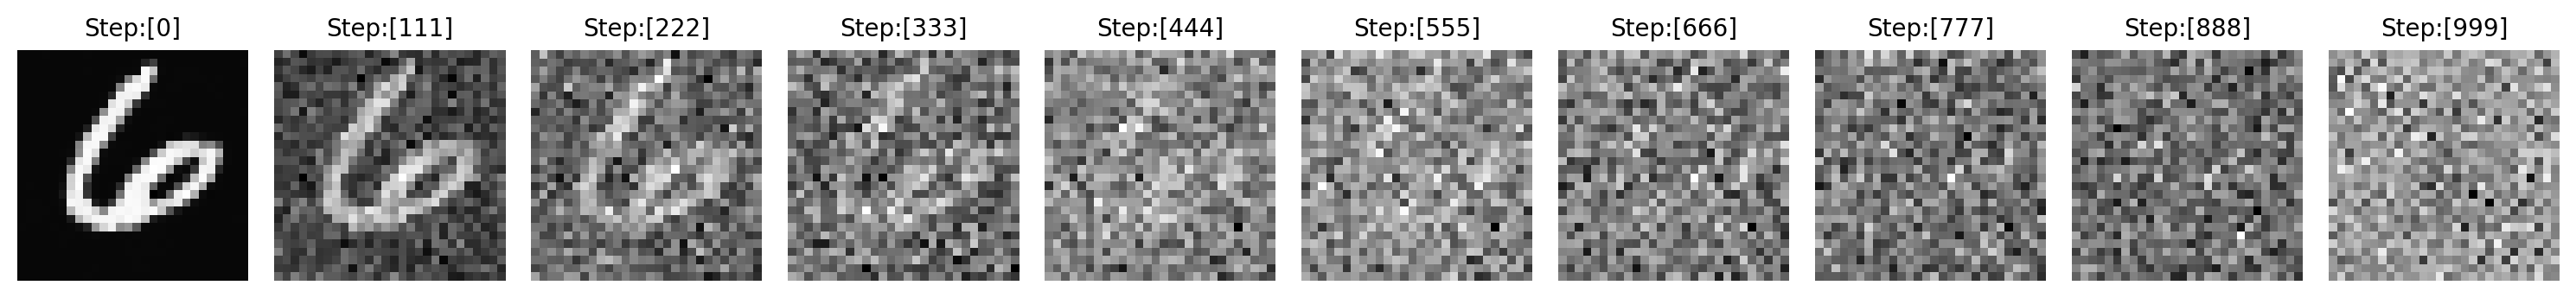

In [18]:
def get_conditioning_embedding_circle_number(circle, number, device):
    circle_label = circle
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

n_sample = 6
test_embedding_vector = get_conditioning_embedding_circle_number(1,7,device)
step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

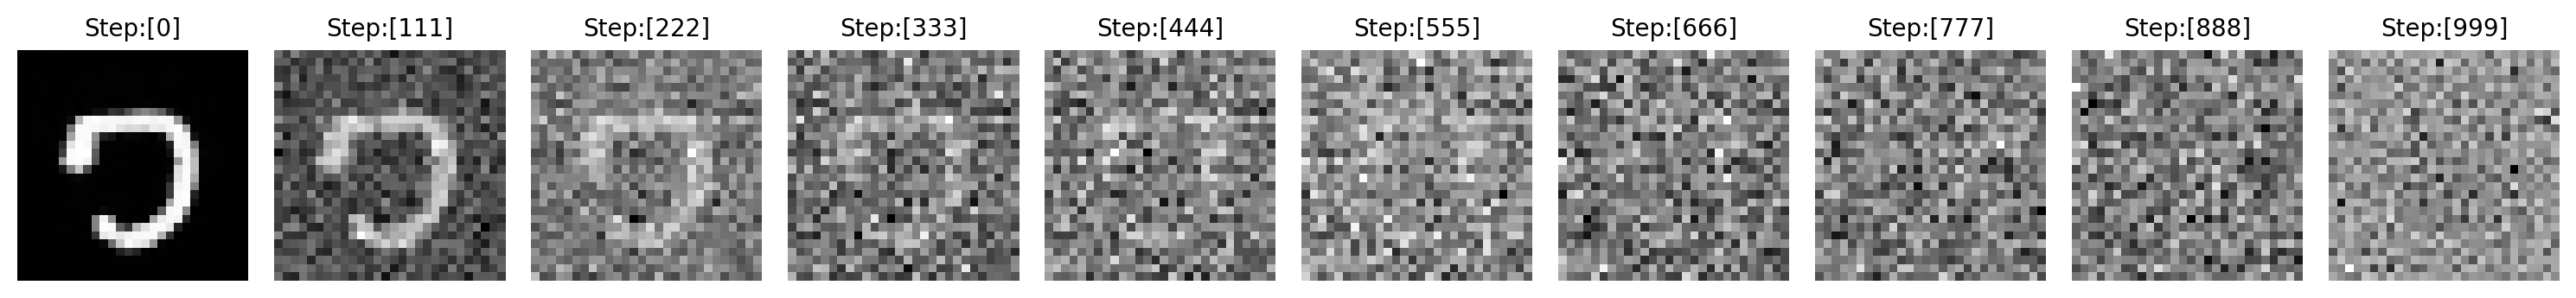

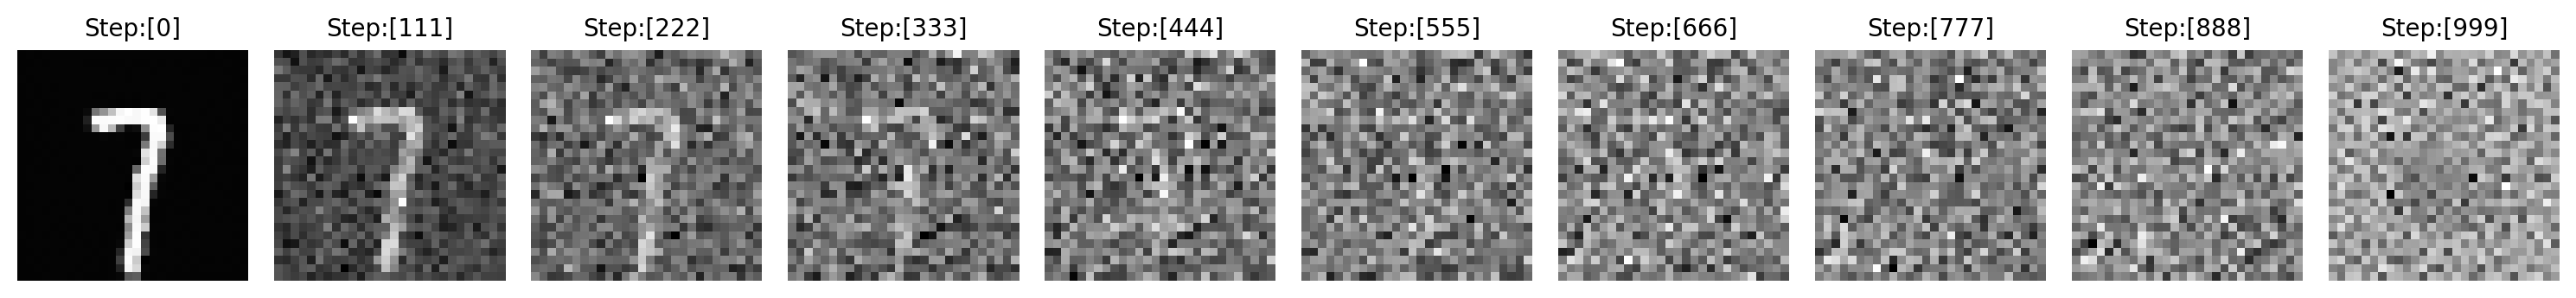

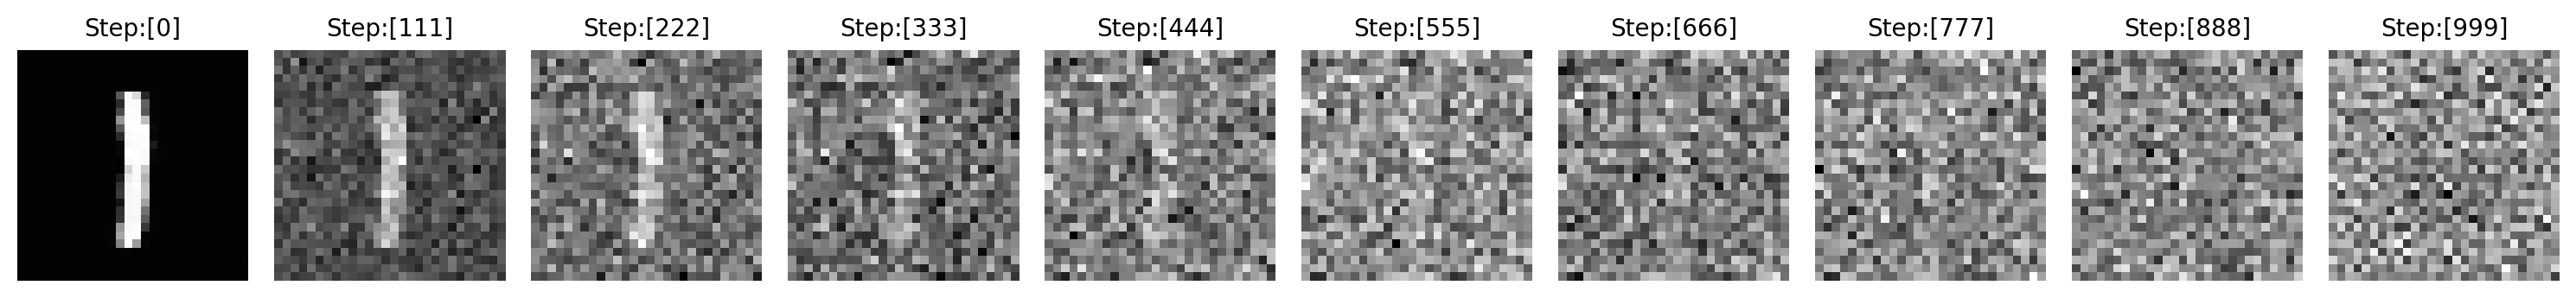

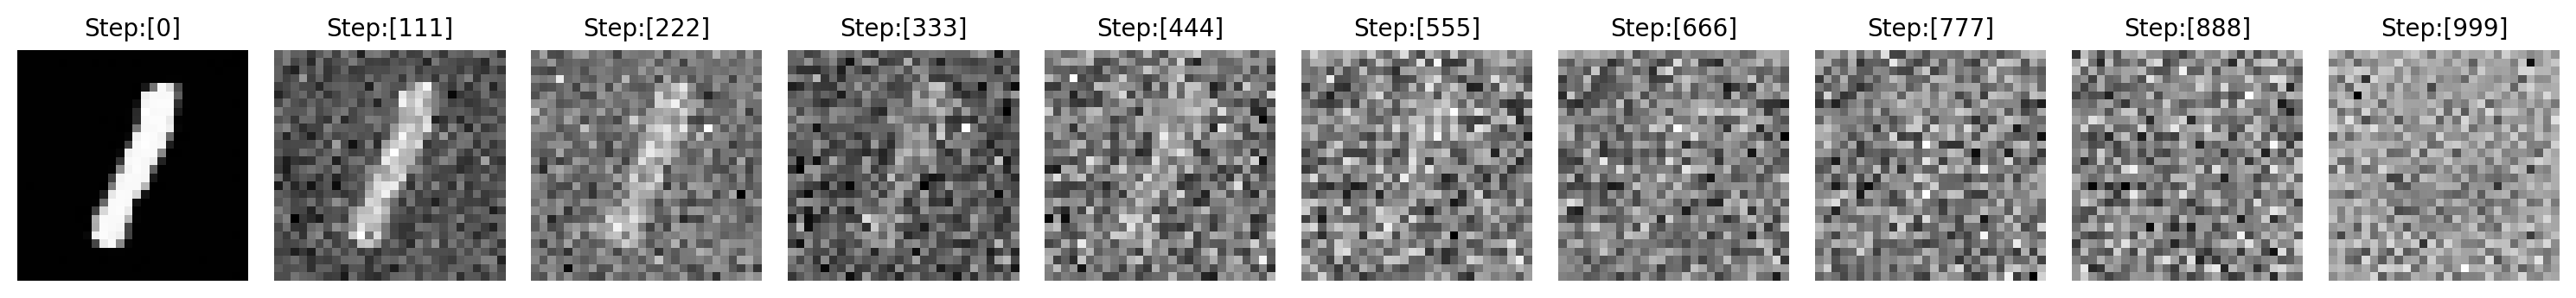

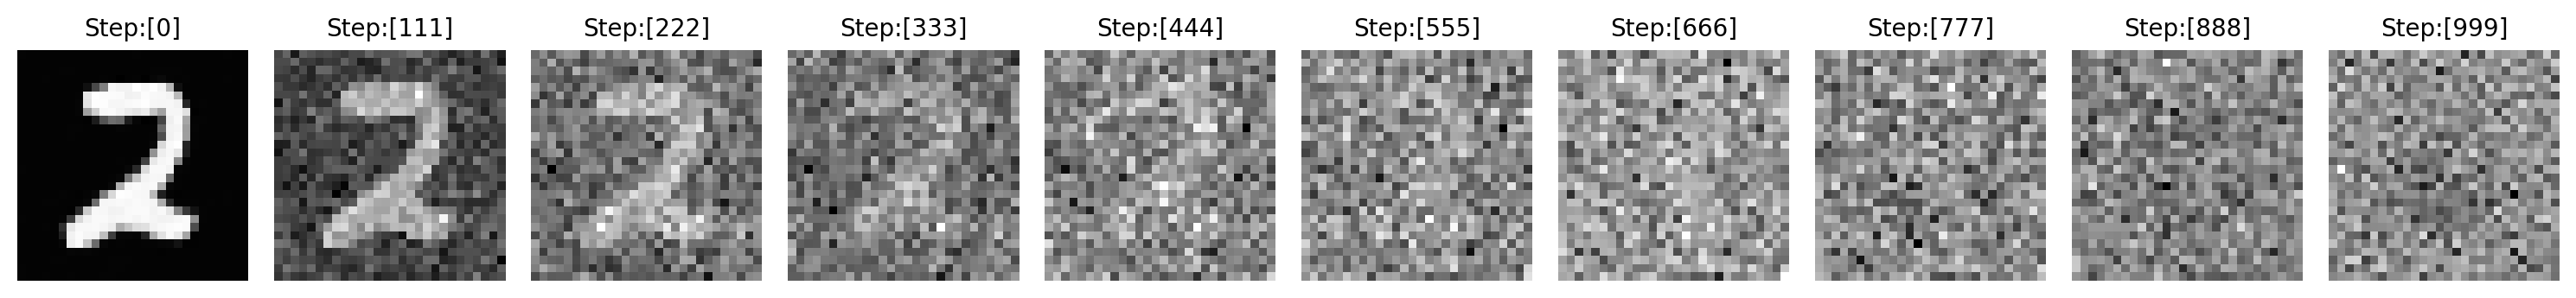

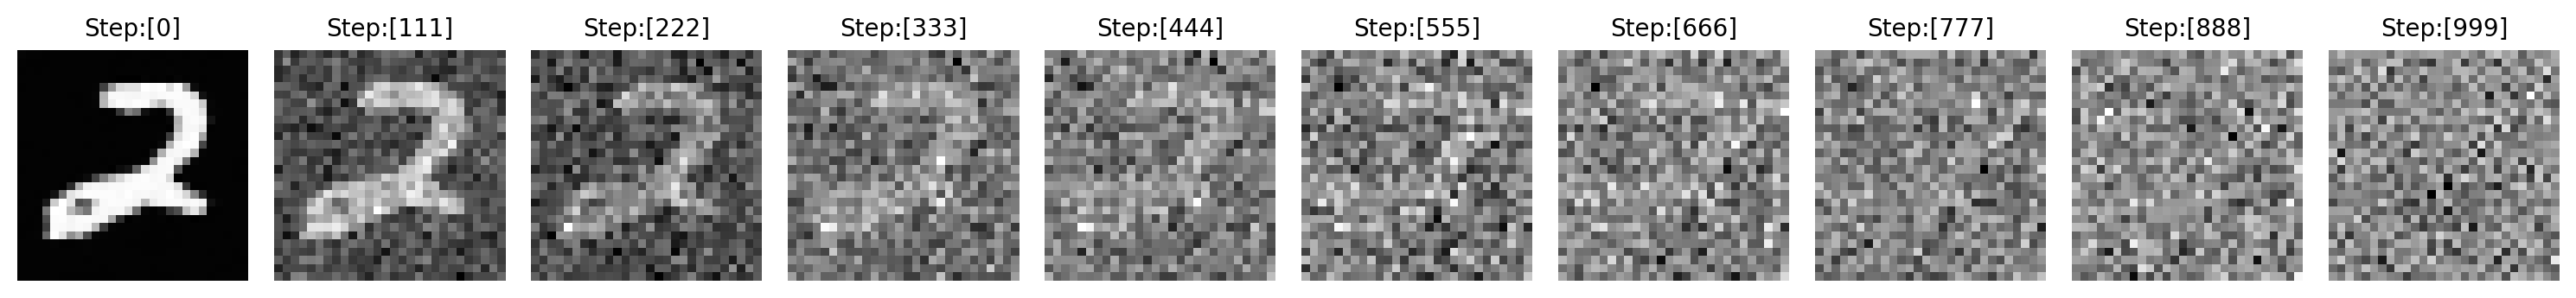

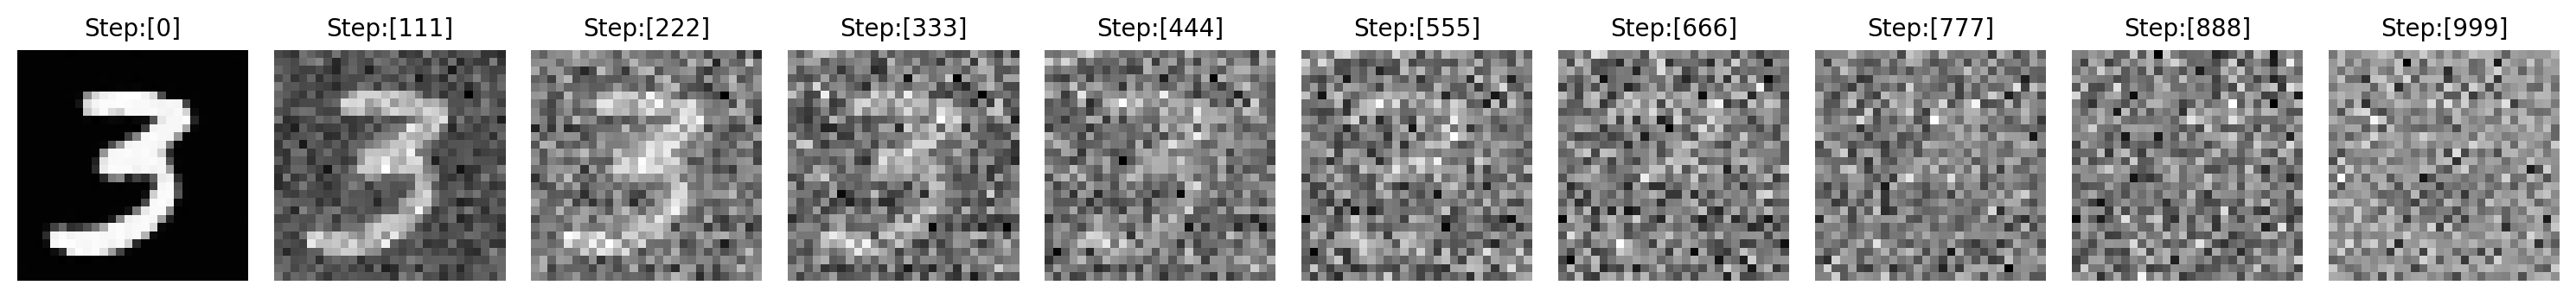

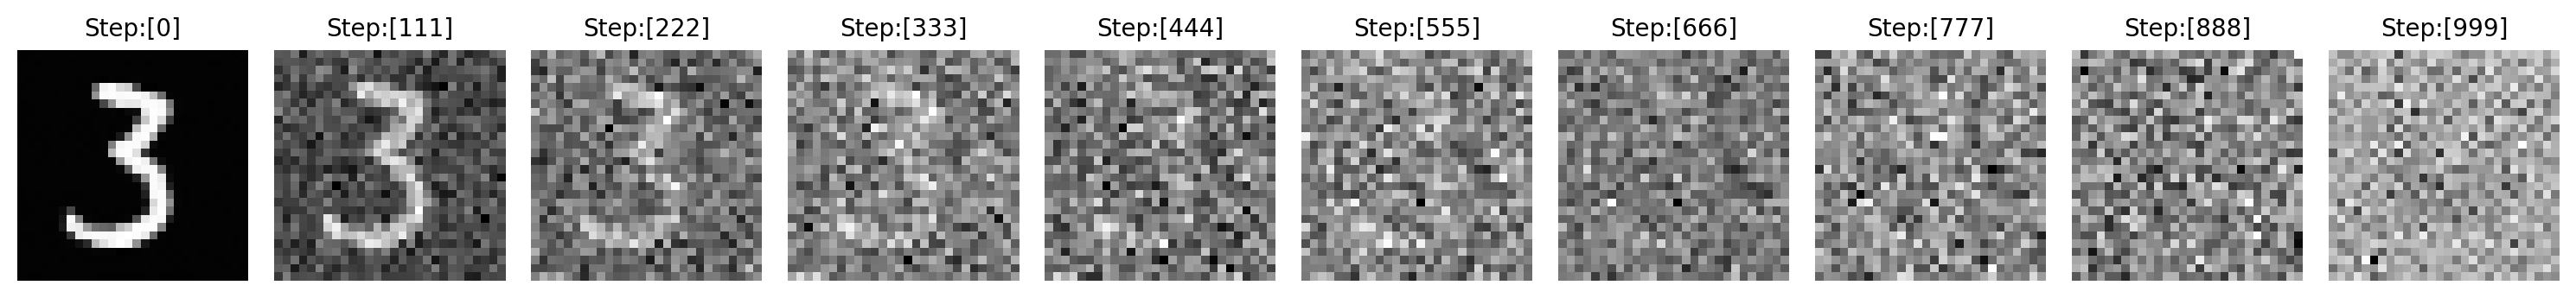

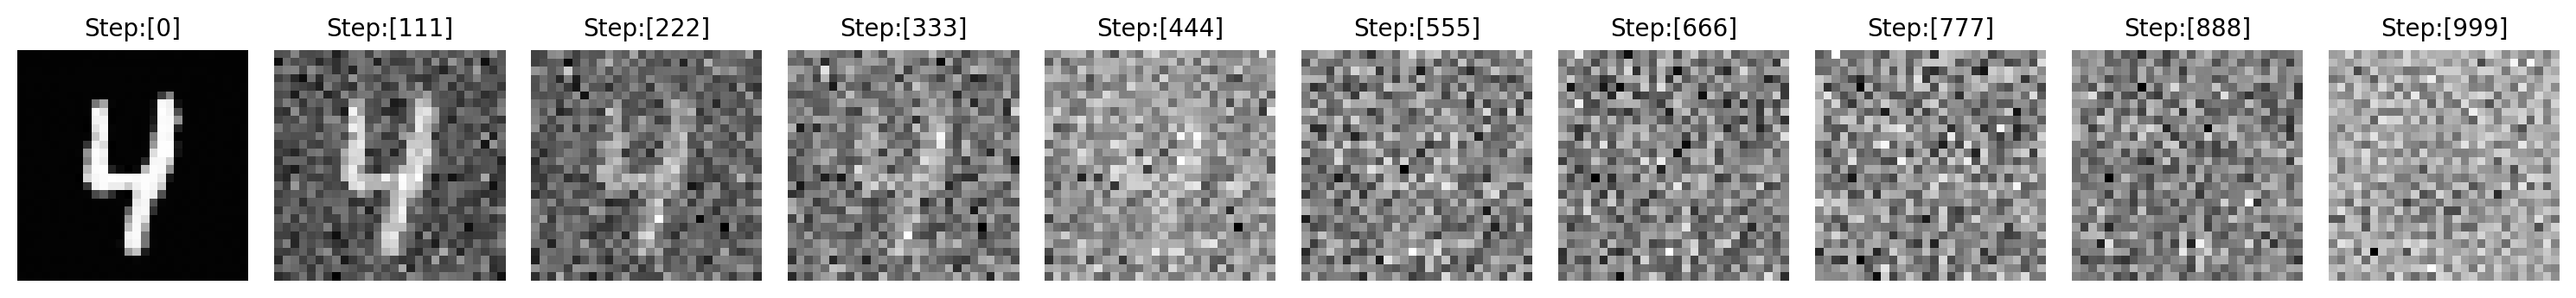

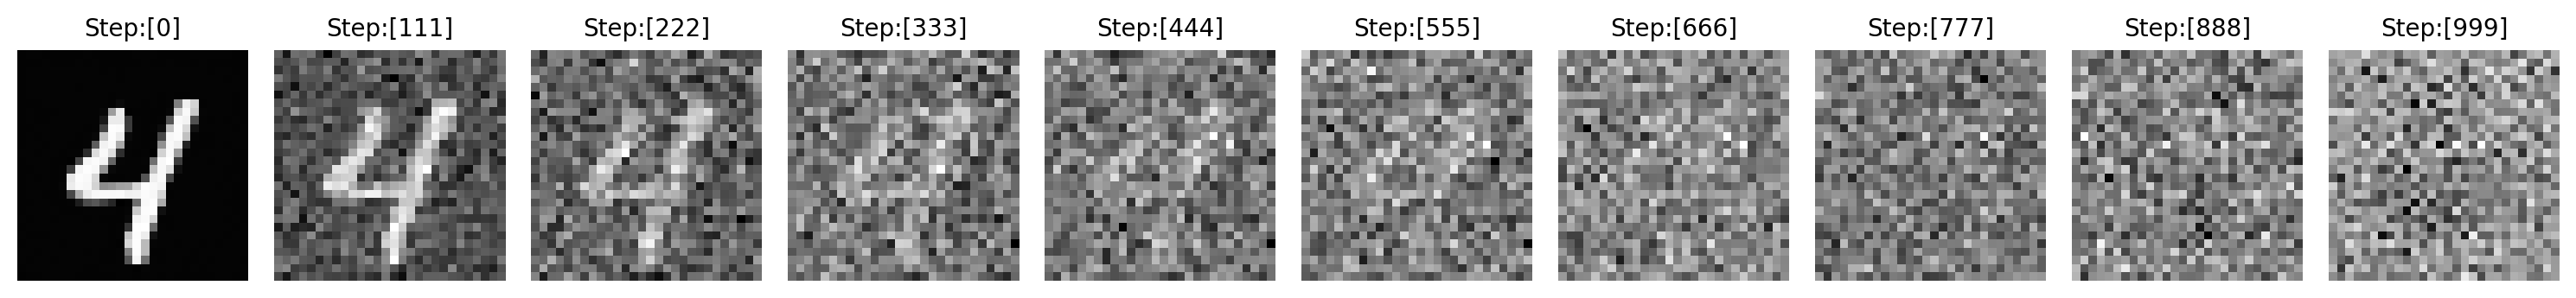

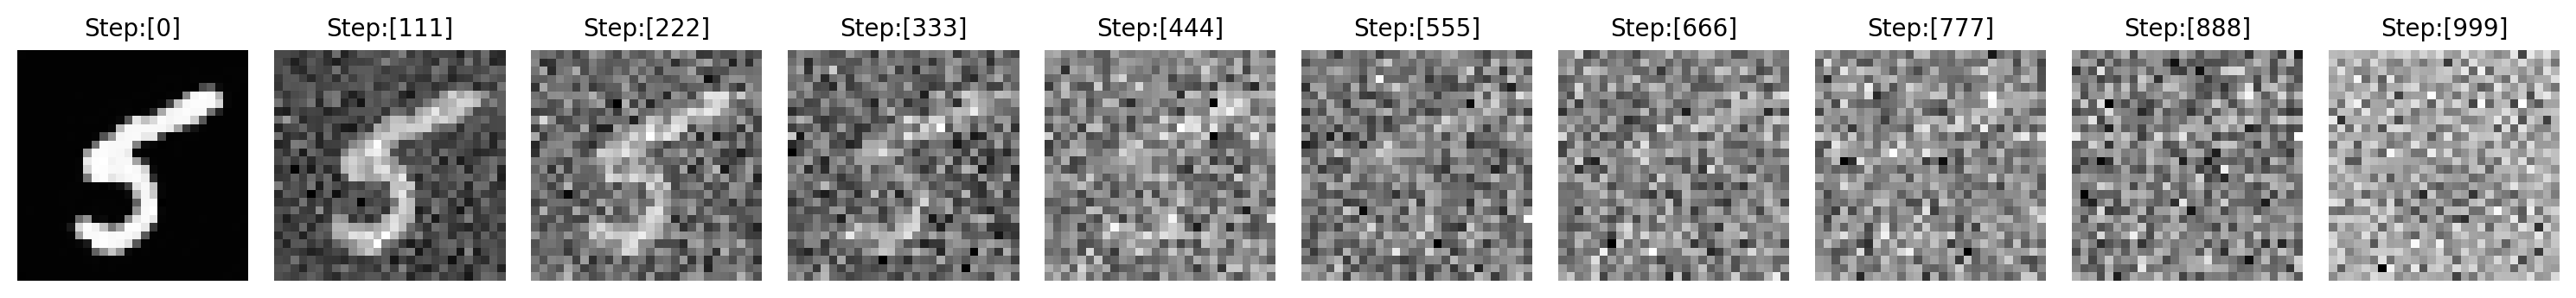

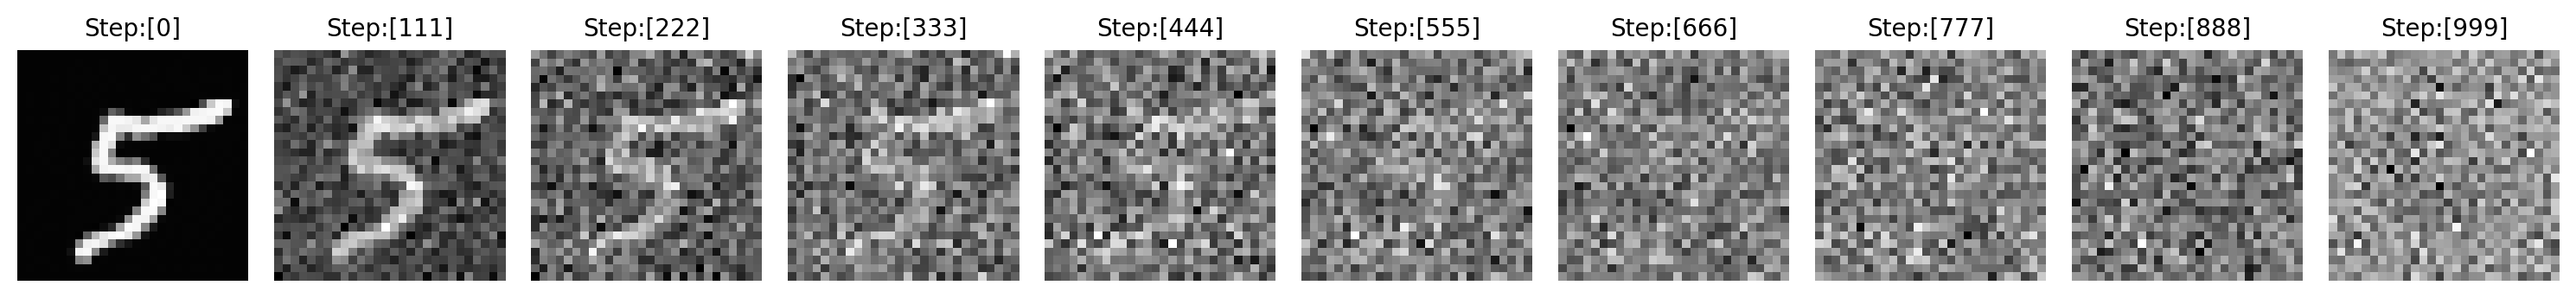

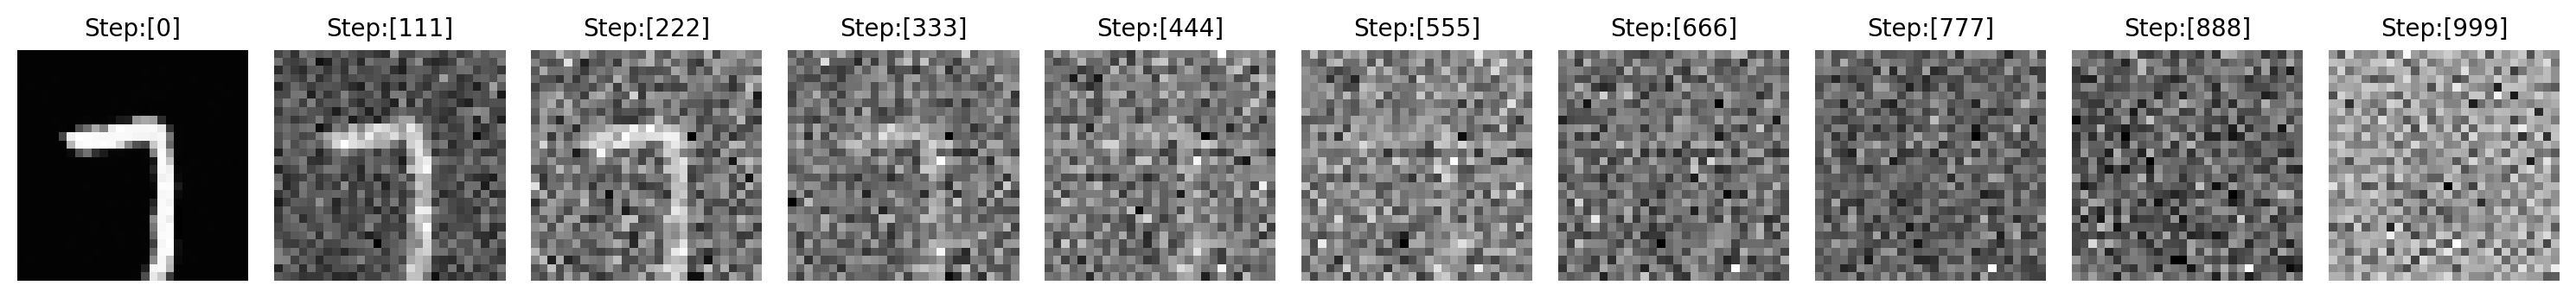

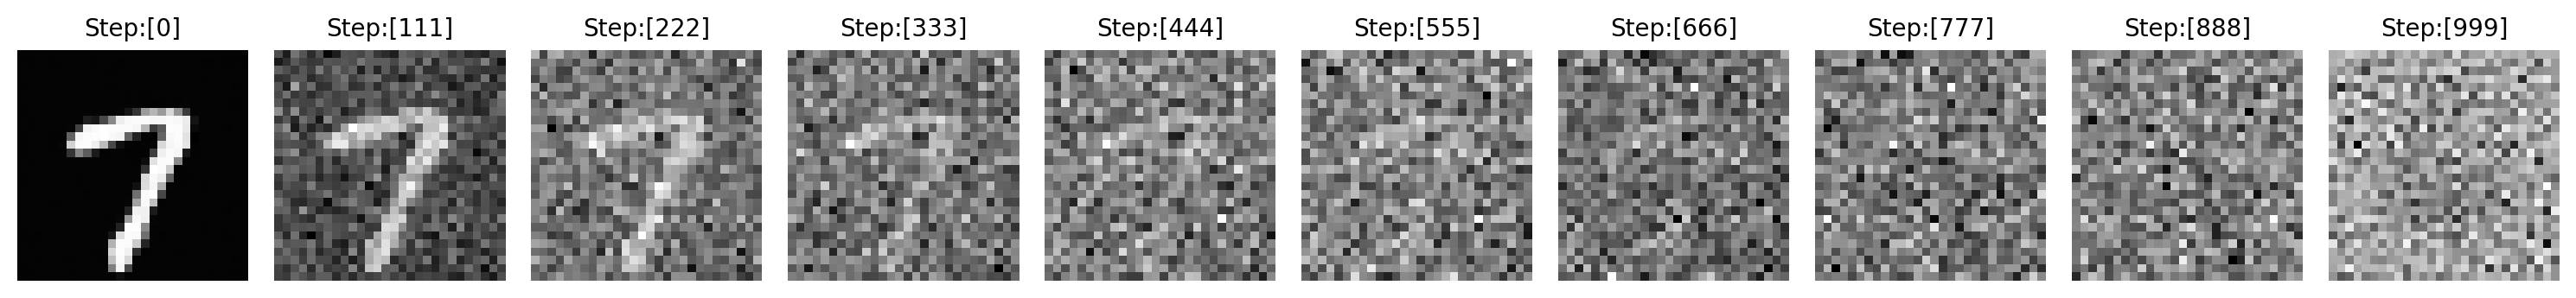

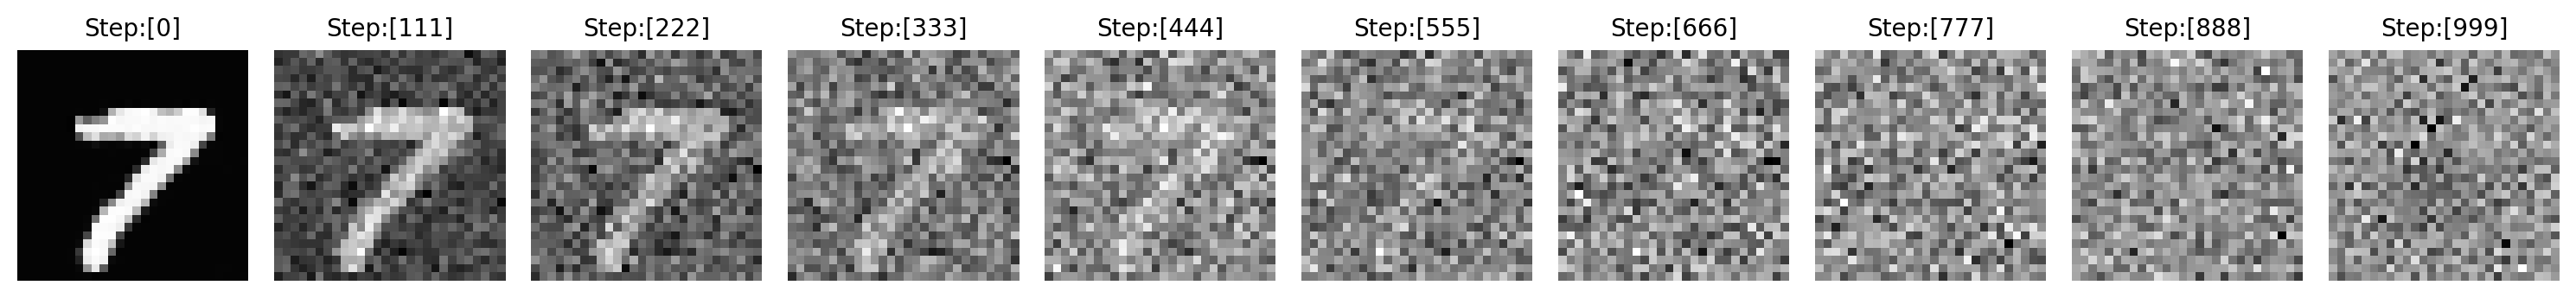

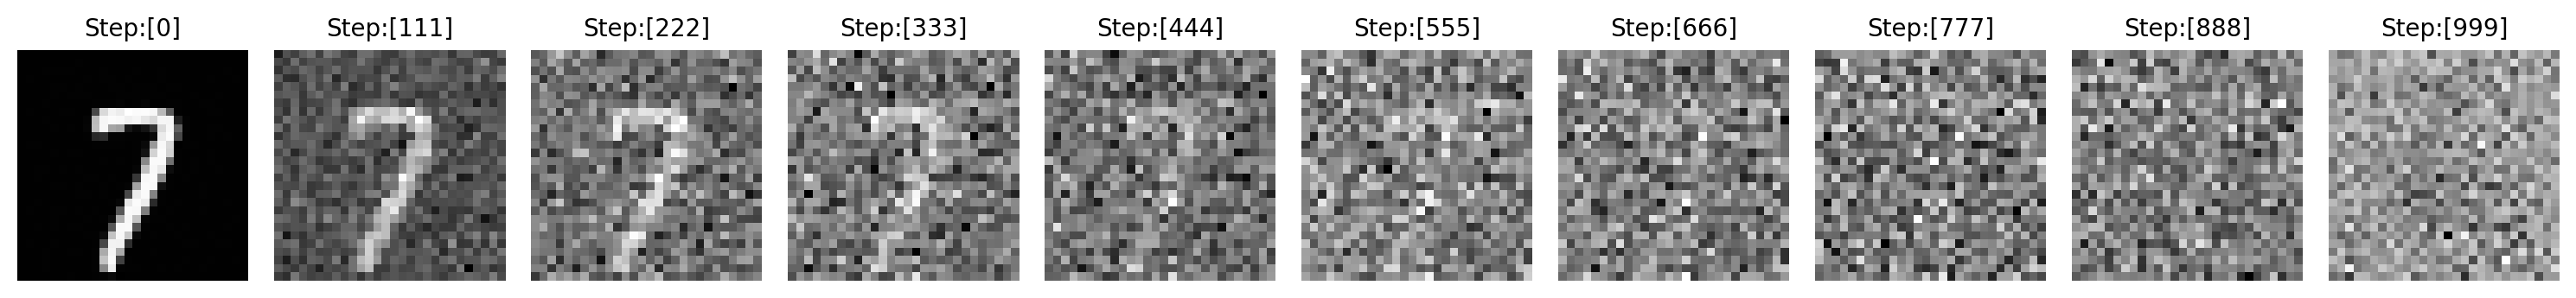

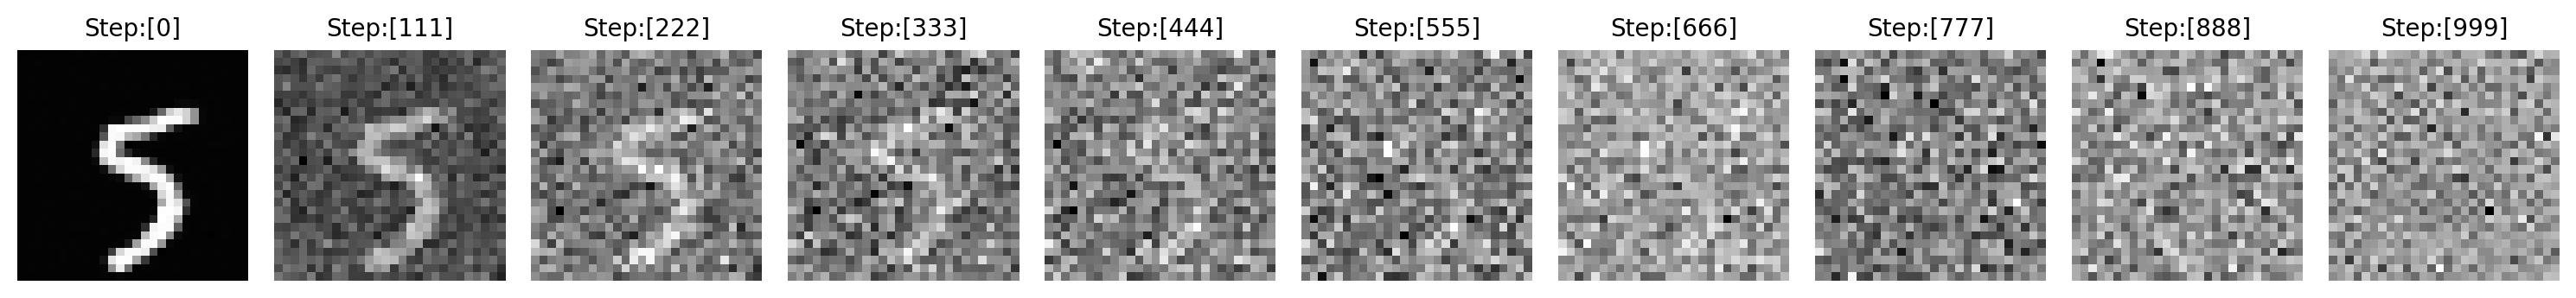

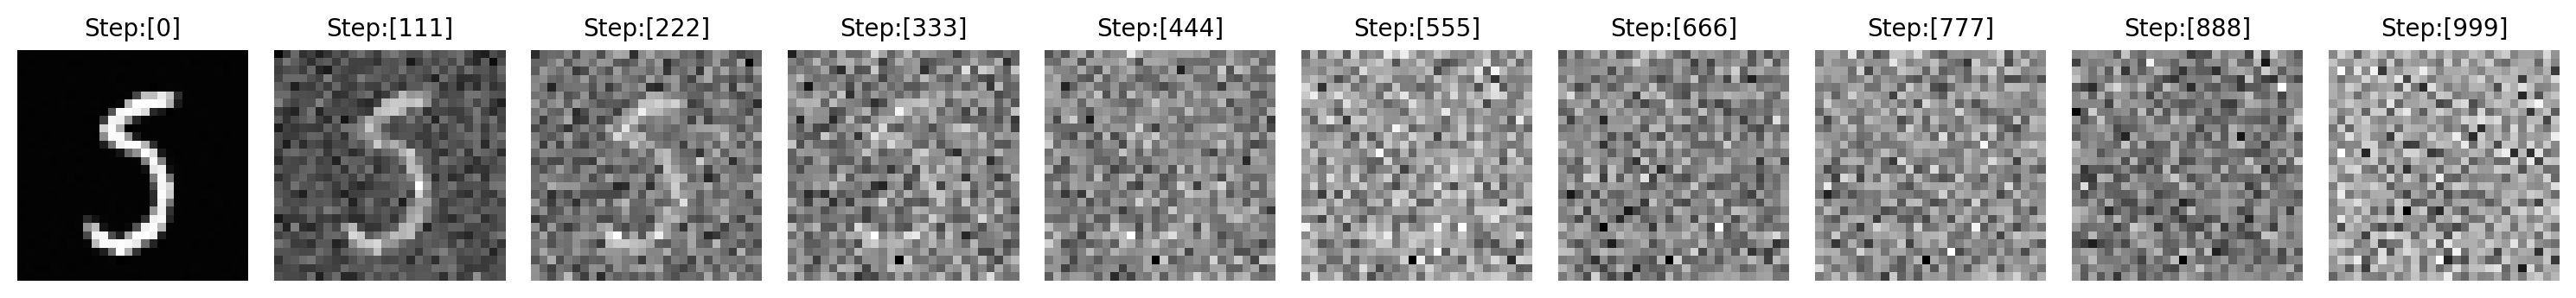

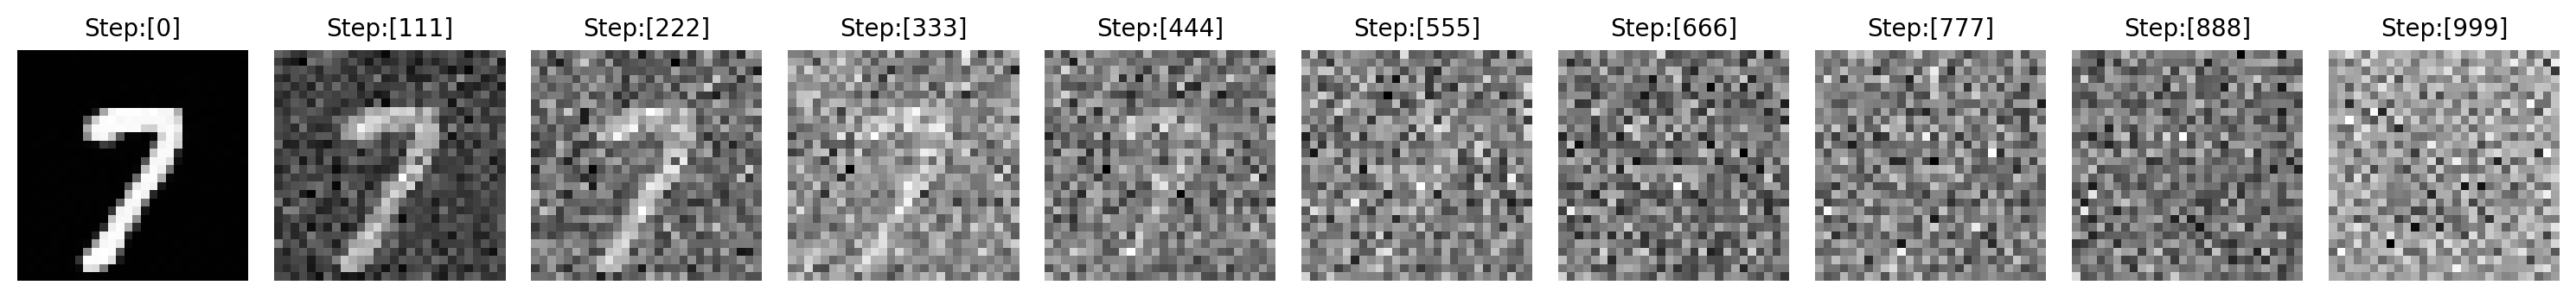

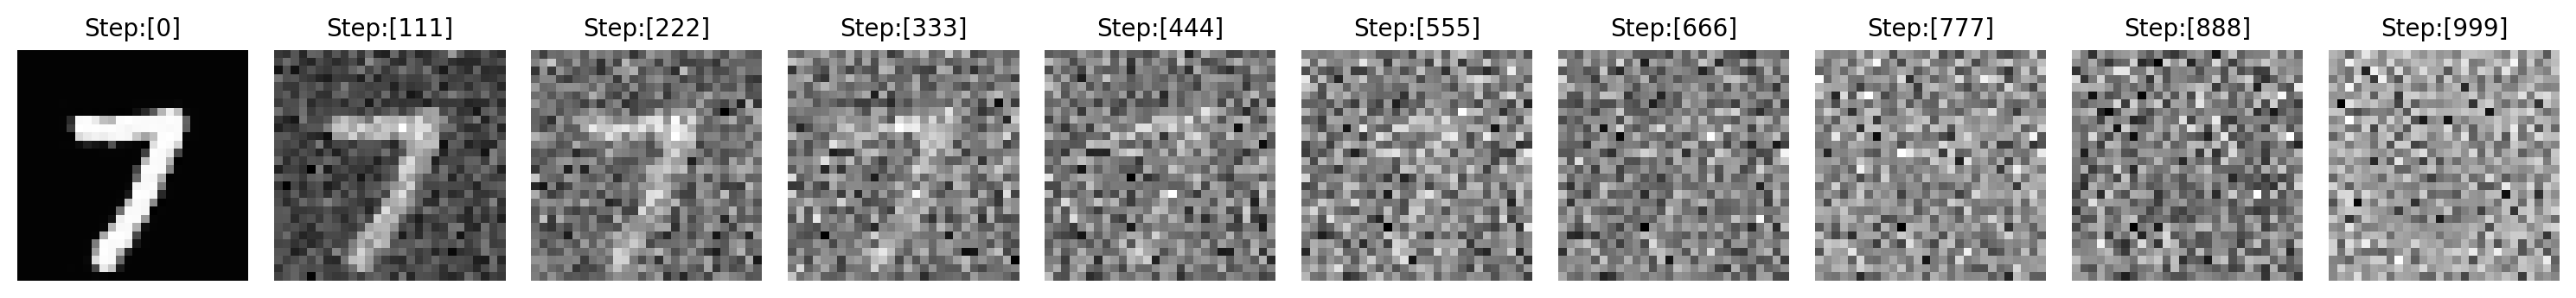

In [19]:
def get_conditioning_embedding_circle_number(circle, number, device):
    circle_label = circle
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

n_sample = 2
for number in range(0,10):
    test_embedding_vector = get_conditioning_embedding_circle_number(0,number,device)
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
    plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

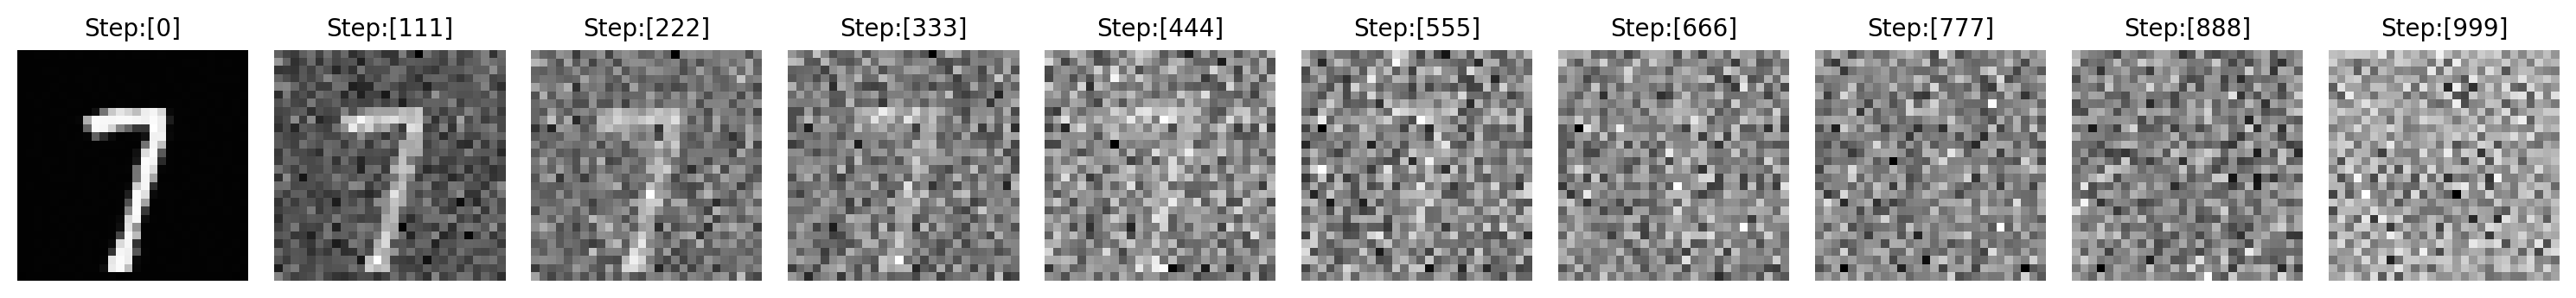

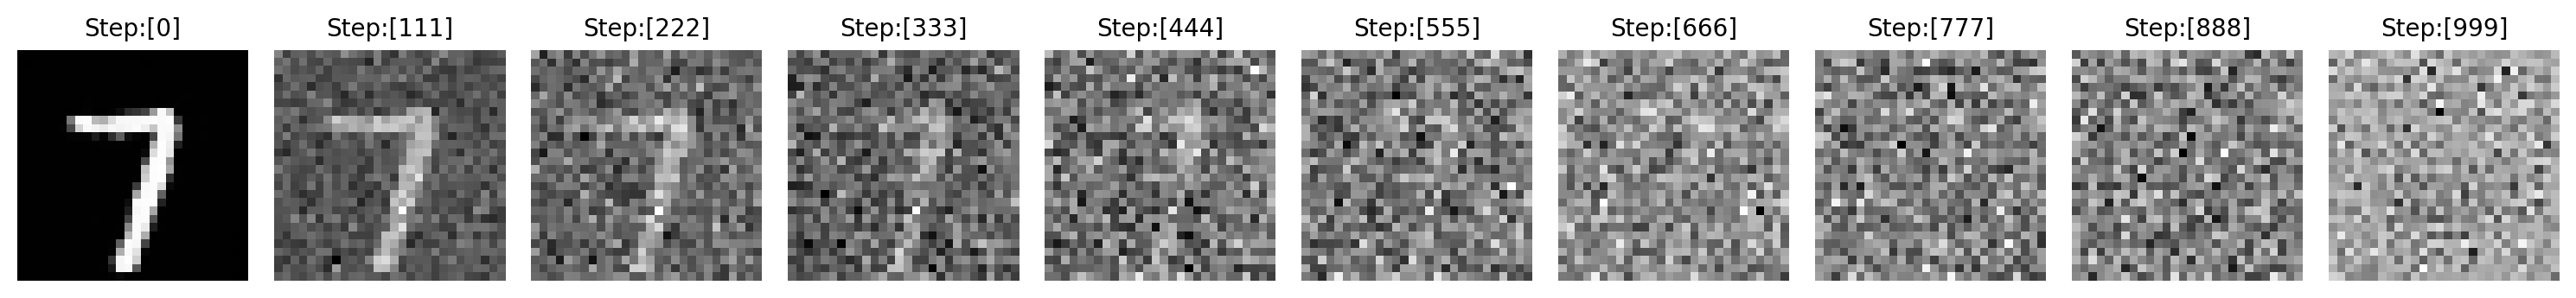

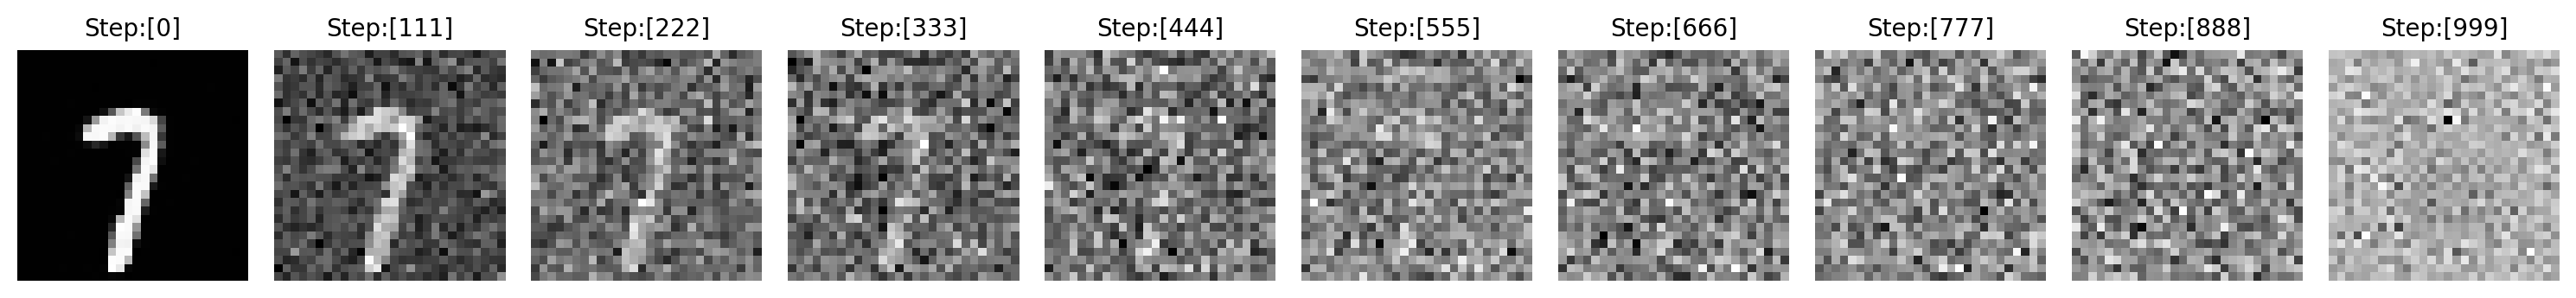

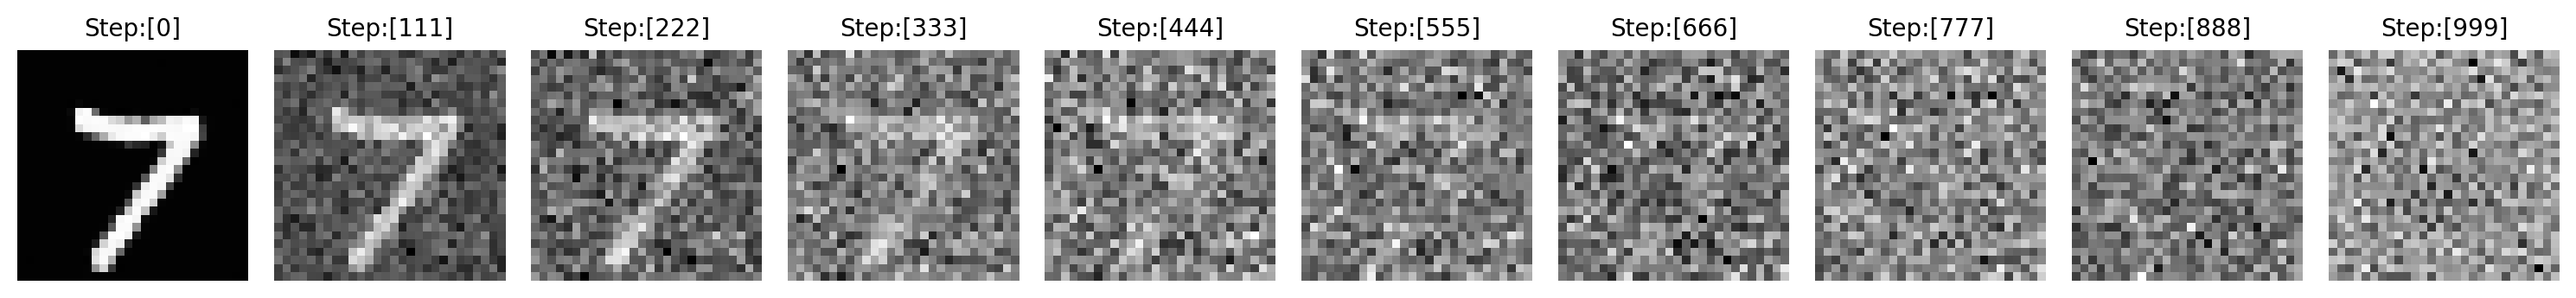

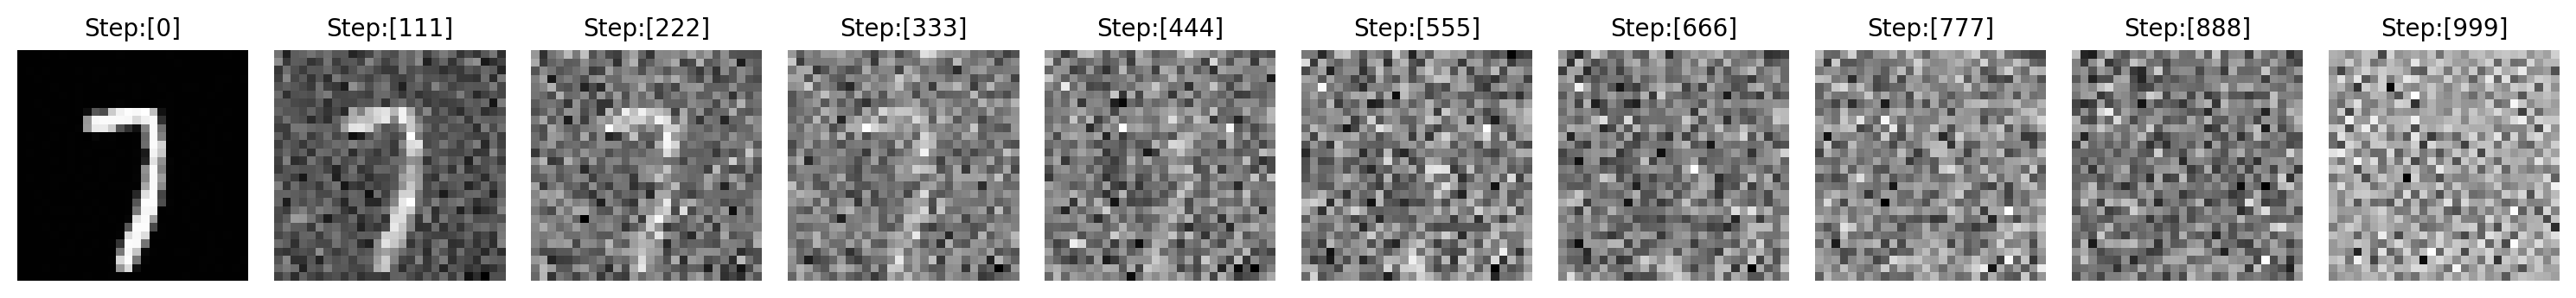

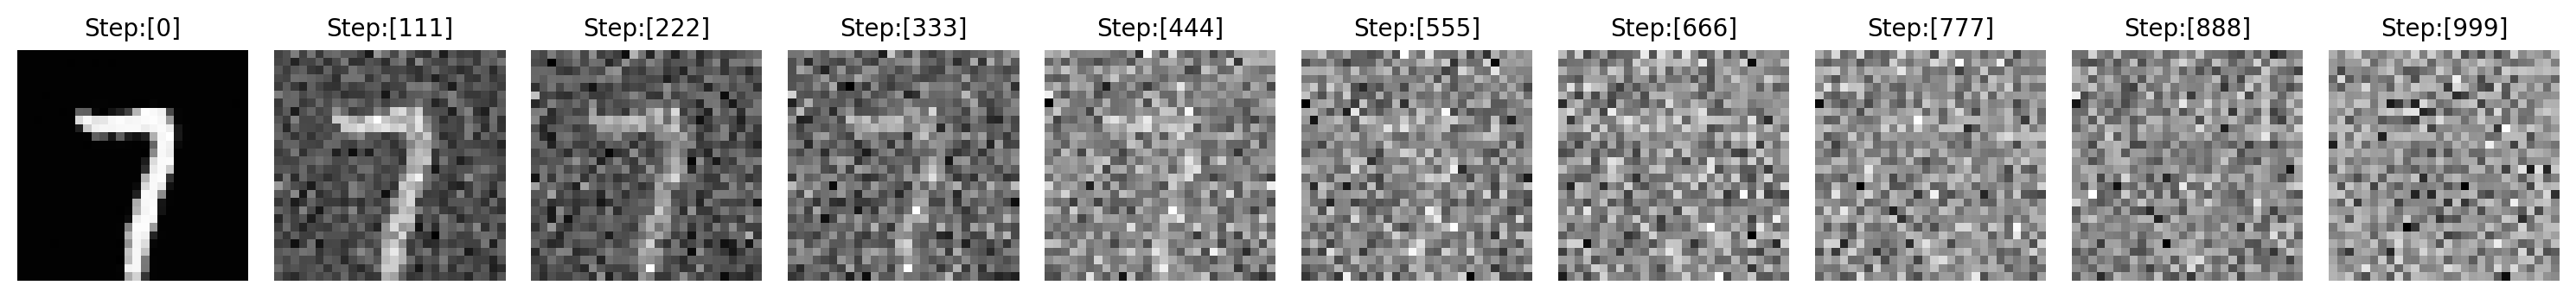

In [23]:
def get_conditioning_embedding_circle_number(circle, number, device):
    circle_label = circle
    # 레이블을 텐서로 변환
    circle_label = torch.tensor(circle_label, dtype=torch.long).to(device)
    number_label = torch.tensor(number, dtype=torch.long).to(device)
    # 임베딩 벡터 생성
    circle_embed = circle_embedding(circle_label)
    number_embed = number_embedding(number_label)


    # 두 임베딩 벡터를 결합
    conditioning_embedding = torch.cat([circle_embed, number_embed], dim=-1)
    
    return conditioning_embedding

n_sample = 6
test_embedding_vector = get_conditioning_embedding_circle_number(0,9,device)
step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
x_t_list = eval_ddpm_2d(model,dc,n_sample,x_0,step_list_to_append,device,test_embedding_vector)
plot_ddpm_2d_result(x_0,step_list_to_append,x_t_list,n_plot=n_sample)

100%|██████████| 10/10 [07:53<00:00, 47.38s/it]

Cosine Similarities:


Similarity 0  Similarity 1  Similarity 2  Similarity 3  Similarity 4  \
Digit 0      1.000000      0.984116      0.983981      0.978665      0.978157   
Digit 1      0.984138      0.999999      0.983032      0.978065      0.982642   
Digit 2      0.983862      0.982993      0.999999      0.993432      0.990600   
Digit 3      0.978706      0.978180      0.993428      0.999999      0.988914   
Digit 4      0.978081      0.982603      0.990619      0.988966      0.999999   
Digit 5      0.980837      0.979199      0.990668      0.992080      0.987114   
Digit 6      0.989062      0.984429      0.992811      0.986084      0.988860   
Digit 7      0.972888      0.979835      0.988242      0.990396      0.989343   
Digit 8      0.987776      0.984382      0.993809      0.988804      0.988420   
Digit 9      0.981953      0.982094      0.990424      0.990611      0.992135   

         Similarity 5  Similarity 6  Similarity 7  Similarity 8  Similarity 9  
Digit 0      0.980907      0.989070      0.973028      0.987849      0.982028  
Digit 1      0.979262      0.984500      0.979932      0.984417      0.982198  
Digit 2      0.990633      0.992750      0.988422      0.993735      0.990502  
Digit 3      0.992104      0.986167      0.990343      0.988740      0.990661  
Digit 4      0.987130      0.988816      0.989463      0.988359      0.992149  
Digit 5      1.000000      0.990123      0.980474      0.990069      0.987367  
Digit 6      0.990123      0.999999      0.979849      0.994650      0.990975  
Digit 7      0.980513      0.979903      0.999999      0.981810      0.992238  
Digit 8      0.990047      0.994600      0.981480      0.999999      0.989592  
Digit 9      0.987329      0.990984      0.992253      0.989588      0.999999

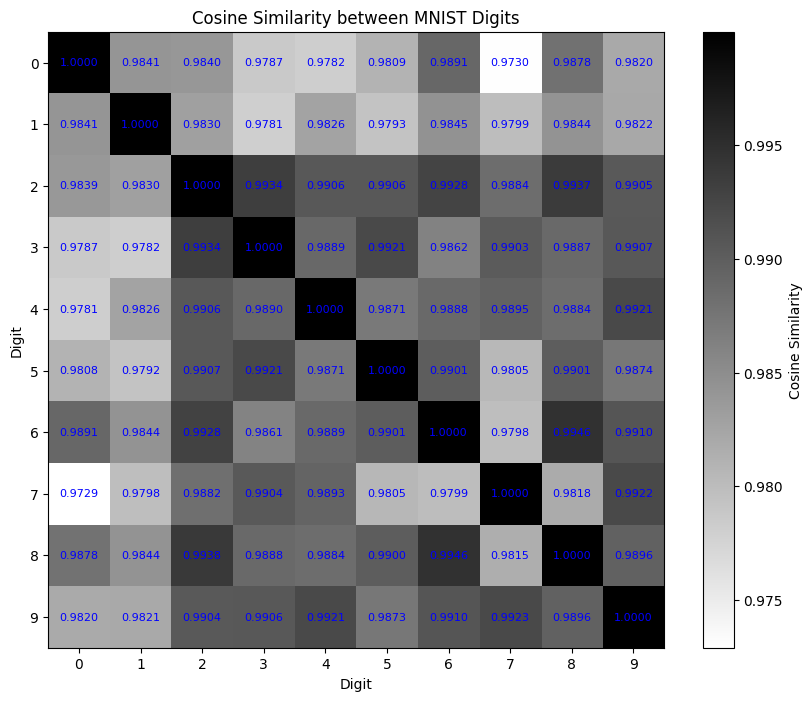

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import clip
from PIL import Image
from tqdm import tqdm
import random

def mnist(root_path='../data/', batch_size=128):
    """ 
    MNIST
    """
    mnist_train = datasets.MNIST(root=root_path, train=True, transform=transforms.ToTensor(), download=True)
    mnist_test = datasets.MNIST(root=root_path, train=False, transform=transforms.ToTensor(), download=True)
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=1)
    # Data
    train_data, train_label = mnist_train.data, mnist_train.targets
    test_data, test_label = mnist_test.data, mnist_test.targets
    return train_iter, test_iter, train_data, train_label, test_data, test_label

def tensor_to_pil(image_tensor):
    image_tensor = image_tensor.squeeze(0)  # Remove channel dimension
    image_pil = transforms.ToPILImage()(image_tensor)
    return image_pil

def calculate_clip_similarity(train_data, train_label, sample_size=1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    similarities = np.zeros((10, 10))

    for i in tqdm(range(10)):
        indices_i = torch.where(train_label == i)[0].tolist()
        sampled_indices_i = random.sample(indices_i, min(sample_size, len(indices_i)))
        images_i = train_data[sampled_indices_i]
        images_i = [preprocess(tensor_to_pil(image)) for image in images_i]
        images_i = torch.stack(images_i).to(device)

        with torch.no_grad():
            features_i = model.encode_image(images_i).float()

        for j in range(10):
            indices_j = torch.where(train_label == j)[0].tolist()
            sampled_indices_j = random.sample(indices_j, min(sample_size, len(indices_j)))
            images_j = train_data[sampled_indices_j]
            images_j = [preprocess(tensor_to_pil(image)) for image in images_j]
            images_j = torch.stack(images_j).to(device)

            with torch.no_grad():
                features_j = model.encode_image(images_j).float()

            similarities[i, j] = torch.cosine_similarity(features_i.mean(dim=0), features_j.mean(dim=0), dim=0).mean().item()

    return similarities

def render_results(similarities):
    # Creating DataFrame for similarities
    df_similarities = pd.DataFrame(similarities, columns=[f'Similarity {i}' for i in range(10)], index=[f'Digit {i}' for i in range(10)])
    
    # Displaying the similarity table
    print("Cosine Similarities:")
    display(df_similarities)
    
    # Plotting the graph
    plt.figure(figsize=(10, 8))
    plt.imshow(similarities, cmap='gray_r', interpolation='none')  # Use 'gray_r' to make darker colors represent higher similarity
    plt.colorbar(label='Cosine Similarity')
    plt.title('Cosine Similarity between MNIST Digits')
    plt.xlabel('Digit')
    plt.ylabel('Digit')
    plt.xticks(ticks=np.arange(10), labels=np.arange(10))
    plt.yticks(ticks=np.arange(10), labels=np.arange(10))

    # Annotate each cell with the similarity value
    for i in range(10):
        for j in range(10):
            plt.text(j, i, f'{similarities[i, j]:.4f}', ha='center', va='center', color='blue', fontsize=8)

    plt.show()

train_iter, test_iter, train_data, train_label, test_data, test_label = mnist()
similarities = calculate_clip_similarity(train_data, train_label, 5000)
render_results(similarities)

In [ ]:
# import torch

# # 저장된 파일 경로
# load_path = 'path/to/save/diffusion_model.pth'

# # 모델과 옵티마이저를 초기화
# model = DiffusionUNetLegacy(
#     name                 = 'unet',
#     dims                 = 2,
#     n_in_channels        = 1,
#     n_base_channels      = 64,
#     n_emb_dim            = 128,
#     n_cond_dim           = embedding_dim,
#     n_enc_blocks         = 4,
#     n_dec_blocks         = 4,
#     n_groups             = 16,
#     n_heads              = 4,
#     actv                 = nn.SiLU(),
#     kernel_size          = 3,
#     padding              = 1,
#     use_attention        = False,
#     skip_connection      = True,
#     chnnel_multiples     = (1,2,4,8),
#     updown_rates         = (1,2,1,2),
#     use_scale_shift_norm = True,
#     device               = device,
# )

# optm = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.0)
# schd = torch.optim.lr_scheduler.ExponentialLR(optimizer=optm, gamma=0.99998)

# # 체크포인트 로드
# checkpoint = torch.load(load_path)

# # 모델과 옵티마이저 상태 복원
# model.load_state_dict(checkpoint['model_state_dict'])
# optm.load_state_dict(checkpoint['optimizer_state_dict'])
# schd.load_state_dict(checkpoint['scheduler_state_dict'])

# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.train()  # 모델을 학습 모드로 설정
# # model.eval()  # 평가 모드로 설정하려면 이 라인을 사용

# print(f'Model loaded from {load_path}, resumed from iteration {epoch}')